## Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, mutual_info_score
import plotly.express as px

from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

import random

from transformers import AutoTokenizer,AutoModelForCausalLM

In [ ]:
  #!pip install pyreadstat

In [ ]:
!pip install kneed

In [ ]:
!pip install statsmodels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Approach

### Accompanying notebooks

* "Kopie van Final code-All models.ipynb" - probing the LLMs and getting the model moral scores, files saved in 'MyDrive/MSc Applied Data Science/ADS thesis/Mijn data' / (Final code all models - Draft Mijntje.ipynb cleaned up version)
* 'Definitieve kopie van Models Final.ipynb' - preprocessing the WVS dataset (WVS_Moral) and acquiring the WVS moral scores, saved at 'MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/WVS_moral_scores.csv'

### Load in preprocessed WVS scores

In [ ]:
# load in WVS scores, preprocessed in notebook Definitieve kopie van Models Final.ipynb

WVS_df = pd.read_csv('/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/WVS_moral_scores.csv')

WVS_preprocessed_df = WVS_df.pivot(index='country', columns='topic', values='wvs_score')

# Define the desired column order
column_order = [
    'claiming government benefits to which you are not entitled',
    'avoiding a fare on public transport',
    'stealing property',
    'cheating on taxes',
    'someone accepting a bribe in the course of their duties',
    'homosexuality',
    'prostitution',
    'abortion',
    'divorce',
    'sex before marriage',
    'suicide',
    'euthanasia',
    'for a man to beat his wife',
    'parents beating children',
    'violence against other people',
    'terrorism as a political, ideological or religious mean',
    'having casual sex',
    'political violence',
    'death penalty'
]

# Reorder columns
WVS_preprocessed_df = WVS_preprocessed_df[column_order]


In [ ]:
# take a look at the WVS ground truth moral scores per country

WVS_preprocessed_df

topic          claiming government benefits to which you are not entitled  \
country                                                                     
Andorra                                                -0.778001            
Argentina                                              -0.208916            
Armenia                                                -0.808106            
Australia                                              -0.826899            
Bangladesh                                             -0.772407            
Bolivia                                                -0.117990            
Brazil                                                 -0.680531            
Canada                                                 -0.703114            
Chile                                                  -0.216909            
China                                                  -0.489638            
Colombia                                               -0.382749            
Cyprus                                                 -0.747033            
Ecuador                                                -0.235510            
Egypt                                                  -0.824633            
Ethiopia                                               -0.860317            
Germany                                                -0.880387            
Greece                                                 -0.869610            
Guatemala                                              -0.301692            
Indonesia                                              -0.493280            
Iran                                                   -0.422585            
Iraq                                                   -0.430000            
Japan                                                  -0.830418            
Jordan                                                 -0.556685            
Kazakhstan                                             -0.466001            
Kenya                                                  -0.485257            
Kyrgyzstan                                             -0.541371            
Lebanon                                                -0.466439            
Libya                                                  -0.639179            
Malaysia                                               -0.245494            
Maldives                                               -0.809707            
Mexico                                                 -0.178463            
Mongolia                                               -0.370438            
Morocco                                                -0.405000            
Myanmar                                                -0.410064            
Netherlands                                            -0.873469            
New Zealand                                            -0.780834            
Nicaragua                                              -0.324815            
Nigeria                                                -0.777057            
Pakistan                                               -0.613825            
Peru                                                   -0.446826            
Philippines                                            -0.047963            
Romania                                                -0.741628            
Russia                                                 -0.357709            
Singapore                                              -0.657333            
South Korea                                            -0.503257            
Taiwan ROC                                             -0.555192            
Tajikistan                                             -0.533704            
Thailand                                               -0.729697            
Tunisia                                                -0.608192            
Turkey                                                 -0.801789         

### Load in preprocessed PEW scores

In [ ]:
# load in WVS scores, preprocessed in notebook Definitieve kopie van Models Final.ipynb

PEW_df = pd.read_csv('/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/PEW_moral_scores.csv')

PEW_preprocessed_df = PEW_df.pivot(index='country', columns='topic', values='pew_score')

# # Define the desired column order
# column_order = [
#     'claiming government benefits to which you are not entitled',
#     'avoiding a fare on public transport',
#     'stealing property',
#     'cheating on taxes',
#     'someone accepting a bribe in the course of their duties',
#     'homosexuality',
#     'prostitution',
#     'abortion',
#     'divorce',
#     'sex before marriage',
#     'suicide',
#     'euthanasia',
#     'for a man to beat his wife',
#     'parents beating children',
#     'violence against other people',
#     'terrorism as a political, ideological or religious mean',
#     'having casual sex',
#     'political violence',
#     'death penalty'
# ]

# # Reorder columns
# WVS_preprocessed_df = WVS_preprocessed_df[column_order]

display(PEW_df)
display(PEW_preprocessed_df)



country                            topic  pew_score
0    United States             using contraceptives   0.459082
1    United States                getting a divorce   0.132735
2    United States               having an abortion  -0.296407
3    United States                    homosexuality  -0.158683
4    United States                 drinking alcohol   0.177645
..             ...                              ...        ...
307    El Salvador                    homosexuality  -0.535354
308    El Salvador                 drinking alcohol  -0.714646
309    El Salvador  married people having an affair  -0.857323
310    El Salvador                         gambling  -0.748737
311    El Salvador     sex between unmarried adults  -0.318182

[312 rows x 3 columns]

topic                    drinking alcohol  gambling  getting a divorce  \
country                                                                  
Argentina                       -0.136752 -0.274725           0.438339   
Australia                        0.300000 -0.156250           0.402500   
Bolivia                         -0.572500 -0.507500          -0.188750   
Brazil                          -0.175000 -0.495833           0.375000   
Britain                          0.292490 -0.047431           0.328063   
Canada                           0.218260 -0.052782           0.275321   
Chile                           -0.015000 -0.305000           0.500000   
China                           -0.287663 -0.462182           0.199318   
Czech Republic                   0.240000 -0.538571           0.494286   
Egypt                           -0.707000 -0.881000           0.442000   
El Salvador                     -0.714646 -0.748737          -0.175505   
France                           0.125498  0.163347           0.377490   
Germany                          0.312195 -0.047805           0.520976   
Ghana                           -0.692115 -0.871089          -0.664581   
Greece                          -0.010000 -0.446000           0.233000   
Indonesia                       -0.834000 -0.865000          -0.380000   
Israel                          -0.151844 -0.462039          -0.002169   
Italy                           -0.124887 -0.211765           0.335747   
Japan                            0.597143  0.057143           0.425714   
Jordan                          -0.819000 -0.886000           0.477000   
Kenya                           -0.478697 -0.593985          -0.403509   
Lebanon                         -0.261000 -0.729000           0.387000   
Malaysia                        -0.588808 -0.680049          -0.271290   
Mexico                          -0.188000 -0.360000           0.077000   
Nigeria                         -0.581959 -0.762367          -0.484966   
Pakistan                        -0.928393 -0.934221          -0.644463   
Palestinian territories         -0.881481 -0.903704           0.044444   
Philippines                     -0.047264 -0.404229          -0.421642   
Poland                           0.206250 -0.108750           0.141250   
Russia                          -0.175703 -0.505020           0.243976   
Senegal                         -0.532500 -0.561250           0.032500   
South Africa                    -0.111656 -0.195092          -0.214724   
South Korea                      0.112485 -0.721879           0.035847   
Spain                            0.056000 -0.098000           0.522000   
Tunisia                         -0.807000 -0.901000          -0.320000   
Turkey                          -0.544000 -0.685000           0.025000   
Uganda                          -0.381250 -0.770000          -0.667500   
United States                    0.177645  0.016966           0.132735   
Venezuela                       -0.035000 -0.394000           0.339000   

topic                    having an abortion  homosexuality  \
country                                                      
Argentina                         -0.382173       0.201465   
Australia                          0.080000       0.172500   
Bolivia                           -0.770000      -0.198750   
Brazil                            -0.723958       0.052083   
Britain                            0.018775       0.174901   
Canada                             0.011412       0.141227   
Chile                             -0.452500       0.152500   
China                             -0.072846      -0.472412   
Czech Republic                     0.308571       0.422857   
Egypt                             -0.571000      -0.936000   
El Salvador                       -0.834596      -0.535354   
France                             0.250000       0.238048   
Germany                            0.282927       0.447805   
Ghana                             -

### Models

In [ ]:
# TODO: integrate models to generate scores (see 1Probing_Optimized.ibynb)

# 1. gpt2-large / other version that can be used with gpt code we already have?
# 2. bloom560
# 3. llama
# 4. gemma?
# 5. T5 perhaps? (encoder-decoder)
# 6. see lourenco and evi's suggestions?

In [ ]:
models = ['gpt2-medium', 'gpt2-large', 'QWEN', 'OPT-125', 'BLOOM']
lms = ['gpt2-medium', 'gpt2-large', 'QWEN', 'OPT-125', 'BLOOM']
lms_names = ['gpt2-medium', 'gpt2-large', 'QWEN', 'OPT-125', 'BLOOM']

In [ ]:
# # create the combined df's from the separate prompt style result files we have in drive, #TODO later: add this function to the 'Kopie van Final code - All models.ipynb' to be executed immediately after generating the results for both prompt styles & export BOTH file to 'Mijn data' directory too

# def generate_combined_df(df_people, df_in, model):

#   # now create the combined df

#   #Step 1: Concatenate the DataFrames column-wise
#   combined_df = pd.concat([df_people, df_in], axis=1)

#   # Assuming the 'log prob difference' columns have the same name, differentiate them
#   combined_df.columns = [f'{col}_people' if i < len(df_people.columns) else f'{col}_in' for i, col in enumerate(combined_df.columns)]

#   # Step 2: Calculate the average log probability difference
#   combined_df['average log prob difference'] = (combined_df['log prob difference_people'] + combined_df['log prob difference_in']) / 2

#   combined_df['average normalized log prob'] = (combined_df['normalized log prob difference_people'] + combined_df['normalized log prob difference_in']) / 2

#   # Step 3: Remove the 'country_in', 'topic_in', and 'wvs_score_in' columns
#   columns_to_remove = ['country_in', 'topic_in', 'wvs_score_in']
#   combined_df.drop(columns=columns_to_remove, inplace=True)

#   # Step 4: Rename the columns
#   combined_df.rename(columns={
#     'country_people': 'country',
#     'topic_people': 'topic',
#     'wvs_score_people': 'wvs_score'
#   }, inplace=True)

#   # Print the resulting DataFrame
#   display(combined_df)
#   return(combined_df)

In [ ]:
# for model in models:
#   df_people = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/wvs_w7_{model}_token_pairs_people-MIJNTJE-FINAL.csv')
#   df_in = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/wvs_w7_{model}_token_pairs_in-MIJNTJE-FINAL.csv')
#   combined_df = generate_combined_df(df_people, df_in, model)
#   save_dir = f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/wvs_w7_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv'
#   combined_df.to_csv(save_dir, index=False)


## Part 1. Comparing variation between countries on survey and model scores for moral topics


### Standard deviation comparison

#### WVS

In [ ]:
# TODO: display descriptive statistics; average values per topic, both for WVS/PEW scores and model scores

In [ ]:
# compare cross-country variation on topics between original WVS moral scores & model-generated moral scores

variation_rows = []

for model in models:

  for topic in WVS_preprocessed_df.columns:

    wvs_scores = WVS_preprocessed_df[topic]

    # the below .csv file was generated using 'Definitieve kopie van Models Final.ipynb', and it has for each model the average of the model-generated moral score for 'in' and 'people' prompting mode, using all token pairs and taking the mean for both prompting modes

    model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/Final test/wvs_w7_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

    # TODO: change to normalized log prob difference

    model_scores = model_df.loc[model_df['topic'] == topic]['average normalized log prob']

    wvs_var = np.var(wvs_scores.values)
    model_var = np.var(model_scores.values)

    row = {'dataname': "WVS", 'model': model, 'WVS variation': wvs_var, 'model variation': model_var, 'topic': topic}
    variation_rows.append(row)

df = pd.DataFrame(variation_rows)
df

#TODO: compare with original paper, did they also find such small variation with the models compared to the survey (a.k.a. models predict kinda the same thing for different countries?)

dataname        model  WVS variation  model variation  \
0       WVS  gpt2-medium       0.050250         0.006521   
1       WVS  gpt2-medium       0.050506         0.012787   
2       WVS  gpt2-medium       0.015135         0.008894   
3       WVS  gpt2-medium       0.020463         0.016437   
4       WVS  gpt2-medium       0.018882         0.004620   
..      ...          ...            ...              ...   
90      WVS        BLOOM       0.015286         0.001551   
91      WVS        BLOOM       0.030471         0.009127   
92      WVS        BLOOM       0.122007         0.002305   
93      WVS        BLOOM       0.029183         0.002342   
94      WVS        BLOOM       0.078559         0.003646   

                                                topic  
0   claiming government benefits to which you are ...  
1                 avoiding a fare on public transport  
2                                   stealing property  
3                                   cheating on taxes  
4   someone accepting a bribe in the course of the...  
..                                                ...  
90                      violence against other people  
91  terrorism as a political, ideological or relig...  
92                                  having casual sex  
93                                 political violence  
94                                      death penalty  

[95 rows x 5 columns]

In [ ]:
# TODO: average variation scores per model & compared to WVS scores

In [ ]:
def draw_model(models, dataset):
    list_rows = []
    fig, axes = plt.subplots(1, len(models), figsize=(4 * len(models), 3), sharey=False, sharex=True)
    plt.subplots_adjust(wspace = 0.4, hspace=0.8)

    if dataset == 'WVS':
      topics_list = list(WVS_preprocessed_df.columns)

    elif dataset == 'PEW':
      topics_list = list(PEW_preprocessed_df.columns)

    topic_mapping = {topic: f'{i + 1}) {topic}' for i, topic in enumerate(topics_list)}

    for i, model in enumerate(models):
        # Get the corresponding model name
        model_name = lms_names[lms.index(model)]

        # Filter the DataFrame for the specific model
        model_df = df[df.model == model_name]

        # Plotting
        ax = axes[i]
        g = sns.regplot(data=model_df, x=f'{dataset} variation', y='model variation', ax=ax, color='grey')
        g = sns.scatterplot(data=model_df, x=f'{dataset} variation', y='model variation', hue='topic', ax=ax, legend=True)

        ax.set_ylabel('Model variation')
        ax.set_xlabel(f'Empirical {dataset} survey variation')
        ax.set_title(model_name)
        ax.legend().remove()

        for _, row in model_df.iterrows():
            x = row[f'{dataset} variation']
            y = row['model variation']
            s = topics_list.index(row['topic']) + 1
            ax.text(x=x, y=y, s=s)

        slope, intercept, r_value, p_value, std_err = stats.linregress(model_df['model variation'], model_df[f'{dataset} variation'])
        row = {'model': model_name, 'r': round(r_value, 3), 'p': round(p_value, 3)}
        list_rows.append(row)

        sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

    handles, labels = axes[0].get_legend_handles_labels()
    new_labels = [f'{i + 1}) {label}' for i, label in enumerate(labels)]
    fig.legend(handles, new_labels,  loc='center left', bbox_to_anchor=(0.92, 0.5), fontsize='large')

    return list_rows

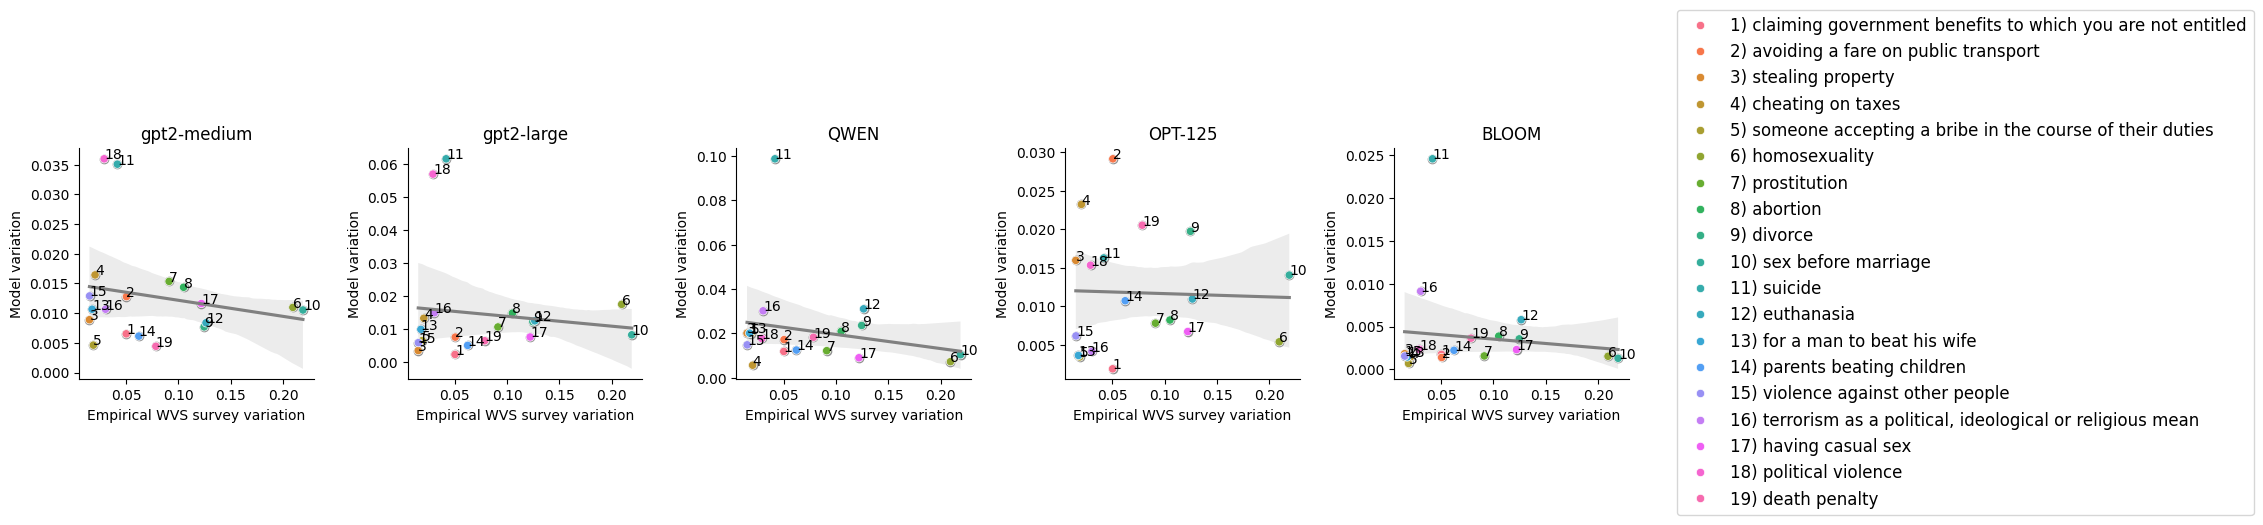

In [ ]:
list_rows = draw_model(models, 'WVS')

#TODO: normalize plots / get on the same scale?

### Test differences between variations for significance with correlation

In [ ]:
import statsmodels.stats.multitest
df_list_rows = pd.DataFrame(list_rows)
display(df_list_rows)
df_list_rows['corrected p'] = statsmodels.stats.multitest.multipletests(df_list_rows['p'], alpha=0.05, method='bonferroni', \
                                                              is_sorted=False, returnsorted=False)[1]

model      r      p
0  gpt2-medium -0.195  0.424
1   gpt2-large -0.115  0.640
2         QWEN -0.200  0.413
3      OPT-125 -0.035  0.887
4        BLOOM -0.118  0.631

In [ ]:
df_list_rows

model      r      p  corrected p
0  gpt2-medium -0.195  0.424          1.0
1   gpt2-large -0.115  0.640          1.0
2         QWEN -0.200  0.413          1.0
3      OPT-125 -0.035  0.887          1.0
4        BLOOM -0.118  0.631          1.0

#### Provisional conclusion standard deviation comparison

* Non-significant correlations: The weak correlations observed between the WVS variation and model variation are not statistically significant, implying that the model's performance variation does not strongly correspond to the WVS variation.

* Implication: There is no strong evidence from this analysis to suggest that the variation in WVS scores is related to the variation in the models' log probability differences for these topics.

In [ ]:
# top k most controversial topics according to WVS survey & their variance scores

topic_variations = df[['WVS variation', 'topic']][:19]

#display(topic_variations)

most_controversial_WVS = topic_variations.nlargest(5, 'WVS variation')
print("Top 5 most controversial topics:")
display(most_controversial_WVS)


most_agreed_on_WVS = topic_variations.nsmallest(5, 'WVS variation')
print("Top 5 most agreed on topics:")
display(most_agreed_on_WVS)


# top k most agreed upon topics & their variance scores

Top 5 most controversial topics:


WVS variation                topic
9        0.218995  sex before marriage
5        0.209379        homosexuality
11       0.126444           euthanasia
8        0.124605              divorce
16       0.122007    having casual sex

Top 5 most agreed on topics:


WVS variation                                              topic
2        0.015135                                  stealing property
14       0.015286                      violence against other people
12       0.017651                         for a man to beat his wife
4        0.018882  someone accepting a bribe in the course of the...
3        0.020463                                  cheating on taxes

#### PEW

In [ ]:
# compare cross-country variation on topics between original WVS moral scores & model-generated moral scores

variation_rows = []

for model in models:

  for topic in PEW_preprocessed_df.columns:

    pew_scores = PEW_preprocessed_df[topic]

    # the below .csv file was generated using 'Definitieve kopie van Models Final.ipynb', and it has for each model the average of the model-generated moral score for 'in' and 'people' prompting mode, using all token pairs and taking the mean for both prompting modes

    model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/Final test/PEW_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

    # TODO: change to normalized log prob difference

    model_scores = model_df.loc[model_df['topic'] == topic]['average normalized log prob']

    pew_var = np.var(pew_scores.values)
    model_var = np.var(model_scores.values)

    row = {'dataname': "PEW", 'model': model, 'PEW variation': pew_var, 'model variation': model_var, 'topic': topic}
    variation_rows.append(row)

df = pd.DataFrame(variation_rows)
df

#TODO: compare with original paper, did they also find such small variation with the models compared to the survey (a.k.a. models predict kinda the same thing for different countries?)

dataname        model  PEW variation  model variation  \
0       PEW  gpt2-medium       0.157193         0.019324   
1       PEW  gpt2-medium       0.097406         0.039499   
2       PEW  gpt2-medium       0.131490         0.043433   
3       PEW  gpt2-medium       0.130064         0.013410   
4       PEW  gpt2-medium       0.216320         0.015629   
5       PEW  gpt2-medium       0.021123         0.019667   
6       PEW  gpt2-medium       0.267761         0.023462   
7       PEW  gpt2-medium       0.085892         0.015788   
8       PEW   gpt2-large       0.157193         0.022527   
9       PEW   gpt2-large       0.097406         0.037801   
10      PEW   gpt2-large       0.131490         0.042921   
11      PEW   gpt2-large       0.130064         0.014515   
12      PEW   gpt2-large       0.216320         0.033382   
13      PEW   gpt2-large       0.021123         0.023063   
14      PEW   gpt2-large       0.267761         0.058616   
15      PEW   gpt2-large       0.085892         0.022516   
16      PEW         QWEN       0.157193         0.044230   
17      PEW         QWEN       0.097406         0.026500   
18      PEW         QWEN       0.131490         0.042902   
19      PEW         QWEN       0.130064         0.003560   
20      PEW         QWEN       0.216320         0.007132   
21      PEW         QWEN       0.021123         0.005547   
22      PEW         QWEN       0.267761         0.014968   
23      PEW         QWEN       0.085892         0.006344   
24      PEW      OPT-125       0.157193         0.030916   
25      PEW      OPT-125       0.097406         0.032281   
26      PEW      OPT-125       0.131490         0.037541   
27      PEW      OPT-125       0.130064         0.022098   
28      PEW      OPT-125       0.216320         0.018718   
29      PEW      OPT-125       0.021123         0.010641   
30      PEW      OPT-125       0.267761         0.019941   
31      PEW      OPT-125       0.085892         0.040669   
32      PEW        BLOOM       0.157193         0.005594   
33      PEW        BLOOM       0.097406         0.004016   
34      PEW        BLOOM       0.131490         0.002191   
35      PEW        BLOOM       0.130064         0.004425   
36      PEW        BLOOM       0.216320         0.002889   
37      PEW        BLOOM       0.021123         0.004328   
38      PEW        BLOOM       0.267761         0.019866   
39      PEW        BLOOM       0.085892         0.006045   

                              topic  
0                  drinking alcohol  
1                          gambling  
2                 getting a divorce  
3                having an abortion  
4                     homosexuality  
5   married people having an affair  
6      sex between unmarried adults  
7              using contraceptives  
8                  drinking alcohol  
9                          gambling  
10                getting a divorce  
11               having an abortion  
12                    homosexuality  
13  married people having an affair  
14     sex between unmarried adults  
15             using contraceptives  
16                 drinking alcohol  
17                         gambling  
18                getting a divorce  
19               having an abortion  
20                    homosexuality  
21  married people having an affair  
22     sex between unmarried adults  
23             using contraceptives  
24                 drinking alcohol  
25                         gambling  
26                getting a divorce  
27               having an abortion  
28                    homosexuality  
29  married people having an affair  
30     sex between unmarried adults  
31             using contraceptives  
32                 drinking alcohol  
33                         gambling  
34                getting a divorce  
35               having an abortion  
36                    homosexuality  
37  married people having an affair  
38     sex between unmarried adults  
39             using c

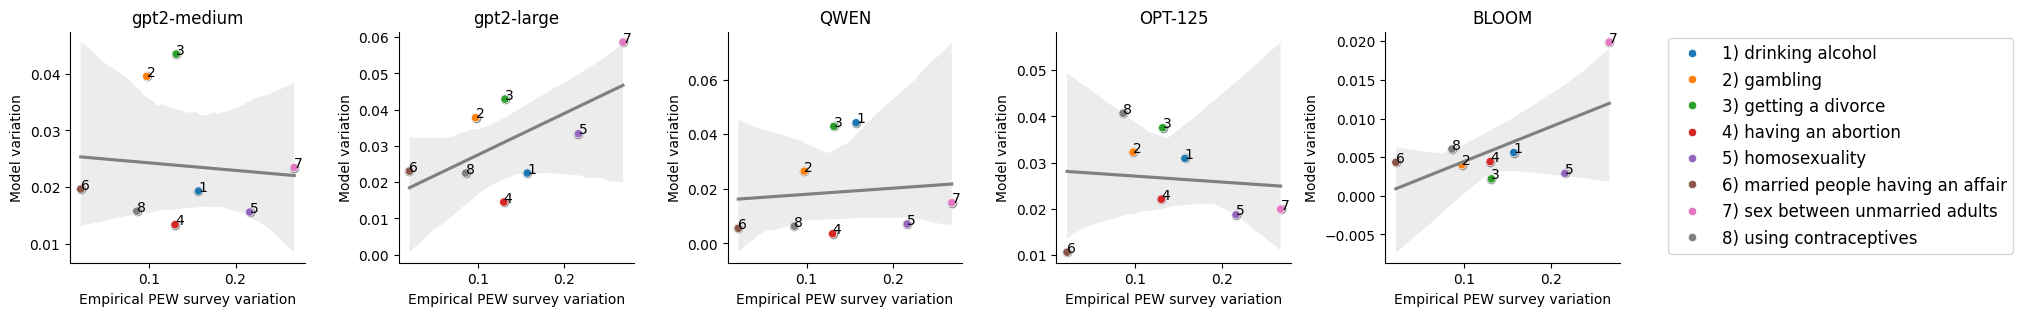

In [ ]:
list_rows = draw_model(models, 'PEW')

#TODO: normalize plots / get on the same scale?

In [ ]:
import statsmodels.stats.multitest
df_list_rows = pd.DataFrame(list_rows)
display(df_list_rows)
df_list_rows['corrected p'] = statsmodels.stats.multitest.multipletests(df_list_rows['p'], alpha=0.05, method='bonferroni', \
                                                              is_sorted=False, returnsorted=False)[1]

model      r      p
0  gpt2-medium -0.090  0.832
1   gpt2-large  0.617  0.103
2         QWEN  0.102  0.811
3      OPT-125 -0.095  0.822
4        BLOOM  0.608  0.110

In [ ]:
df_list_rows

model      r      p  corrected p
0  gpt2-medium -0.090  0.832        1.000
1   gpt2-large  0.617  0.103        0.515
2         QWEN  0.102  0.811        1.000
3      OPT-125 -0.095  0.822        1.000
4        BLOOM  0.608  0.110        0.550

In [ ]:
# top k most controversial topics according to PEW survey & their variance scores
topic_variations = df[['PEW variation', 'topic']][:8]

#display(topic_variations)

most_controversial_PEW = topic_variations.nlargest(3, 'PEW variation')
print("Top 3 most controversial topics:")
display(most_controversial_PEW)


most_agreed_on_PEW = topic_variations.nsmallest(3, 'PEW variation')
print("Top 3 most agreed on topics:")
display(most_agreed_on_PEW)


# top k most agreed upon topics & their variance scores

Top 3 most controversial topics:


PEW variation                         topic
6       0.267761  sex between unmarried adults
4       0.216320                 homosexuality
0       0.157193              drinking alcohol

Top 3 most agreed on topics:


PEW variation                            topic
5       0.021123  married people having an affair
7       0.085892             using contraceptives
1       0.097406                         gambling

#### #TODO for part 1

* Als mensen hetzelfde vinden ... -> wat vinden ze morally bad? En wat morally good?
  * Volgens de WVS survey
  * Volgens de modellen
* Are there differences in the models? ... significantly? Are some better than others / more closely reflect the ground truth moral variation?
==> compare MSE's from perfect correlation line?

## Part 2. Clustering countries on moral scores & assessing cluster alignment
In this part, we're comparing the clusters generated from the WVS scores with the clusters generated from the LM scores to see how well they align


In [ ]:
# Step 1: cluster countries based on which are most similar, taking into account moral scores for all topics, using K-means clustering
# First, we'll just use a set value for K, then later on we can see if we can find the best value for K by using grid search or something

# Step 2: use the same method of clustering for the model scores

# Step 3: compare clustering alignment

In [ ]:
models = ['gpt2-medium', 'gpt2-large', 'QWEN', 'OPT-125', 'BLOOM']

In [ ]:
#list(WVS_preprocessed_df.index)

### WVS


#### Defining functions

In [ ]:
# original function but with Ayoub & Hadi's PCA feedback points: explained variance

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    optimal_k = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts at 2
    return optimal_k, silhouette_scores

def find_optimal_pca_components(data, variance_threshold=0.95):
    pca = PCA().fit(data)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return optimal_components, cumulative_variance

def cluster_and_compare(preprocessed_df, dataset, models=None, mode='', variance_threshold=0.95):
    survey_data = np.array(preprocessed_df)
    optimal_k_survey, _ = find_optimal_k(survey_data, max_k=10)
    print(f'Optimal k for survey data: {optimal_k_survey}')
    kmeans_survey = KMeans(n_clusters=optimal_k_survey, random_state=0).fit(survey_data)
    labels_survey = kmeans_survey.labels_

    optimal_components, cumulative_variance = find_optimal_pca_components(survey_data, variance_threshold=variance_threshold)
    print(f'Optimal number of PCA components: {optimal_components}')
    pca = PCA(n_components=optimal_components)
    survey_data_2d = pca.fit_transform(survey_data)
    explained_variance_total = np.sum(pca.explained_variance_ratio_) * 100

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=survey_data_2d[:, 0], y=survey_data_2d[:, 1], hue=labels_survey, palette='viridis', s=100)
    for i, country in enumerate(list(preprocessed_df.index)):
        plt.text(survey_data_2d[i, 0], survey_data_2d[i, 1] + 0.005, country, fontsize=9, ha='center', va='top')
    plt.title(f'{dataset} survey data Clusters {mode} (Explained variance: {explained_variance_total:.2f}%)')
    plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance)')
    plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance)')
    plt.legend(title='Cluster')
    plt.show()

    if models:
        for model in models:
            print(f"Model: {model}")

            if dataset == 'WVS':
              model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/Final test/wvs_w7_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

            elif dataset == 'PEW':
              model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis/Mijn data/Final test/PEW_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

            model_df = model_df.pivot(index='country', columns='topic', values='average normalized log prob')
            model_df.columns.name = None
            model_df.reset_index(inplace=True)
            model_df.set_index('country', inplace=True)
            columns_order = preprocessed_df.columns
            model_df = model_df[columns_order]
            llm_responses = np.array(model_df)
            kmeans_llm = KMeans(n_clusters=optimal_k_survey, random_state=0).fit(llm_responses)
            labels_llm = kmeans_llm.labels_

            ari = adjusted_rand_score(labels_survey, labels_llm)
            ami = adjusted_mutual_info_score(labels_survey, labels_llm)
            print(f"Adjusted Rand Index: {round(ari, 3)}")
            print(f"Adjusted Mutual Information: {round(ami, 3)}")
            print((f"Combined Alignment Score: {round(((ari + ami) / 2),3)}"))

            llm_responses_2d = pca.fit_transform(llm_responses)
            explained_variance_llm = pca.explained_variance_ratio_
            explained_variance_llm_total = np.sum(explained_variance_llm[:2]) * 100

            plt.figure(figsize=(14, 10))
            sns.scatterplot(x=llm_responses_2d[:, 0], y=llm_responses_2d[:, 1], hue=labels_llm, palette='viridis', s=100)
            for i, country in enumerate(list(preprocessed_df.index)):
                plt.text(llm_responses_2d[i, 0], llm_responses_2d[i, 1] + 0.005, country, fontsize=9, ha='center', va='top')
            plt.title(f'{model}-Generated Data Clusters {mode} (Explained variance: {explained_variance_llm_total:.2f}%)')
            plt.xlabel(f'PCA Component 1 ({explained_variance_llm[0] * 100:.2f}% variance)')
            plt.ylabel(f'PCA Component 2 ({explained_variance_llm[1] * 100:.2f}% variance)')
            plt.legend(title='Cluster')
            plt.show()

# example function calls for 3-fold analysis (all topics, most controversial topics, most agreed on topics)
# cluster_and_compare(WVS_preprocessed_df)
# cluster_and_compare(WVS_preprocessed_df[controversial_topics])
# cluster_and_compare(WVS_preprocessed_df[agreed_topics])
# cluster_and_compare(WVS_preprocessed_df, models)
# cluster_and_compare(WVS_preprocessed_df[controversial_topics], models)
# cluster_and_compare(WVS_preprocessed_df[agreed_topics], models)


#### Result 1: all topics together

Optimal k for survey data: 2
Optimal number of PCA components: 8


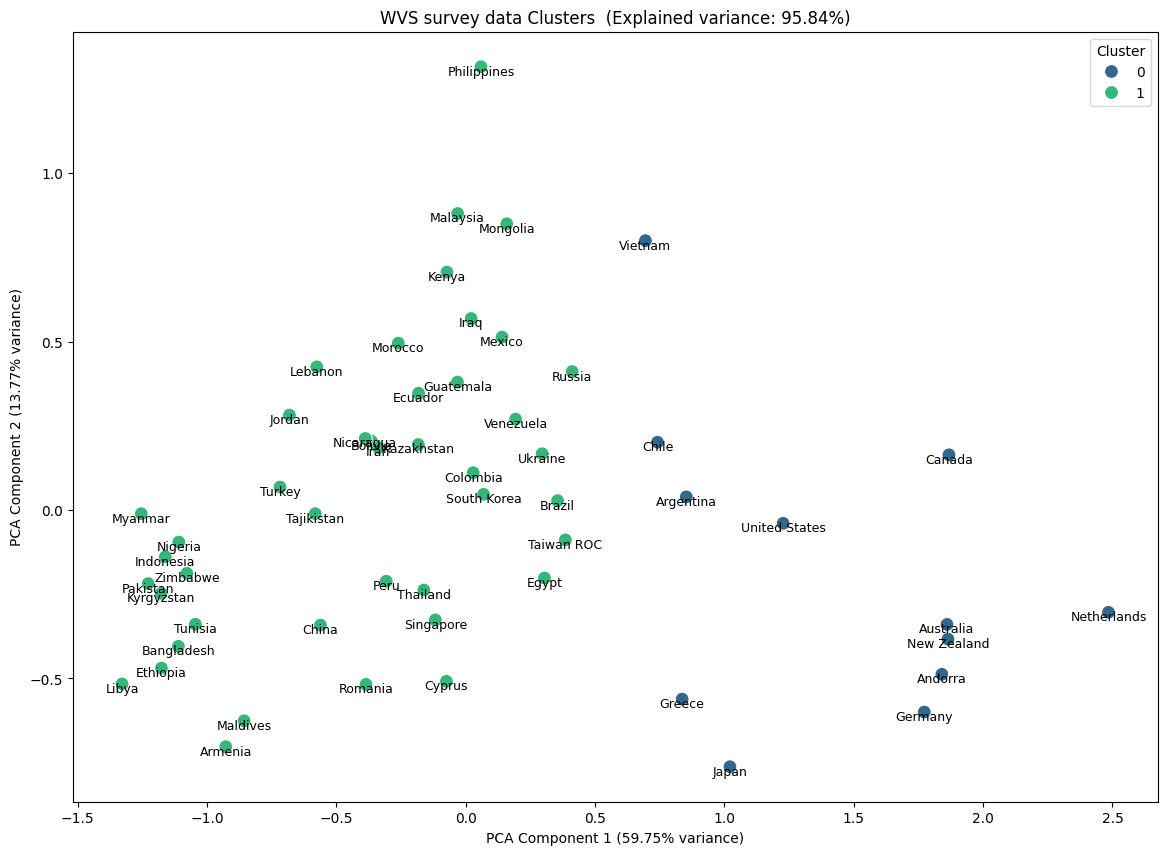

Model: gpt2-medium
Adjusted Rand Index: -0.012
Adjusted Mutual Information: -0.002
Combined Alignment Score: -0.007


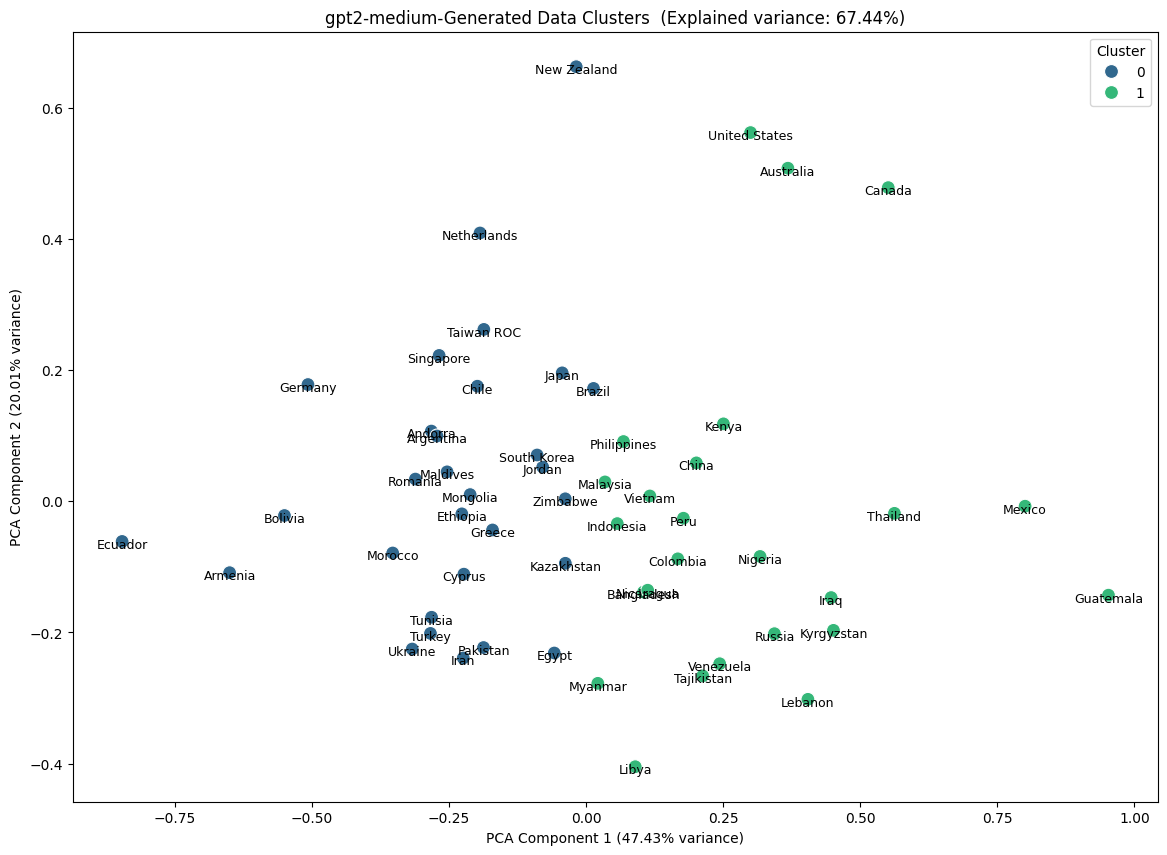

Model: gpt2-large
Adjusted Rand Index: 0.028
Adjusted Mutual Information: 0.04
Combined Alignment Score: 0.034


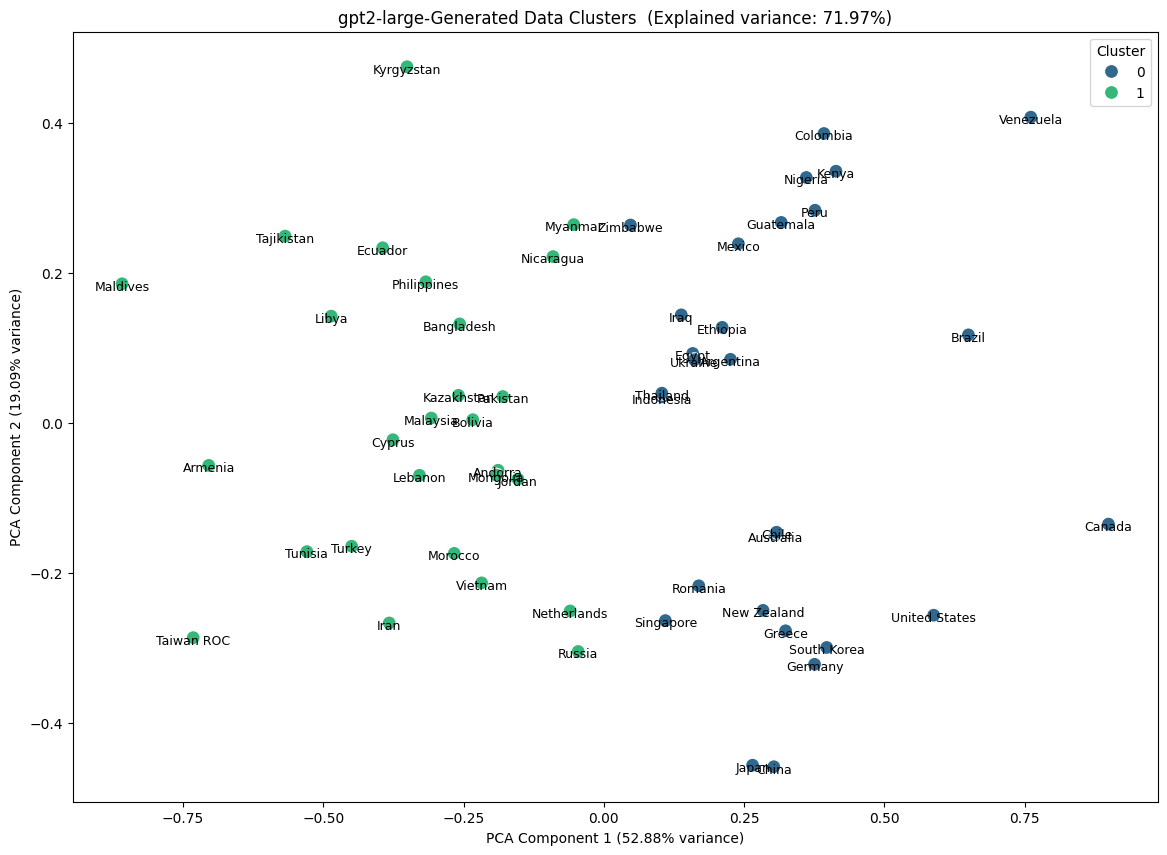

Model: QWEN
Adjusted Rand Index: 0.291
Adjusted Mutual Information: 0.138
Combined Alignment Score: 0.215


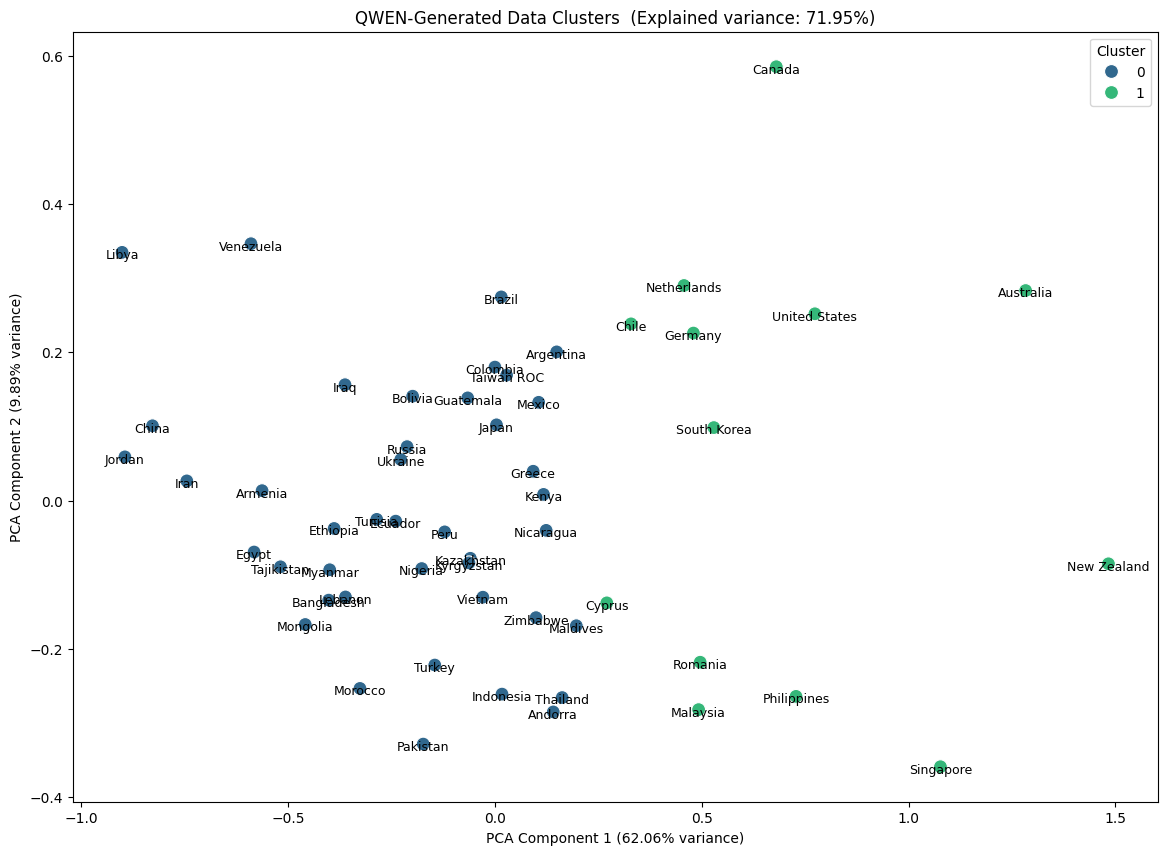

Model: OPT-125
Adjusted Rand Index: -0.073
Adjusted Mutual Information: 0.037
Combined Alignment Score: -0.018


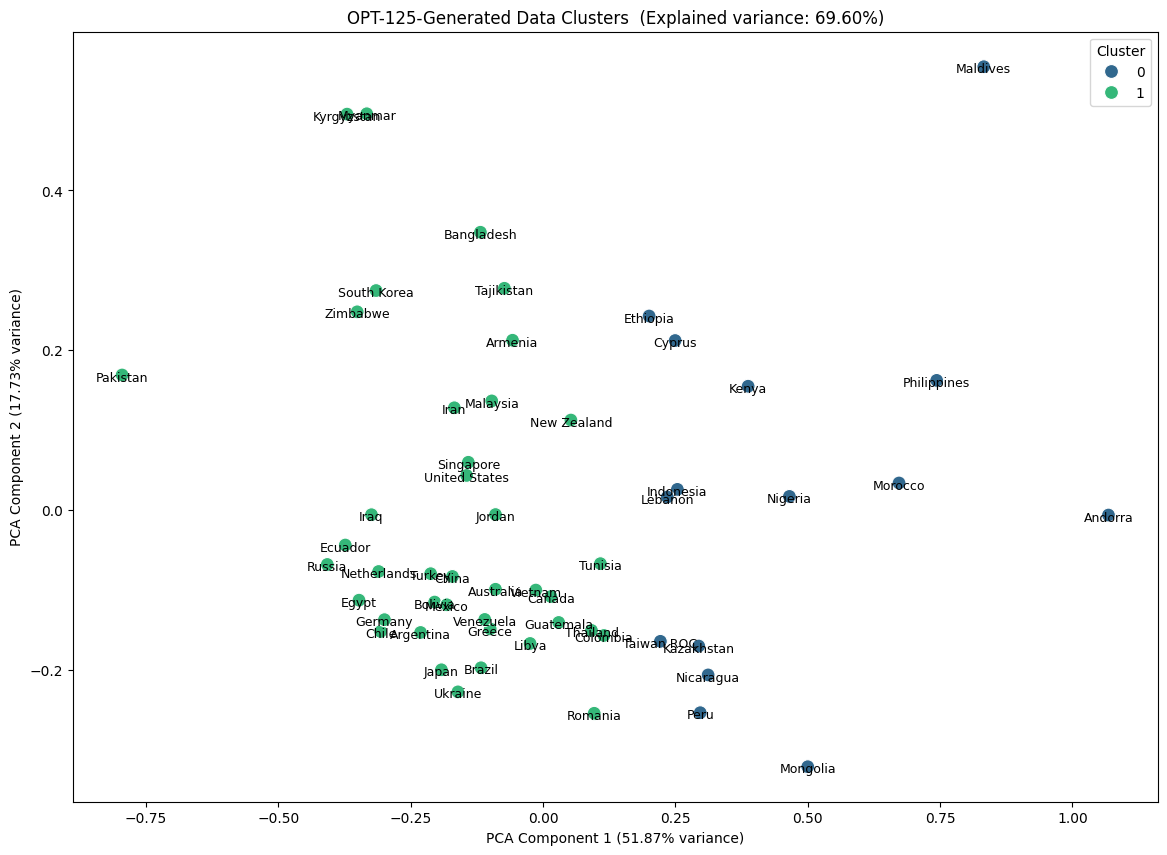

Model: BLOOM
Adjusted Rand Index: 0.015
Adjusted Mutual Information: -0.011
Combined Alignment Score: 0.002


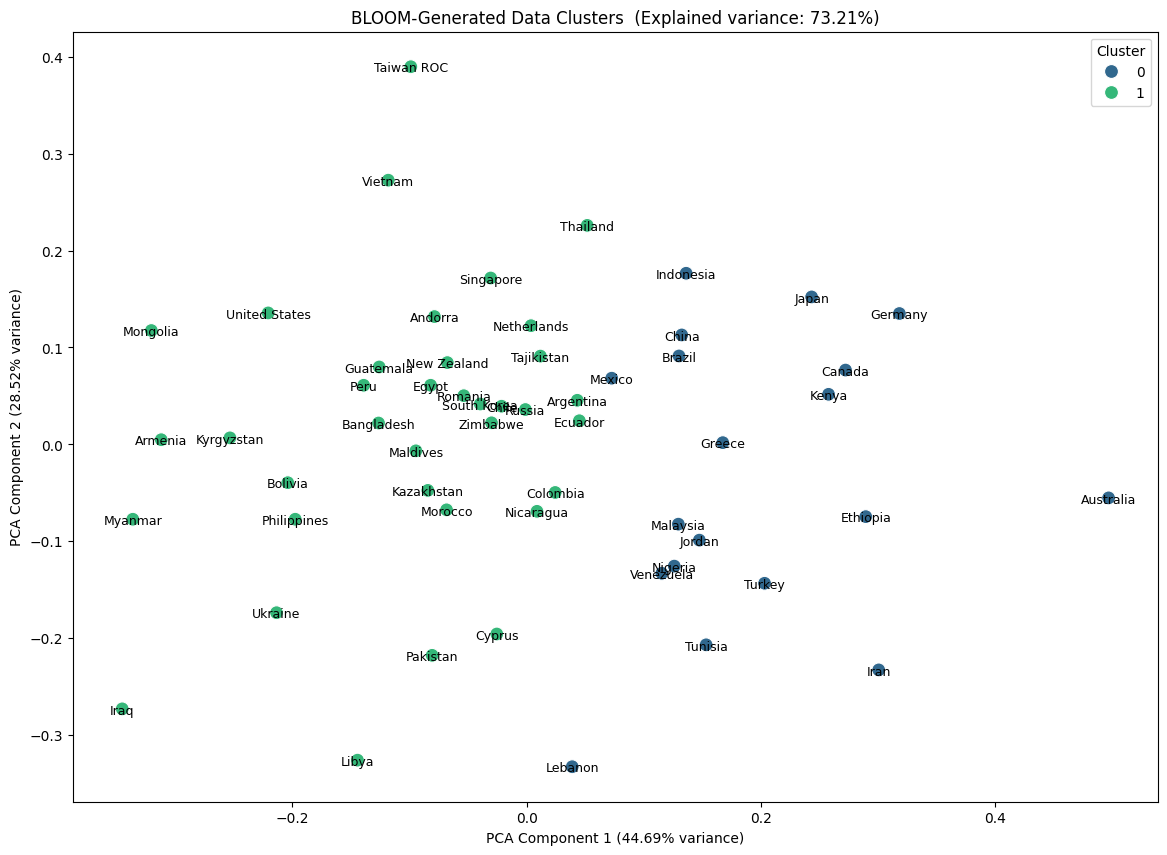

In [ ]:
cluster_and_compare(WVS_preprocessed_df, 'WVS', models)

#### Result 2: most controversial topics

Optimal k for survey data: 2
Optimal number of PCA components: 3


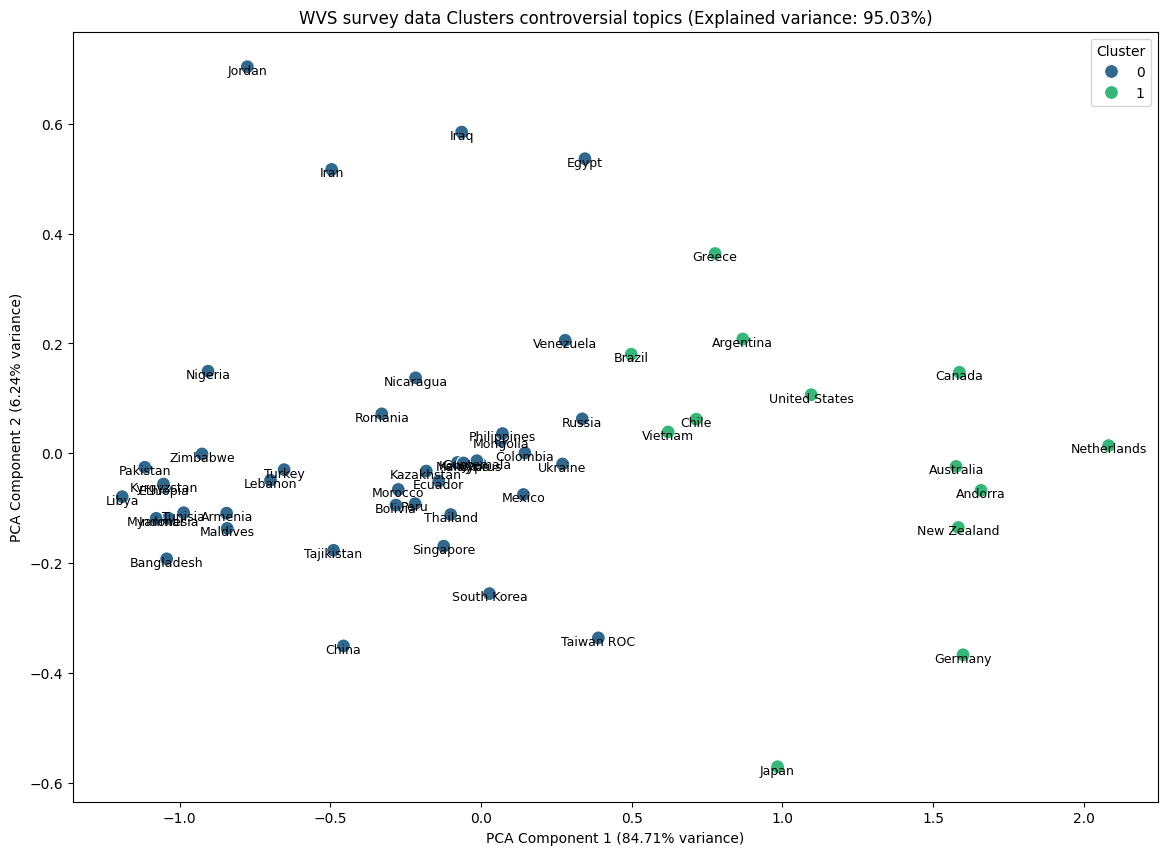

Model: gpt2-medium
Adjusted Rand Index: -0.015
Adjusted Mutual Information: -0.011
Combined Alignment Score: -0.013


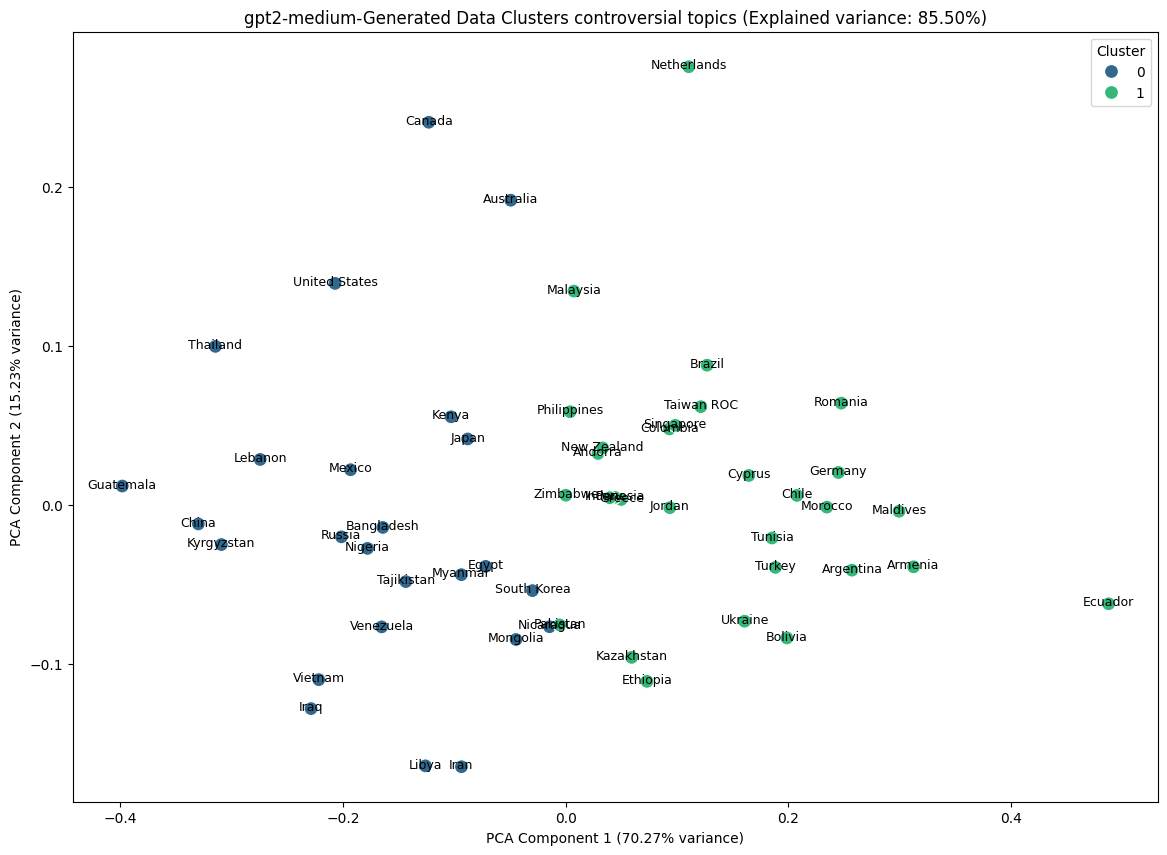

Model: gpt2-large
Adjusted Rand Index: -0.012
Adjusted Mutual Information: 0.023
Combined Alignment Score: 0.005


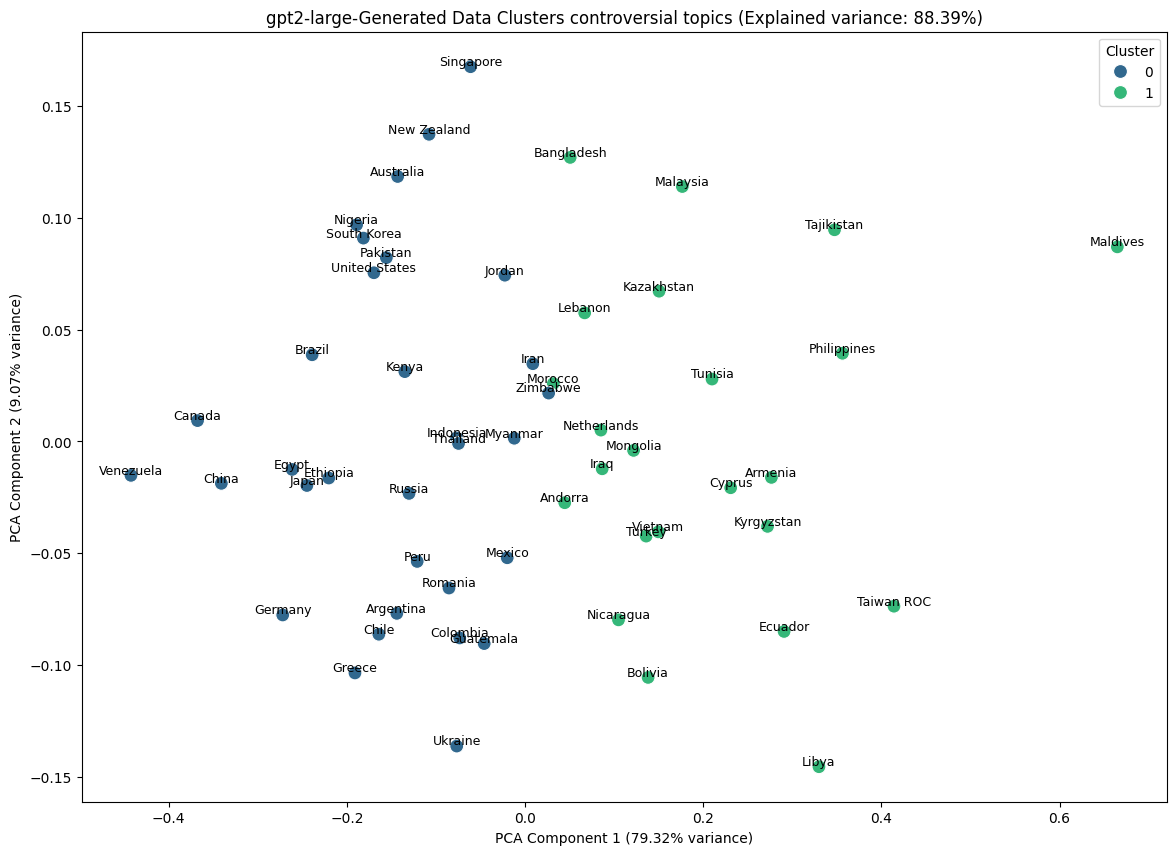

Model: QWEN
Adjusted Rand Index: -0.014
Adjusted Mutual Information: -0.018
Combined Alignment Score: -0.016


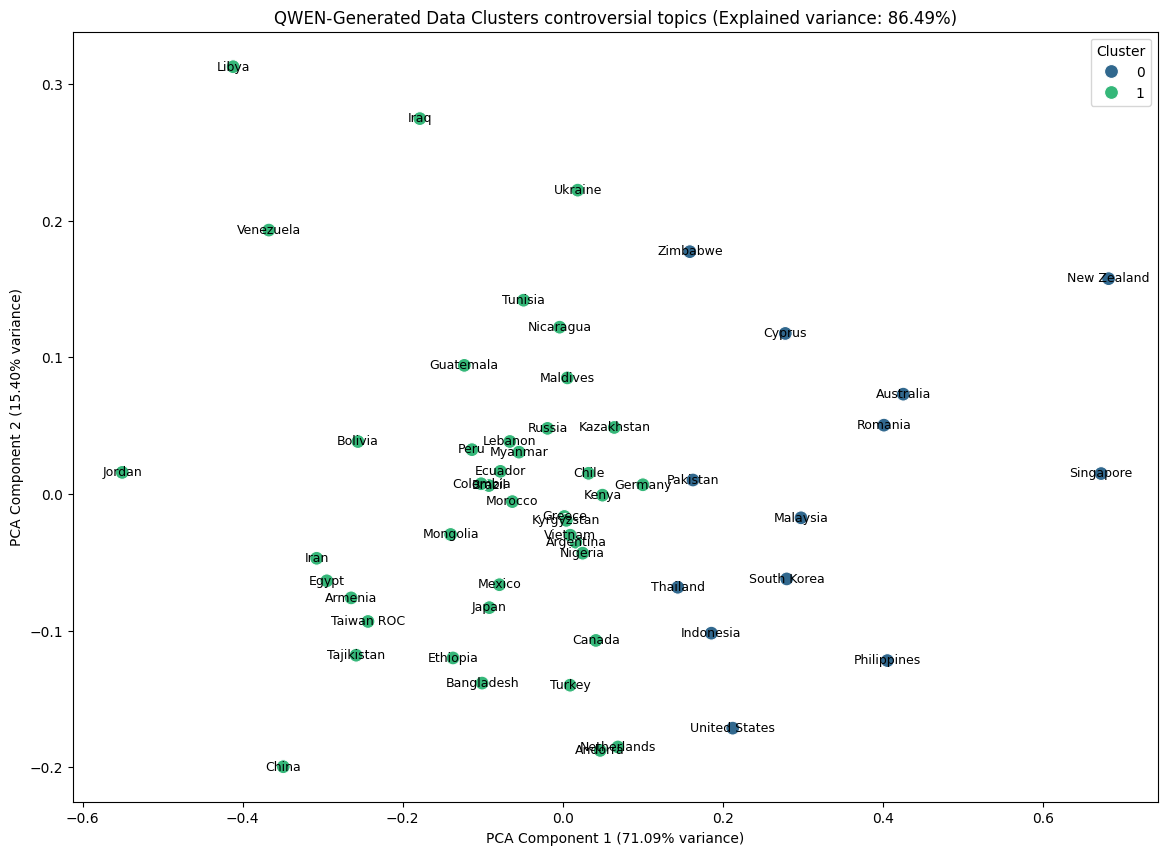

Model: OPT-125
Adjusted Rand Index: -0.021
Adjusted Mutual Information: 0.017
Combined Alignment Score: -0.002


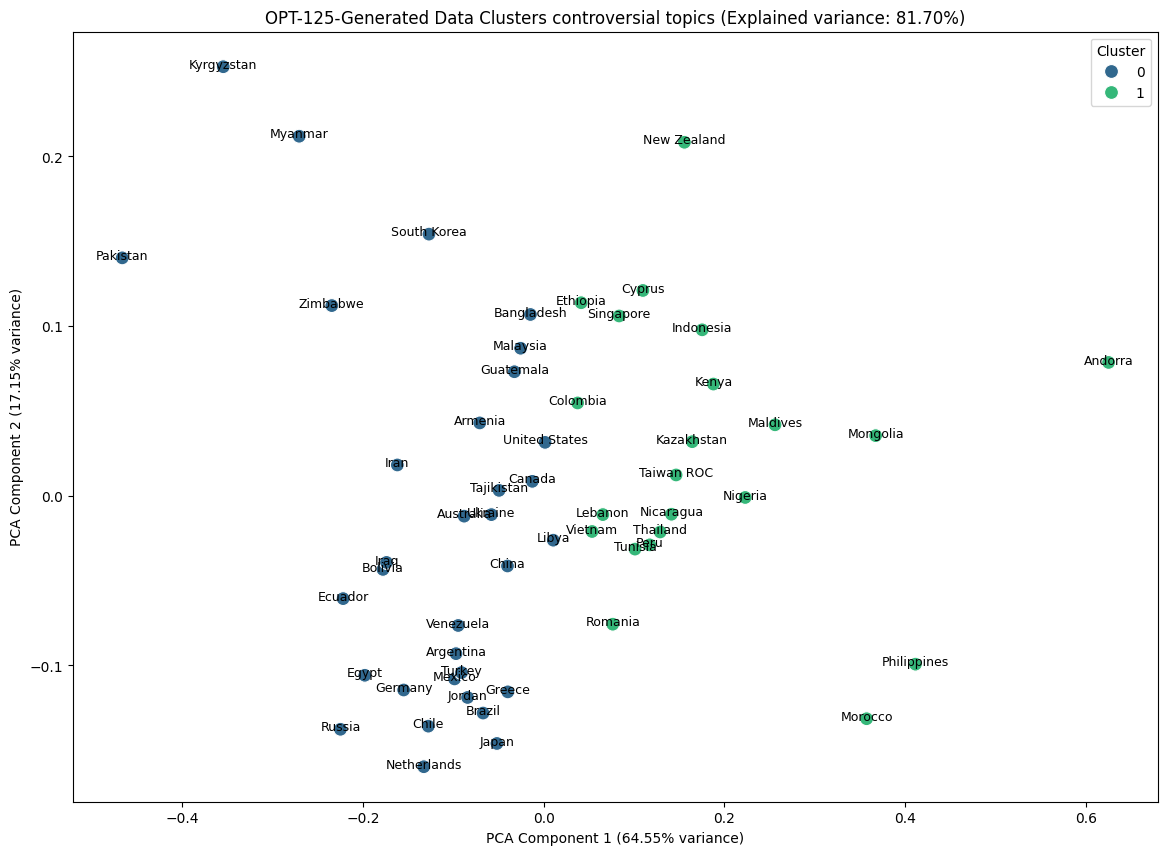

Model: BLOOM
Adjusted Rand Index: -0.015
Adjusted Mutual Information: -0.011
Combined Alignment Score: -0.013


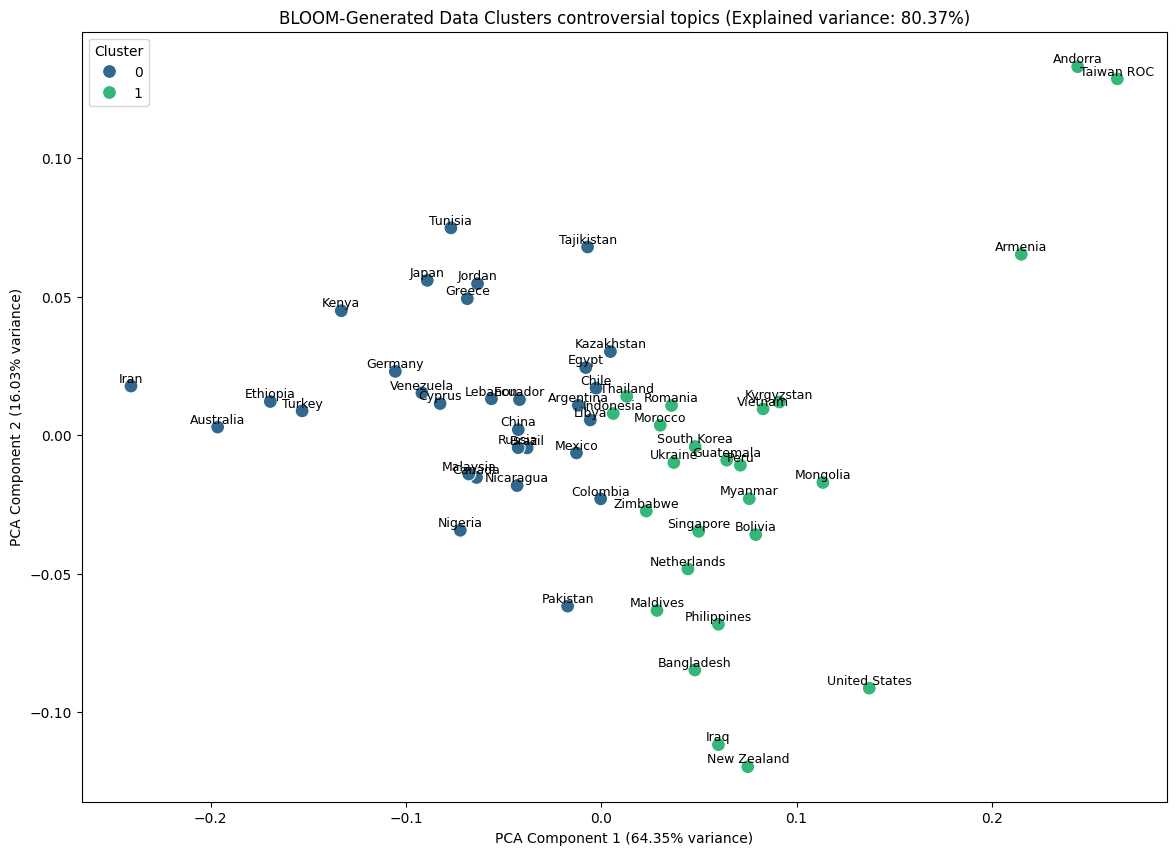

In [ ]:
controversial_topics = list(most_controversial_WVS['topic'])

cluster_and_compare(WVS_preprocessed_df[controversial_topics], 'WVS', models, "controversial topics")

#### Result 3: most agreed on topics

Optimal k for survey data: 2
Optimal number of PCA components: 2


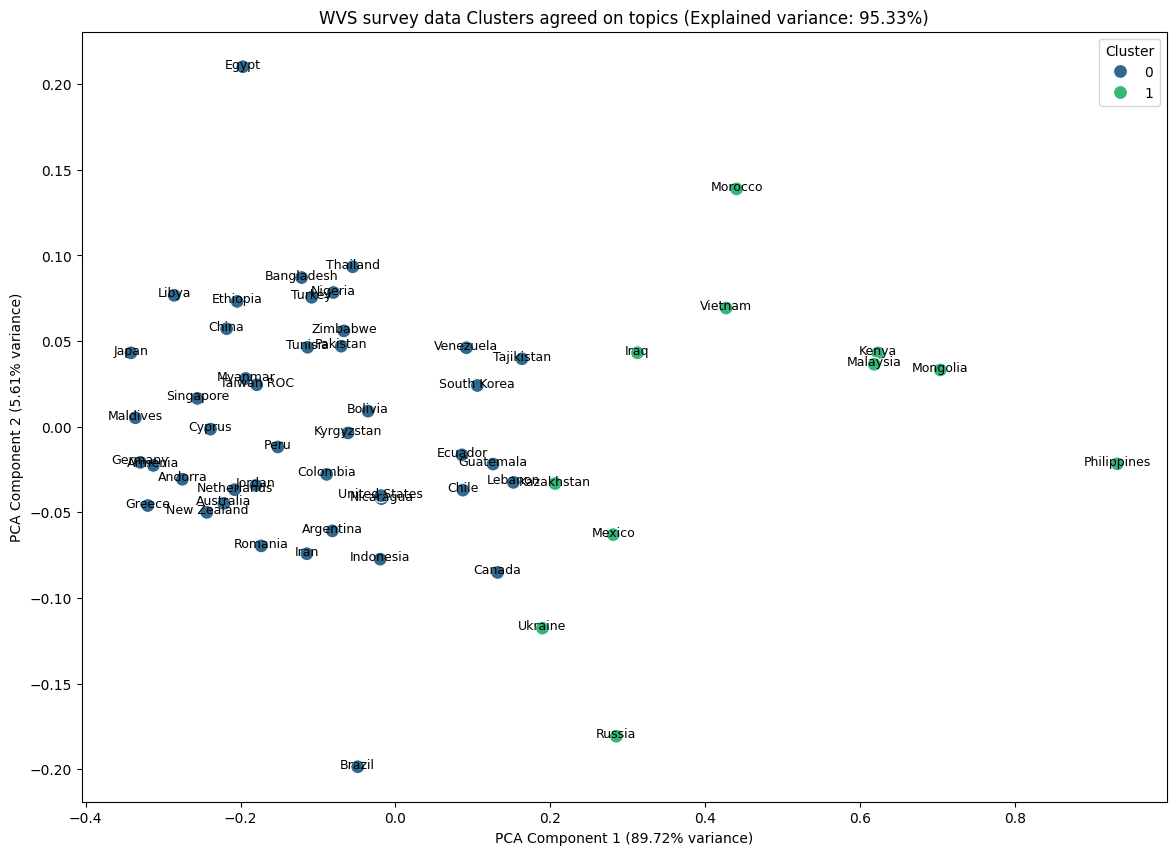

Model: gpt2-medium
Adjusted Rand Index: 0.079
Adjusted Mutual Information: 0.01
Combined Alignment Score: 0.044


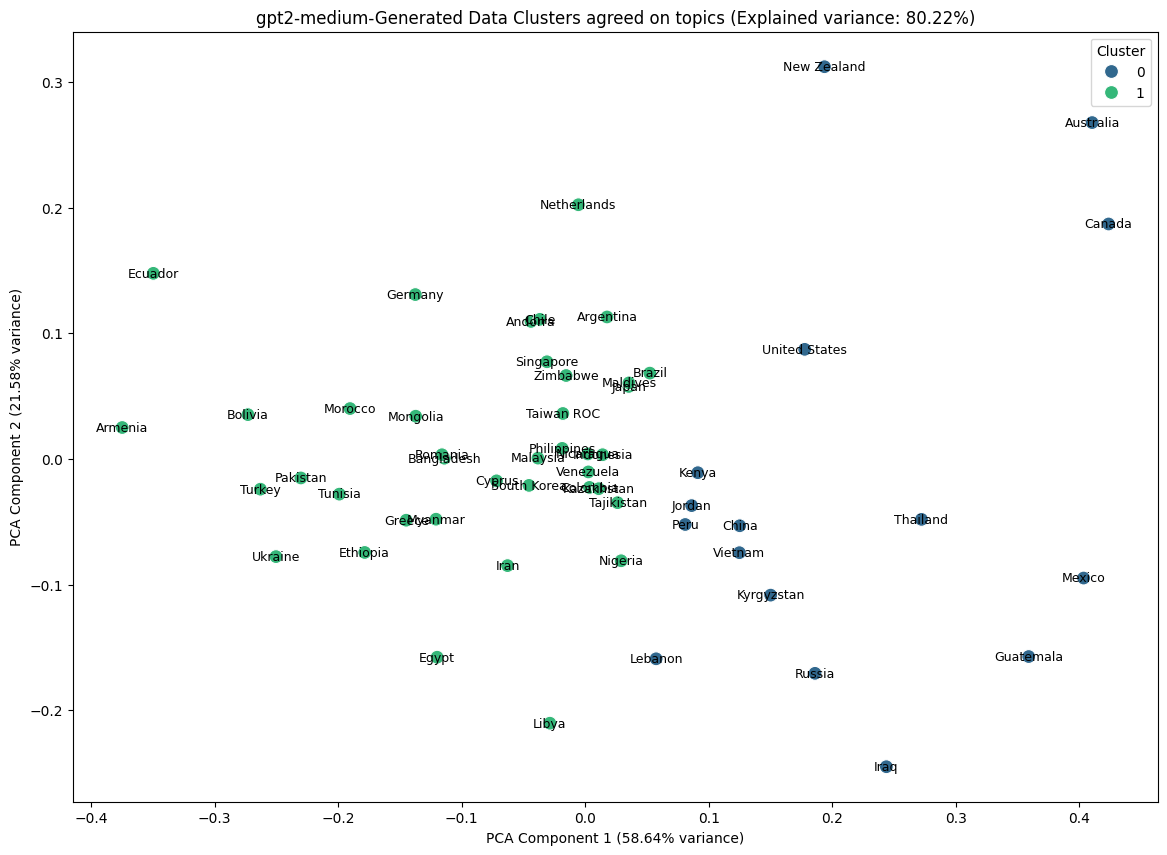

Model: gpt2-large
Adjusted Rand Index: -0.019
Adjusted Mutual Information: -0.014
Combined Alignment Score: -0.016


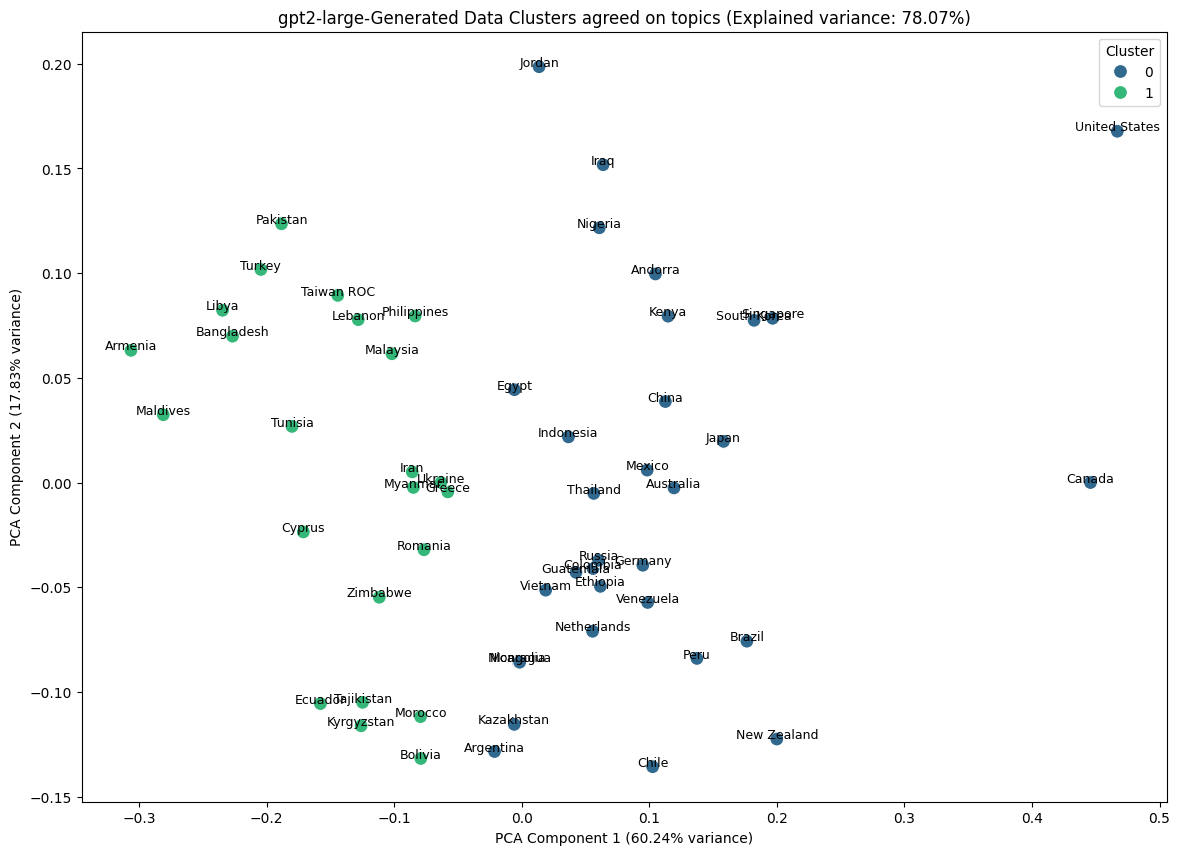

Model: QWEN
Adjusted Rand Index: -0.005
Adjusted Mutual Information: -0.017
Combined Alignment Score: -0.011


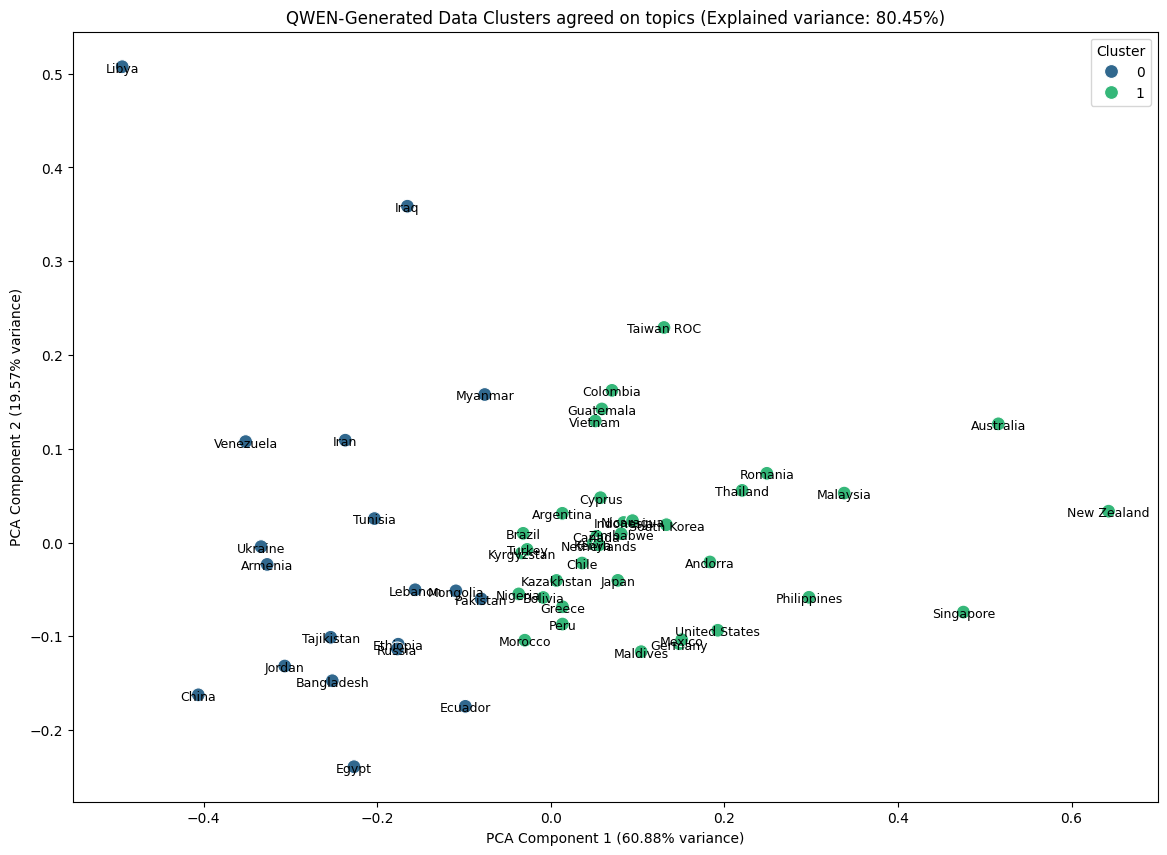

Model: OPT-125
Adjusted Rand Index: 0.12
Adjusted Mutual Information: 0.038
Combined Alignment Score: 0.079


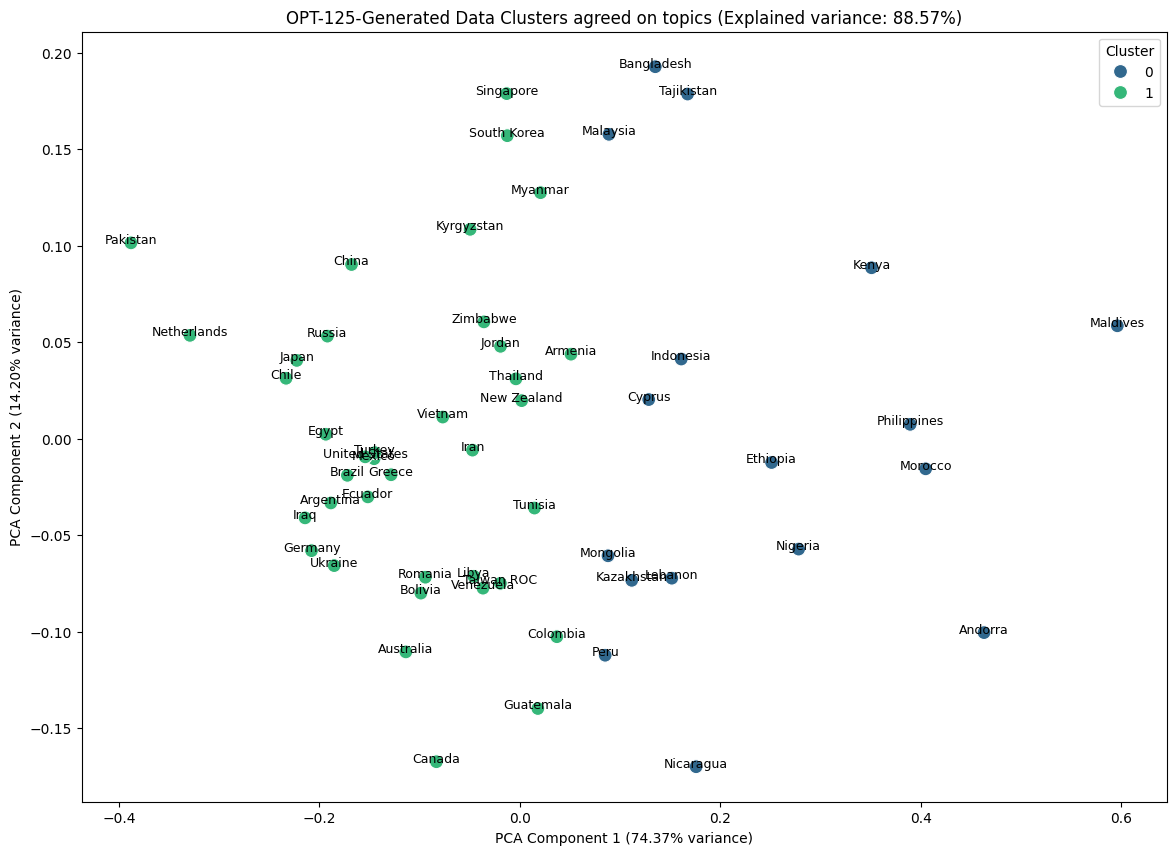

Model: BLOOM
Adjusted Rand Index: -0.03
Adjusted Mutual Information: -0.012
Combined Alignment Score: -0.021


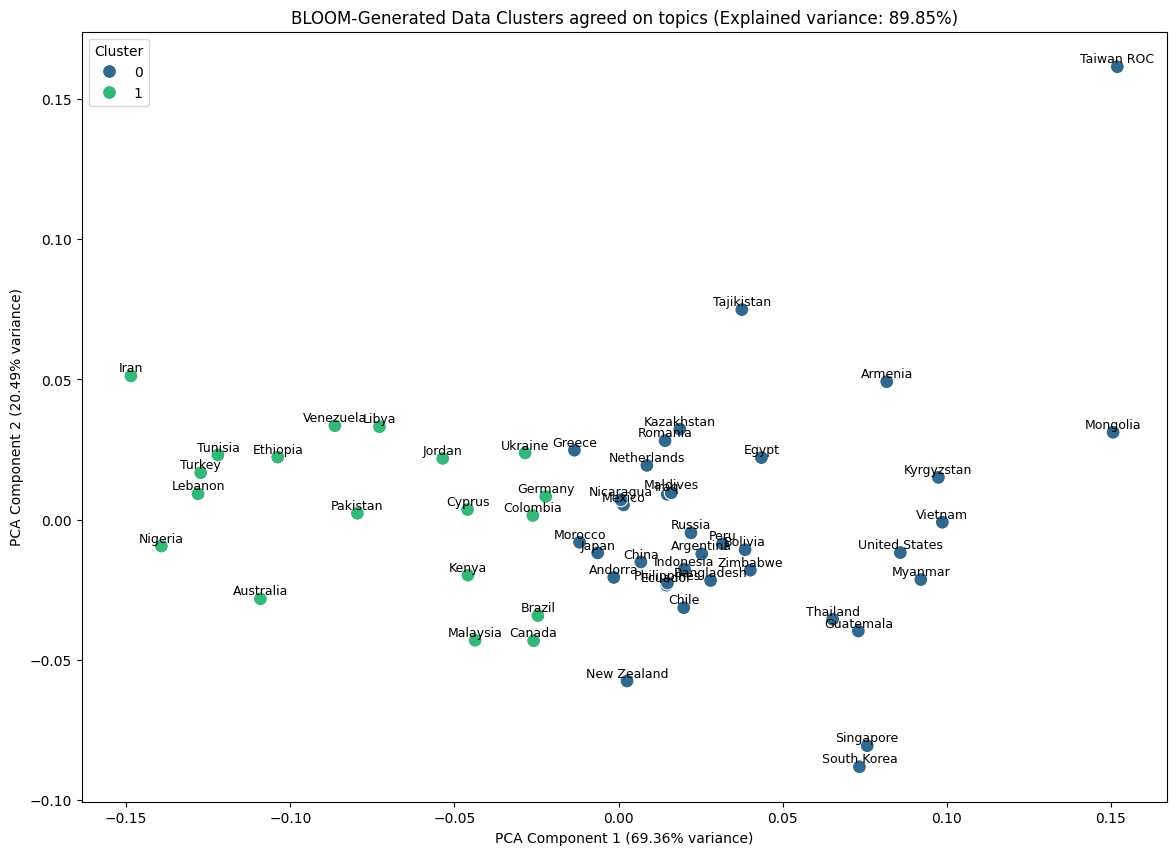

In [ ]:
agreed_topics = list(most_agreed_on_WVS['topic'])

cluster_and_compare(WVS_preprocessed_df[agreed_topics], 'WVS', models, 'agreed on topics')

### PEW

#### Result 1: all topics together

Optimal k for survey data: 2
Optimal number of PCA components: 5


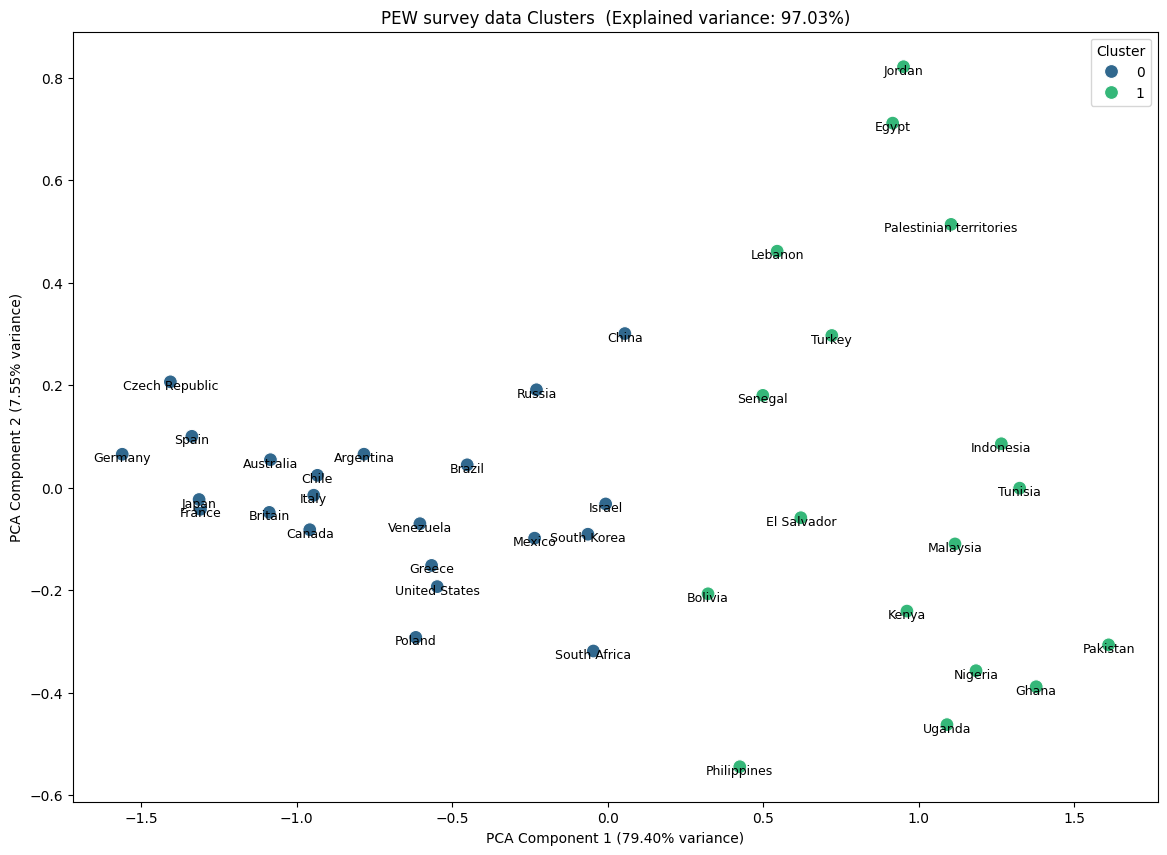

Model: gpt2-medium
Adjusted Rand Index: 0.087
Adjusted Mutual Information: 0.068
Combined Alignment Score: 0.078


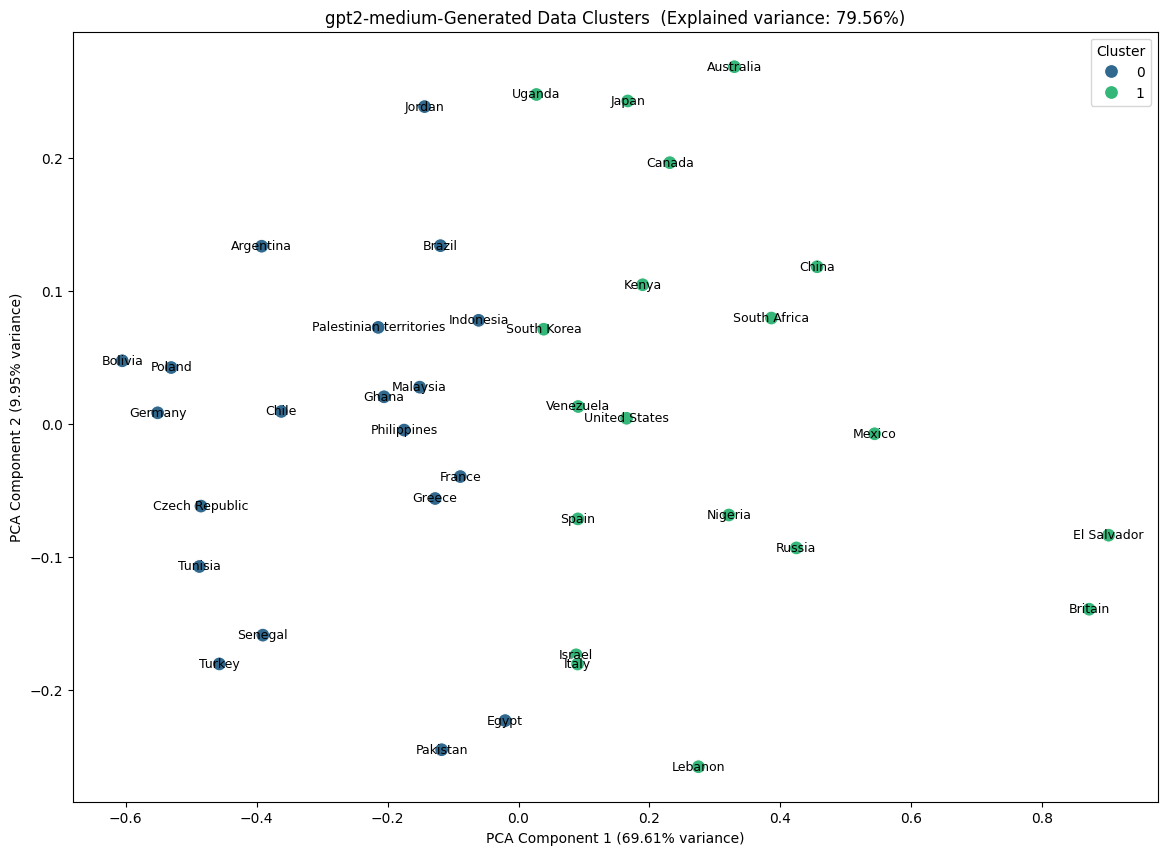

Model: gpt2-large
Adjusted Rand Index: 0.129
Adjusted Mutual Information: 0.123
Combined Alignment Score: 0.126


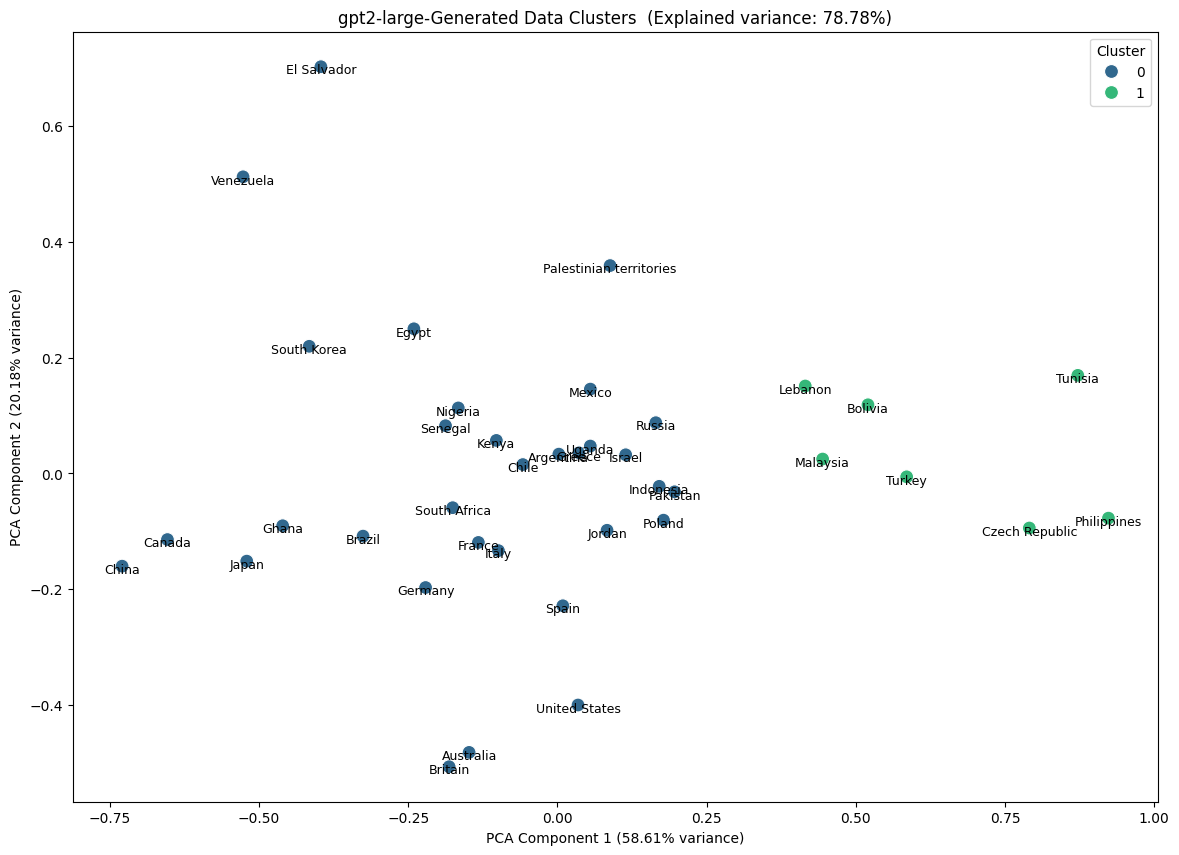

Model: QWEN
Adjusted Rand Index: -0.019
Adjusted Mutual Information: 0.065
Combined Alignment Score: 0.023


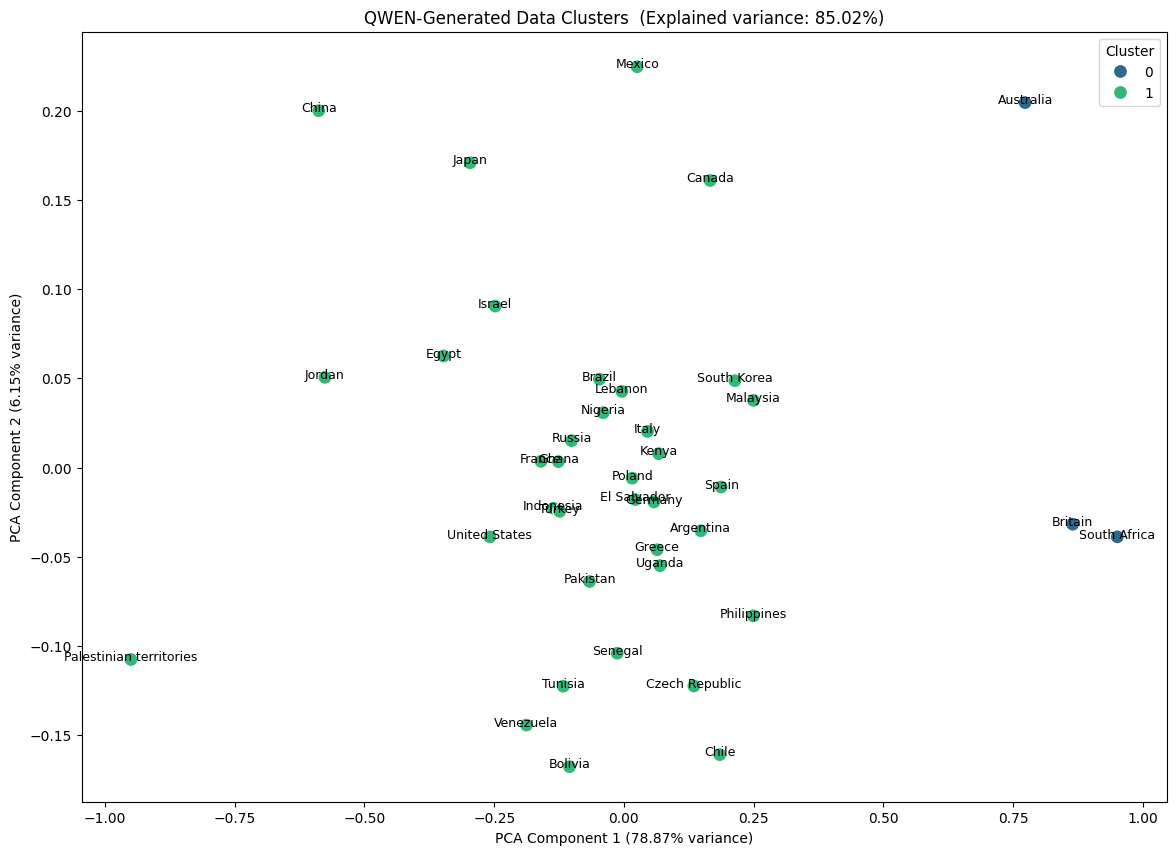

Model: OPT-125
Adjusted Rand Index: 0.129
Adjusted Mutual Information: 0.123
Combined Alignment Score: 0.126


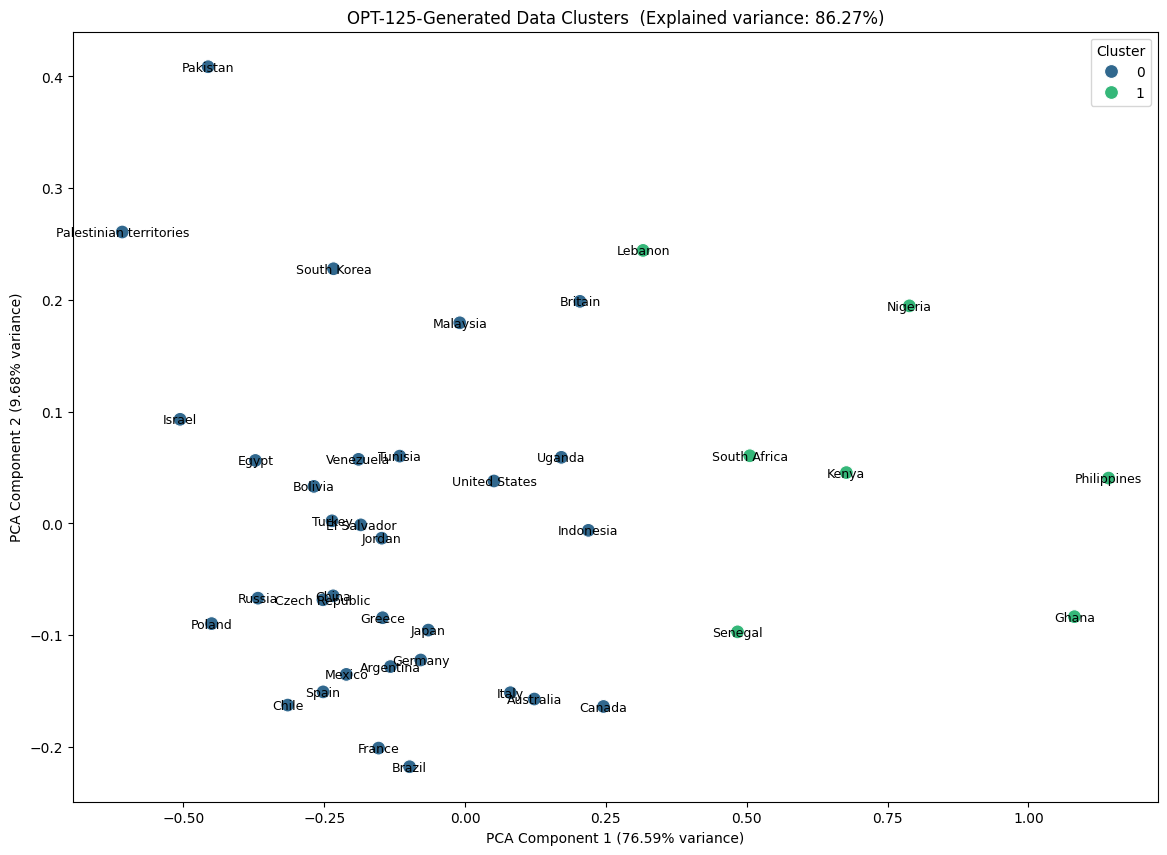

Model: BLOOM
Adjusted Rand Index: 0.008
Adjusted Mutual Information: -0.004
Combined Alignment Score: 0.002


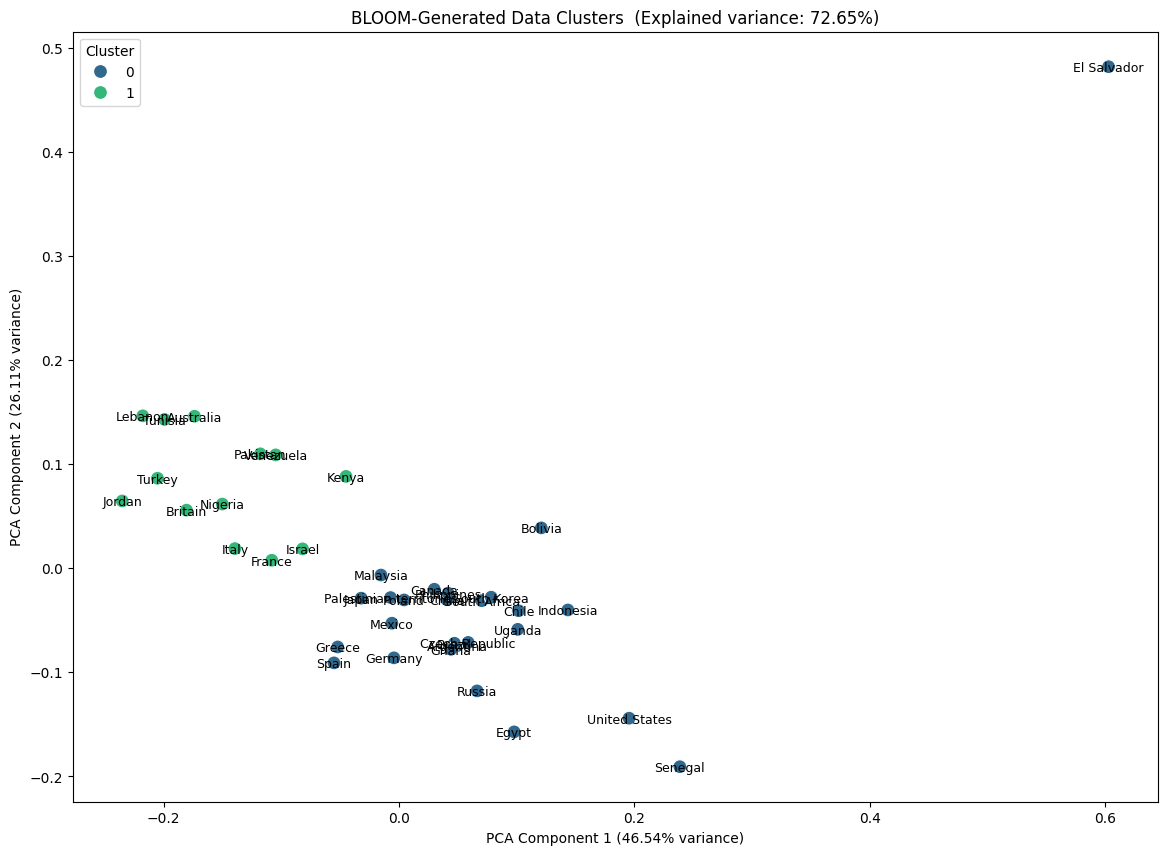

In [ ]:
cluster_and_compare(PEW_preprocessed_df, 'PEW', models)

#### Result 2: most controversial topics

Optimal k for survey data: 2
Optimal number of PCA components: 2


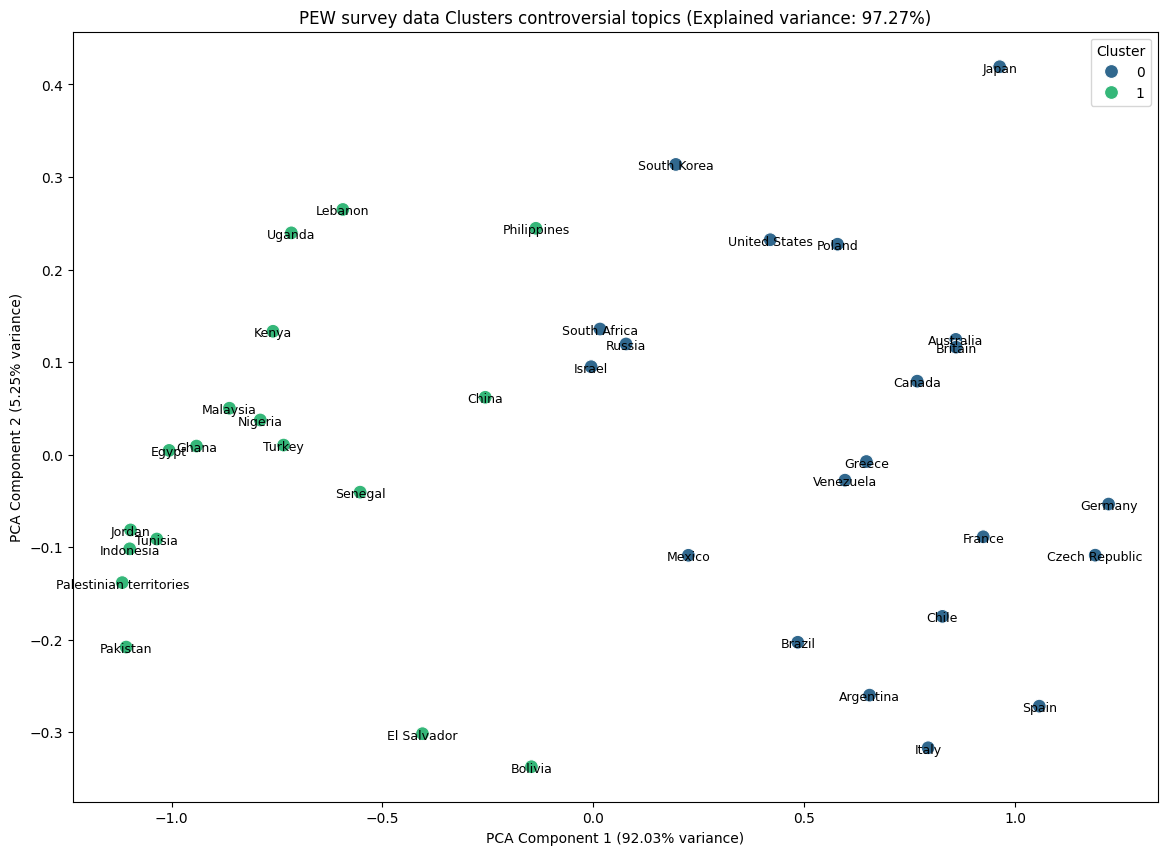

Model: gpt2-medium
Adjusted Rand Index: -0.026
Adjusted Mutual Information: -0.019
Combined Alignment Score: -0.022


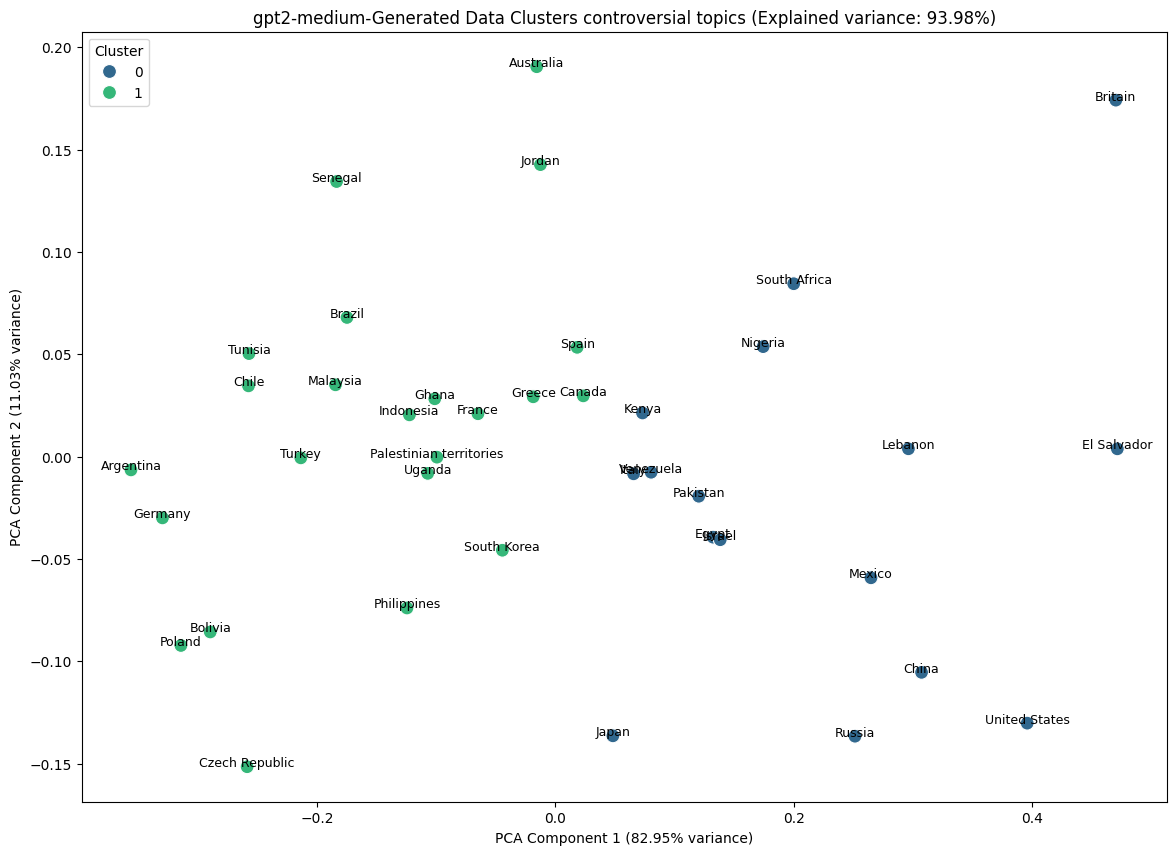

Model: gpt2-large
Adjusted Rand Index: 0.093
Adjusted Mutual Information: 0.081
Combined Alignment Score: 0.087


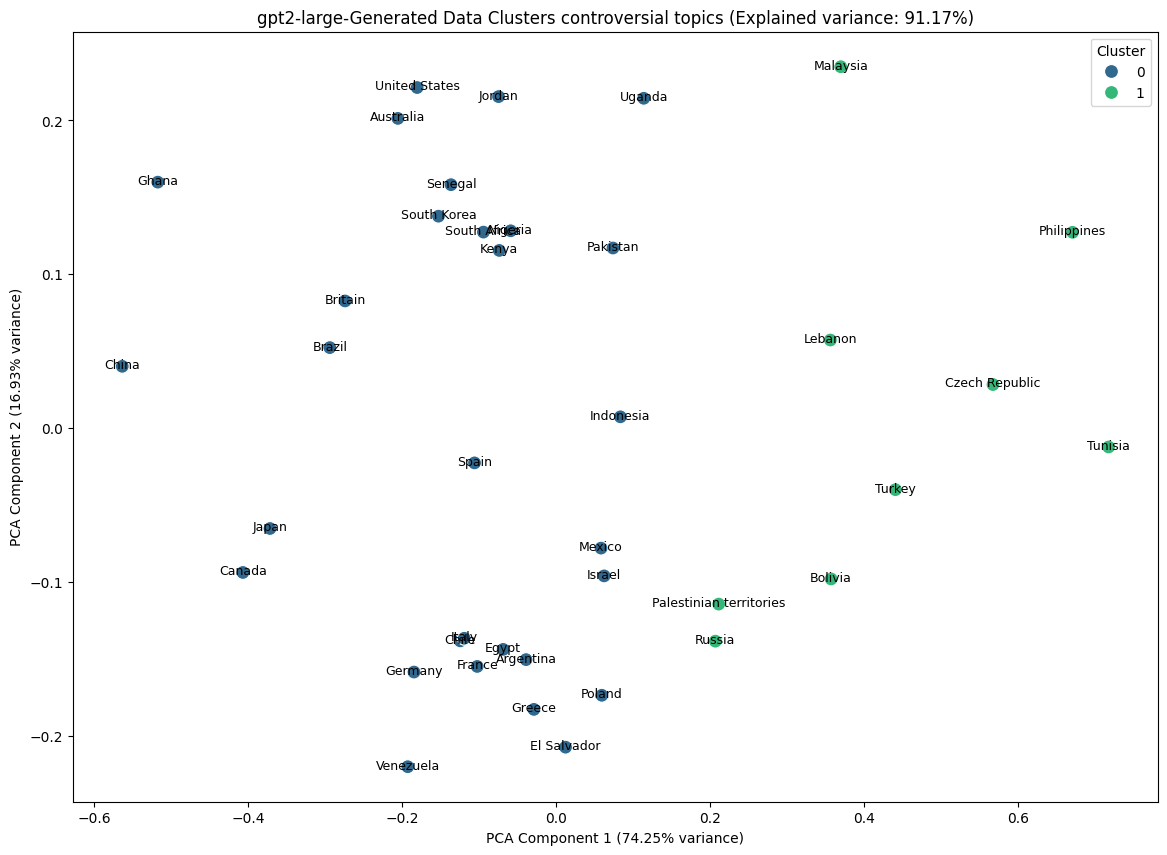

Model: QWEN
Adjusted Rand Index: -0.006
Adjusted Mutual Information: 0.073
Combined Alignment Score: 0.033


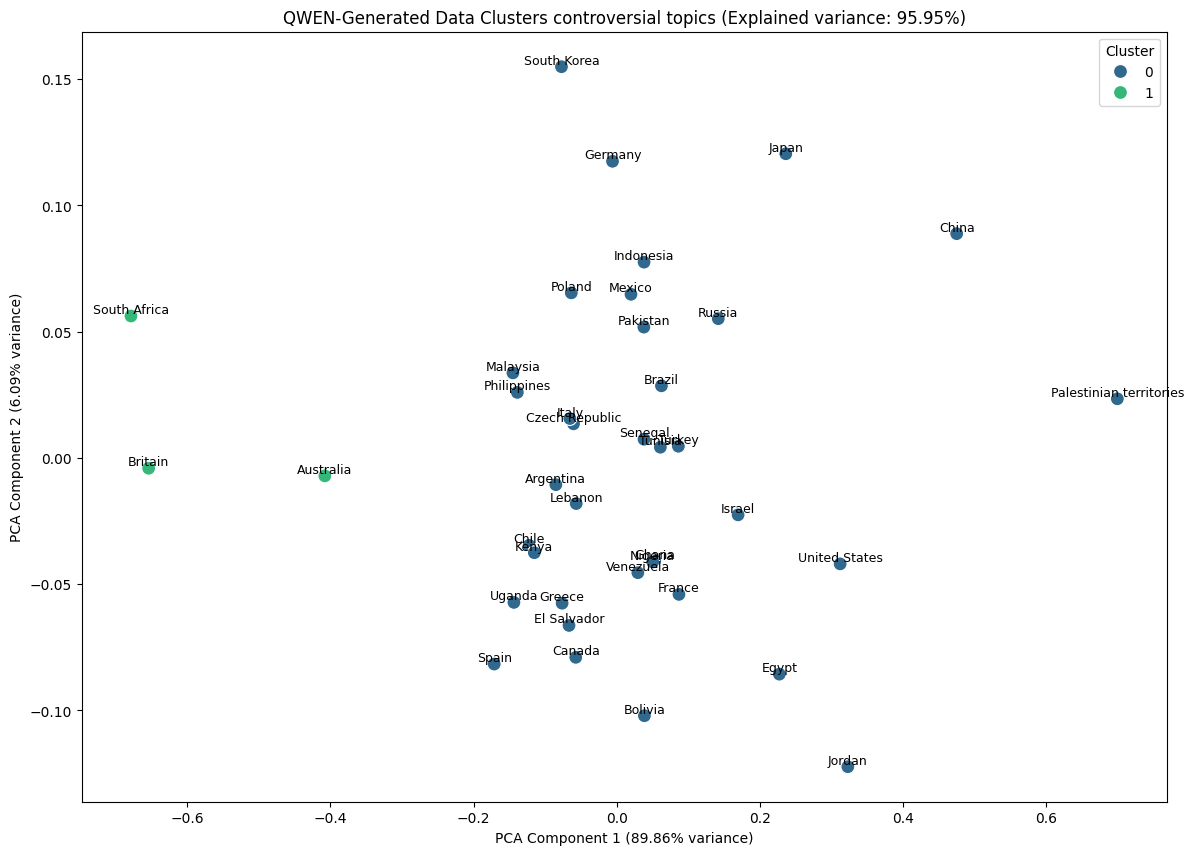

Model: OPT-125
Adjusted Rand Index: 0.131
Adjusted Mutual Information: 0.14
Combined Alignment Score: 0.136


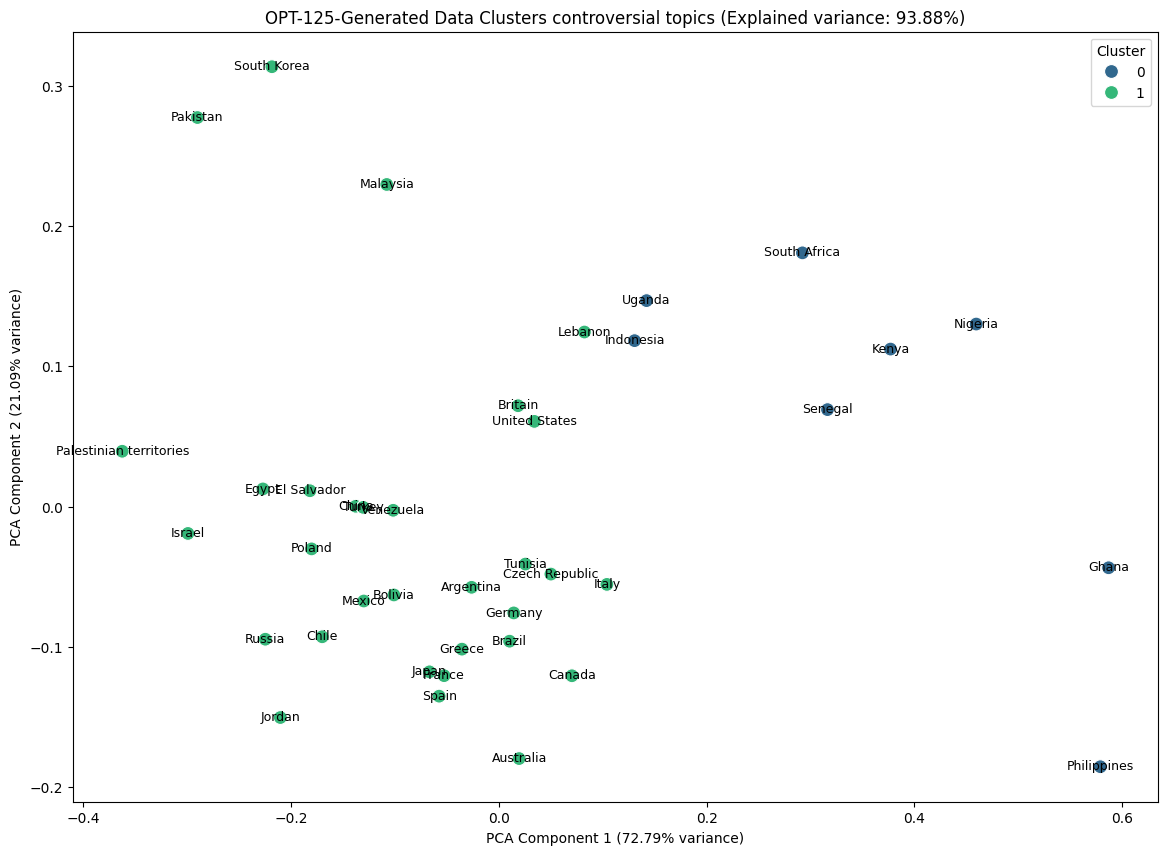

Model: BLOOM
Adjusted Rand Index: 0.009
Adjusted Mutual Information: 0.006
Combined Alignment Score: 0.007


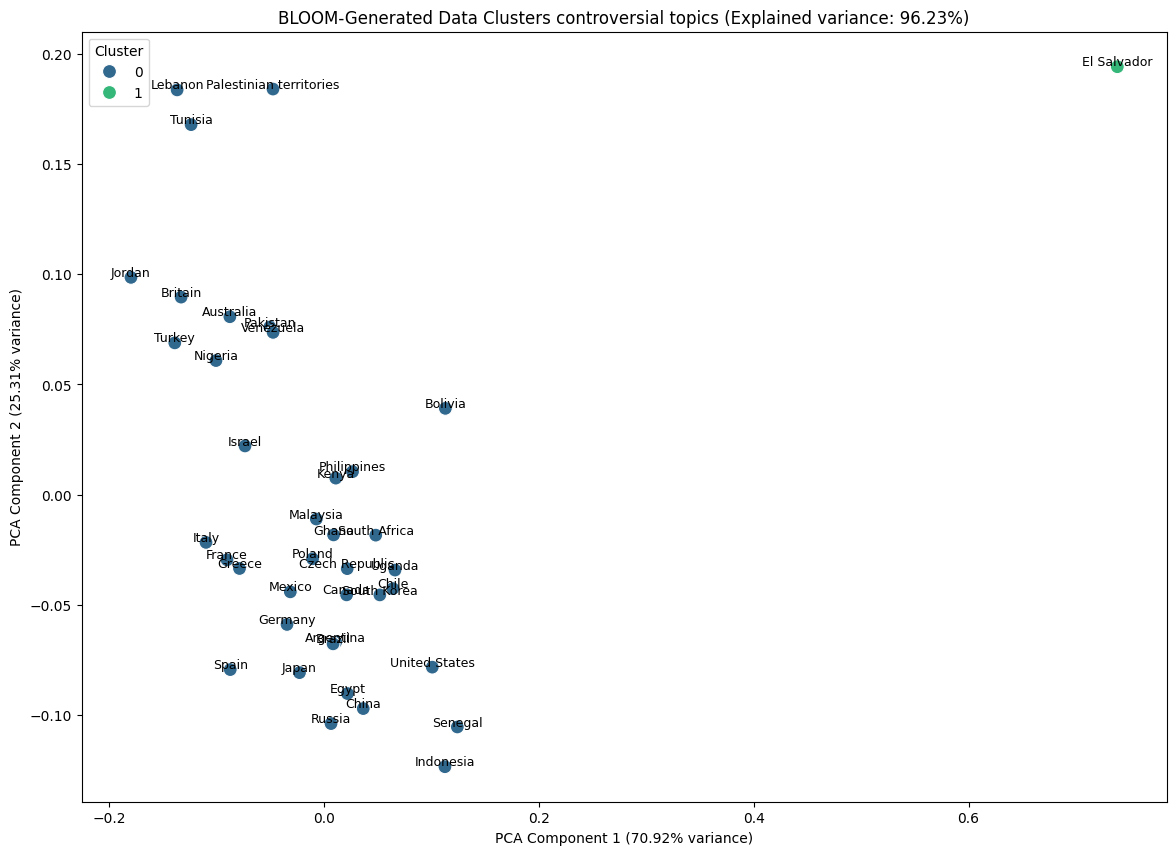

In [ ]:
controversial_topics = list(most_controversial_PEW['topic'])

cluster_and_compare(PEW_preprocessed_df[controversial_topics], 'PEW', models, "controversial topics")

#### Result 3: most agreed on topics

Optimal k for survey data: 2
Optimal number of PCA components: 2


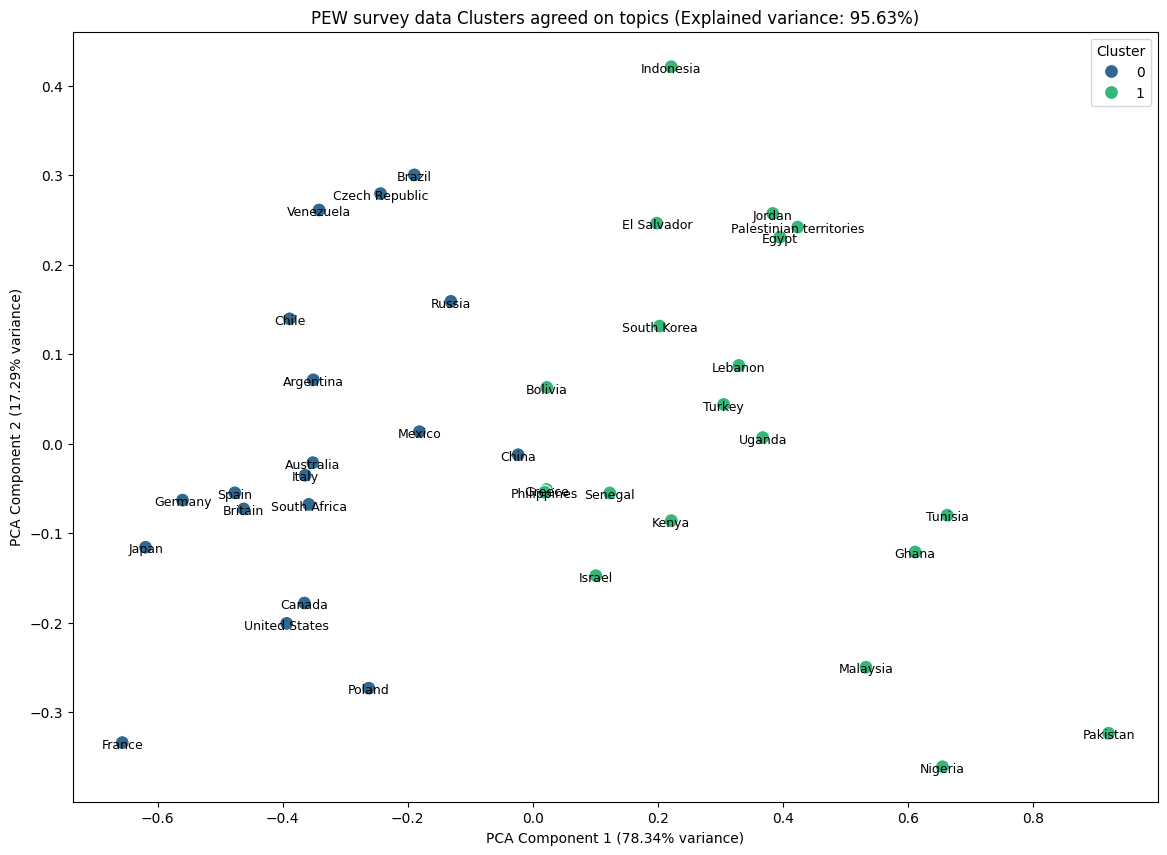

Model: gpt2-medium
Adjusted Rand Index: 0.057
Adjusted Mutual Information: 0.045
Combined Alignment Score: 0.051


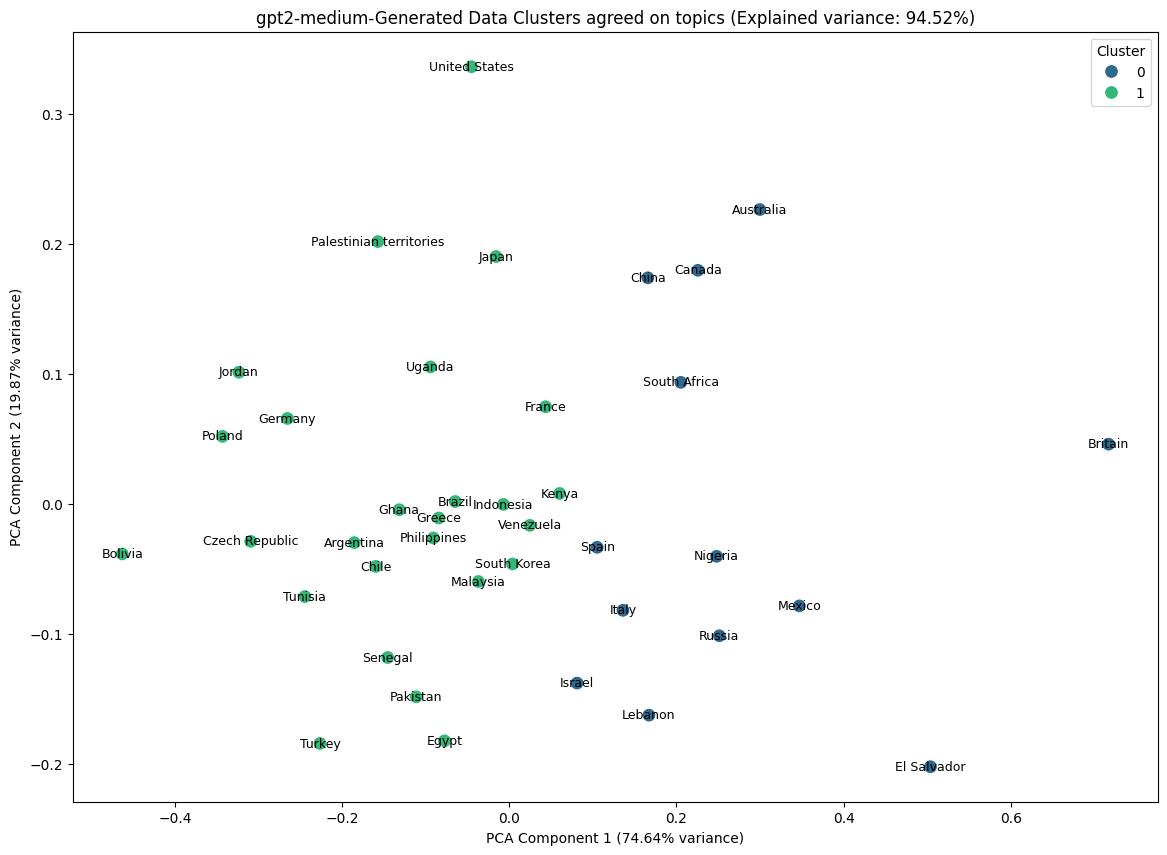

Model: gpt2-large
Adjusted Rand Index: 0.028
Adjusted Mutual Information: 0.02
Combined Alignment Score: 0.024


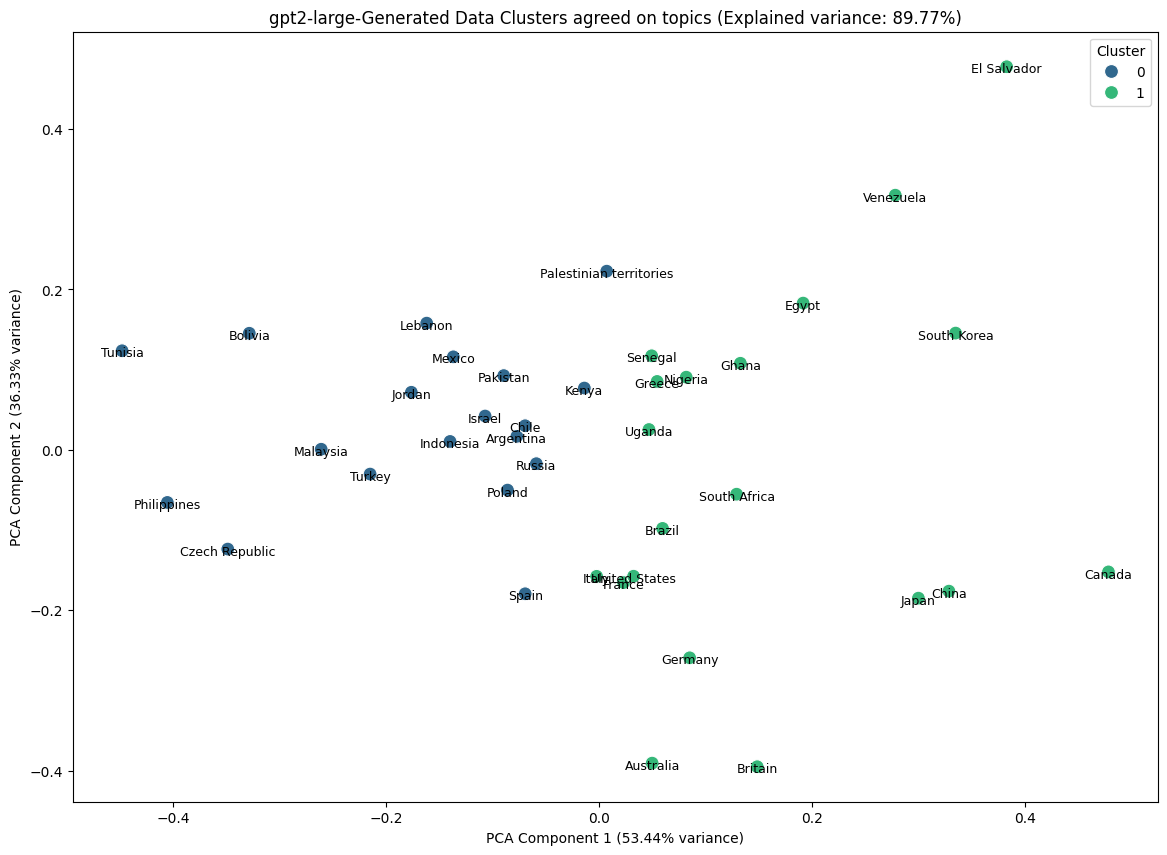

Model: QWEN
Adjusted Rand Index: -0.02
Adjusted Mutual Information: -0.016
Combined Alignment Score: -0.018


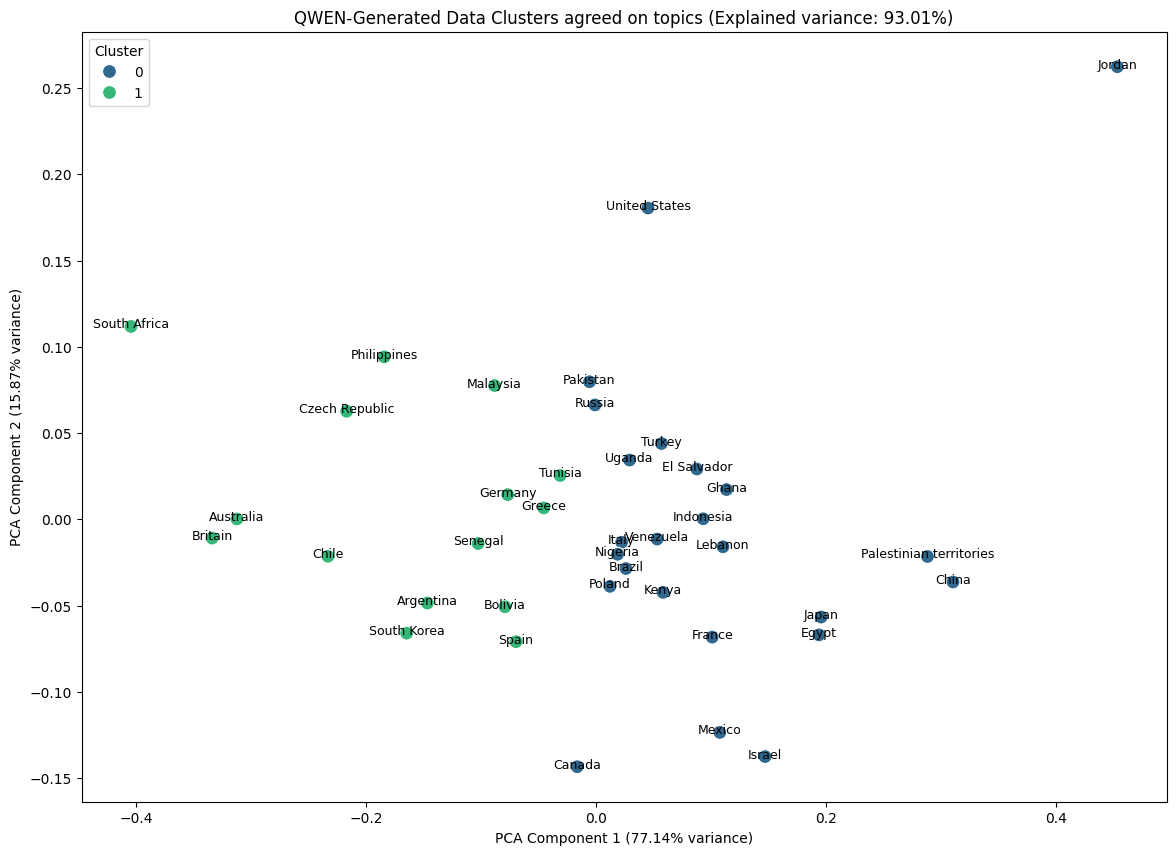

Model: OPT-125
Adjusted Rand Index: 0.035
Adjusted Mutual Information: 0.051
Combined Alignment Score: 0.043


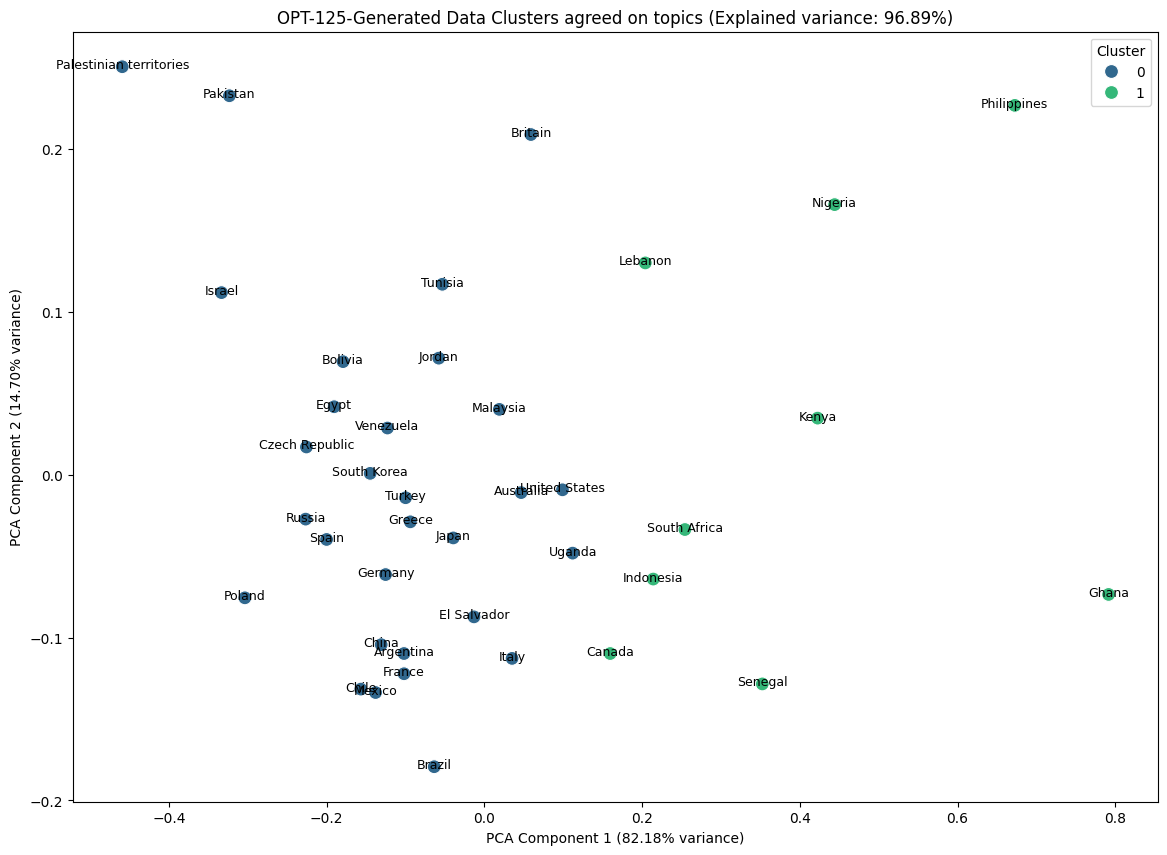

Model: BLOOM
Adjusted Rand Index: 0.006
Adjusted Mutual Information: 0.004
Combined Alignment Score: 0.005


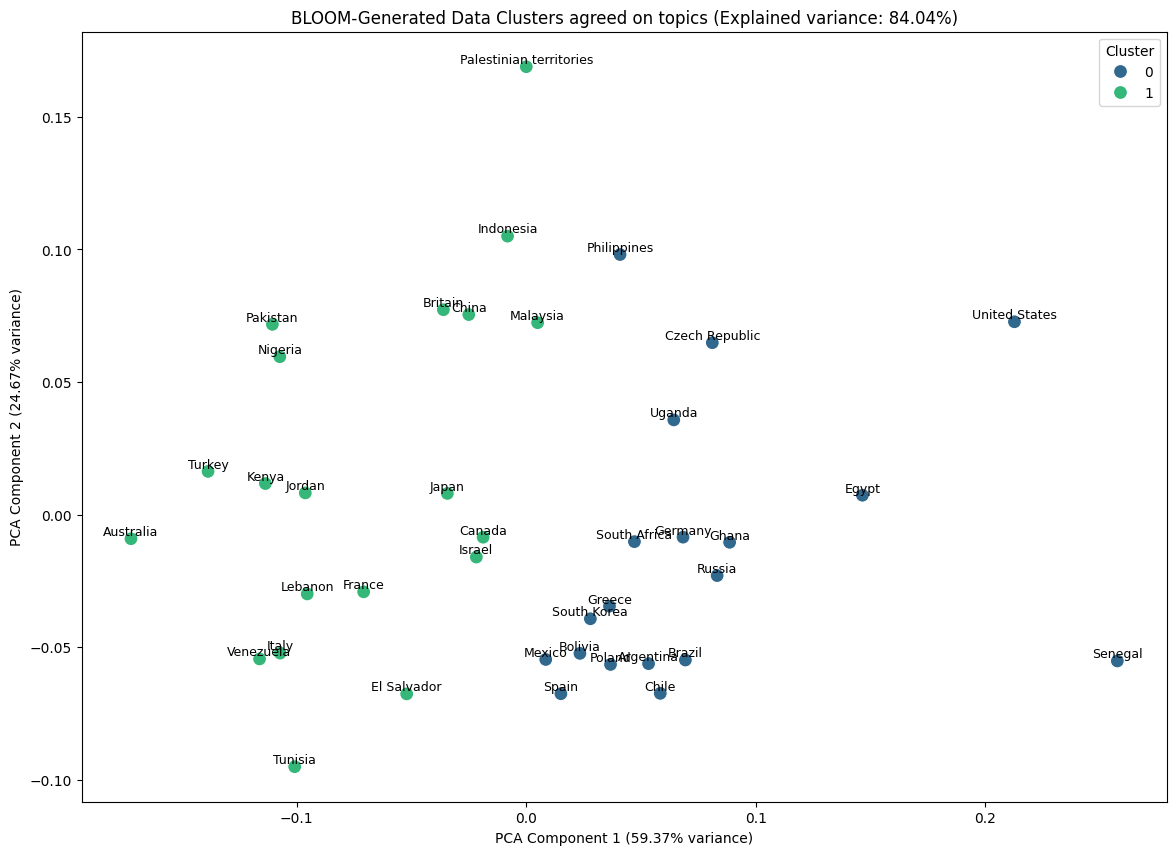

In [ ]:
agreed_topics = list(most_agreed_on_PEW['topic'])

cluster_and_compare(PEW_preprocessed_df[agreed_topics], 'PEW', models, 'agreed on topics')

### Conclusion




* #TODO: Look at the scores of adjusted rand index & mutual information and conclude whether the model clusters align with the WVS survey value clusters.

* Maybe make a df to summarize results.

## Part 3. Probing the model directly on similarities/differences between stances on topics

### Defining functions

#### Finding cluster per topic

In [ ]:
# improved functie met elbow method geïntegreerd

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from kneed import KneeLocator

def calculate_wcss(data, clusters):
    """Calculate within-cluster sum of squares for hierarchical clustering."""
    wcss = []
    for cluster in np.unique(clusters):
        cluster_points = data[clusters == cluster]
        centroid = np.mean(cluster_points, axis=0)
        wcss.append(np.sum((cluster_points - centroid) ** 2))
    return np.sum(wcss)

def find_clusters_per_topic(preprocessed_df, topic):
    topic_df = preprocessed_df[[topic]]

    # Convert the df to a 2D array for clustering
    data_array = topic_df.values

    # Hierarchical clustering
    Z = linkage(data_array, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(12, 4))
    dendrogram(Z, labels=topic_df.index.to_list(), leaf_rotation=90, leaf_font_size=10)
    plt.title(f'Hierarchical Clustering Dendrogram for moral scores on {topic}')
    plt.xlabel('Country')
    plt.ylabel('Distance')
    plt.show()

    # Use the elbow method to find the optimal number of clusters
    max_clusters = 10
    wcss = []
    for i in range(1, max_clusters + 1):
        clusters = fcluster(Z, i, criterion='maxclust')
        wcss.append(calculate_wcss(data_array, clusters))

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title('Elbow Method for Optimal Number of Clusters (Hierarchical)')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Automatically find the elbow point
    kl = KneeLocator(range(1, max_clusters + 1), wcss, curve='convex', direction='decreasing')
    optimal_clusters = kl.elbow

    if optimal_clusters is None:
        optimal_clusters = 2  # Default to 2 if no clear elbow is found
        print("No clear elbow found. Defaulting to 2 clusters.")
    else:
        print(f"Optimal number of clusters: {optimal_clusters}")

    # Apply hierarchical clustering with the optimal number of clusters
    clusters = fcluster(Z, optimal_clusters, criterion='maxclust')

    # Create df to show which country belongs to which cluster
    cluster_df = pd.DataFrame({'Country': topic_df.index, f'Cluster opinion on {topic}': clusters})

    # Add averages for clusters to estimate their moral attitude on the topic
    cluster_averages = topic_df.groupby(clusters).mean()
    cluster_df = cluster_df.merge(cluster_averages, left_on=f'Cluster opinion on {topic}', right_index=True, suffixes=('', '_avg'))

    return cluster_df, cluster_averages

# Example usage
# WVS_preprocessed_df should be your preprocessed DataFrame
# cluster_df = find_clusters_per_topic('some_topic')

# TODO: add averages for clusters so that we can estimate their moral attitude on the topic and get a better understanding of the clusters

#### Generating prompts per topic and the clusters for that topic

In [ ]:
#### ***** VERSION WITH RANDOM TRIAL CLUSTER REPRESENTATIVES ***** ####

import random
import itertools

def generate_topic_prompts(topic, topic_clusters, cluster_averages):
    intra_cluster_prompts = []
    inter_cluster_prompts = []

    # Step 1: Calculate differences between clusters based on their averages
    cluster_pairs = list(itertools.combinations(cluster_averages.index, 2))
    differences = [(pair, abs(cluster_averages.loc[pair[0]] - cluster_averages.loc[pair[1]]).values[0]) for pair in cluster_pairs]

    # Sort differences by absolute value in descending order
    sorted_pairs = sorted(differences, key=lambda x: x[1], reverse=True)

    # Take the pair with the maximum difference
    most_different_pair, max_difference = sorted_pairs[0]

    # Extract the two clusters involved in the most different pair
    most_different_clusters = list(most_different_pair)

    # if we want to print out the moral score averages for the most different clusters:
    average_cluster1 = cluster_averages.loc[most_different_clusters[0], topic]
    average_cluster2 = cluster_averages.loc[most_different_clusters[1], topic]

    # N.B.: cluster_averages column that displays cluster numbers is called 'topic' due to reason in function above... be aware!
    print(f"Average moral score for {topic} for first cluster: {round(average_cluster1, 3)}")
    print(f"Average moral score for {topic} for second cluster: {round(average_cluster2, 3)}")

    # Step 2: Generate prompts for intra-cluster comparisons within the most different clusters
    representatives = {}

    for cluster in most_different_clusters:
        cluster_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == cluster]
        countries = cluster_data['Country'].tolist()

        # Choose two random representatives from each cluster
        if len(countries) >= 2:
            representative_pair = random.sample(countries, 2)
            representatives[cluster] = representative_pair

    # Generate intra-cluster prompts
    prompt_formats = [
        #[f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."]#,
        [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
        [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."]
        #[f"On the topic of {topic}, the moral judgments of people in {{}} and {{}} are the same.", f"On the topic of {topic}, the moral judgments of people in {{}} and {{}} are different."]#,
        #[f"Regarding the morality of {topic}, the opinions of people in {{}} and {{}} are in agreement.", f"Regarding the morality of {topic}, the opinions of people in {{}} and {{}} are in disagreement."]
    ]
    for cluster, countries in representatives.items():
        for format_pair in prompt_formats:
            prompt = [format_pair[0].format(countries[0], countries[1]), format_pair[1].format(countries[0], countries[1])]
            intra_cluster_prompts.append(prompt)

    # Step 3: Generate prompts for inter-cluster comparisons between the most different clusters
    if len(representatives) == len(most_different_clusters) == 2:
        cluster1, cluster2 = most_different_clusters
        countries1 = representatives[cluster1]
        countries2 = representatives[cluster2]

        # Generate inter-cluster prompts
        prompt_formats = [
          #[f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."]#,
          [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
          [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."]
          #[f"On the topic of {topic}, the moral judgments of people in {{}} and {{}} are the same.", f"On the topic of {topic}, the moral judgments of people in {{}} and {{}} are different."]#,
          #[f"Regarding the morality of {topic}, the opinions of people in {{}} and {{}} are in agreement.", f"Regarding the morality of {topic}, the opinions of people in {{}} and {{}} are in disagreement."]

        ]
        for format_pair in prompt_formats:
            prompt1 = [format_pair[0].format(countries1[0], countries2[0]), format_pair[1].format(countries1[0], countries2[0])]
            prompt2 = [format_pair[0].format(countries1[1], countries2[1]), format_pair[1].format(countries1[1], countries2[1])]
            inter_cluster_prompts.extend([prompt1, prompt2])

    return intra_cluster_prompts, inter_cluster_prompts

# # Call the function with your specific topic and data
# sex_before_marriage_prompts = generate_topic_prompts('sex before marriage', sex_before_marriage_clusters_df, cluster_averages_df)

# # Print the prompts
# for prompt in sex_before_marriage_prompts[0]:  # Print intra-cluster prompts
#     print(prompt)
# for prompt in sex_before_marriage_prompts[1]:  # Print inter-cluster prompts
#     print(prompt)



# #### ****** VERSION EXHAUSTIVELY GOING OVER ALL POSSIBLE INTRA- AND INTERCLUSTER COMBINATIONS ****** ####

# def generate_topic_prompts(topic, topic_clusters, cluster_averages):
#     intra_cluster_prompts = []
#     inter_cluster_prompts = []

#     # Step 1: Calculate differences between clusters based on their averages
#     cluster_pairs = list(itertools.combinations(cluster_averages.index, 2))
#     differences = [(pair, abs(cluster_averages.loc[pair[0]] - cluster_averages.loc[pair[1]]).values[0]) for pair in cluster_pairs]

#     # Sort differences by absolute value in descending order
#     sorted_pairs = sorted(differences, key=lambda x: x[1], reverse=True)

#     # Take the pair with the maximum difference
#     most_different_pair, max_difference = sorted_pairs[0]

#     # Extract the two clusters involved in the most different pair
#     most_different_clusters = list(most_different_pair)
#     print(most_different_clusters)

#     # Step 2: Generate prompts for intra-cluster comparisons within the most different clusters
#     for cluster in most_different_clusters:
#         cluster_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == cluster]
#         countries = cluster_data['Country'].tolist()

#         # Generate intra-cluster prompts
#         pairs = list(itertools.combinations(countries, 2))
#         prompt_formats = [
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."]
#         ]
#         for country1, country2 in pairs:
#             for prompt_format in prompt_formats:
#                 prompt = [prompt_format[0].format(country1, country2), prompt_format[1].format(country1, country2)]
#                 intra_cluster_prompts.append(prompt)

#     # Step 3: Generate prompts for inter-cluster comparisons between the most different clusters
#     cluster1_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == most_different_clusters[0]]
#     cluster2_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == most_different_clusters[1]]

#     combinations = list(itertools.product(cluster1_data['Country'].tolist(), cluster2_data['Country'].tolist()))

#     prompt_formats = [
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."]
#     ]
#     for country1, country2 in combinations:
#         for prompt_format in prompt_formats:
#           prompt = [prompt_format[0].format(country1, country2), prompt_format[1].format(country1, country2)]
#           inter_cluster_prompts.append(prompt)

#     return intra_cluster_prompts, inter_cluster_prompts

#### Get df for direct probing results

In [ ]:
# get result df for direct probing results
# original code + Hadi's suggestions:

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from scipy.stats import chi2_contingency
import random

def get_log_probabilities(prompts, model, tokenizer, use_cuda=False):
    log_probs = []

    for prompt in prompts:
        # Tokenize the prompt
        input_ids = tokenizer.encode(prompt, return_tensors='pt')

        # Move input to GPU if available
        if use_cuda:
            input_ids = input_ids.to('cuda')

        # Generate model output
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits

        # Calculate log probabilities for the last token
        log_probs.append(torch.log_softmax(logits[0, -1], dim=0))

    return log_probs

def get_average_log_probabilities(prompts, model, tokenizer, use_cuda=False):
    all_log_probs = []

    log_probs = get_log_probabilities(prompts, model, tokenizer, use_cuda)
    all_log_probs.append(log_probs)

    # Average the log probabilities across different prompt sets
    avg_log_probs_same = np.mean([log_probs[0].numpy() for log_probs in all_log_probs], axis=0)
    avg_log_probs_different = np.mean([log_probs[1].numpy() for log_probs in all_log_probs], axis=0)

    return avg_log_probs_same, avg_log_probs_different


In [ ]:
#### ***** VERSION WITH RANDOM TRIAL CLUSTER REPRESENTATIVES ***** ####

import random  # Add this import statement

def get_direct_probing_results(dataset, topic, topic_clusters, cluster_averages, model_name, trials=20):
    direct_probing_results = []

    if model_name == 'gpt2':
        model = GPT2LMHeadModel.from_pretrained('gpt2')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    elif model_name == 'gpt2-medium':
        model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
    elif model_name == 'gpt2-large':
        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
    elif model_name == 'Qwen1.5-0.5B':
        model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen1.5-0.5B')
        tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen1.5-0.5B')
    elif model_name == 'opt-125m':
        model = AutoModelForCausalLM.from_pretrained('facebook/opt-125m')
        tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
    elif model_name == 'bigscience/bloomz-560m':
        tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-560m")
        model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-560m")

    for _ in range(trials):
        intra_cluster_prompts, inter_cluster_prompts = generate_topic_prompts(topic, topic_clusters, cluster_averages)

        for combination in intra_cluster_prompts:
            avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities(combination, model, tokenizer, use_cuda=False)
            if avg_log_probs_same.mean() > avg_log_probs_different.mean():
                result = "same"
            elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
                result = "different"
            else:
                result = "equal"

            row = {
                "topic": topic,
                "combination": combination,
                "average log prob in favor of 'same'": avg_log_probs_same.mean(),
                "average log prob in favor of 'different'": avg_log_probs_different.mean(),
                f"{dataset} cluster judgement": "same",
                "model judgement": result
            }

            direct_probing_results.append(row)
            #print(row)

        for combination in inter_cluster_prompts:
            avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities(combination, model, tokenizer, use_cuda=False)
            if avg_log_probs_same.mean() > avg_log_probs_different.mean():
                result = "same"
            elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
                result = "different"
            else:
                result = "equal"

            row = {
                "topic": topic,
                "combination": combination,
                "average log prob in favor of 'same'": avg_log_probs_same.mean(),
                "average log prob in favor of 'different'": avg_log_probs_different.mean(),
                f"{dataset} cluster judgement": "different",
                "model judgement": result
            }

            direct_probing_results.append(row)
            #print(row)

    # Creating DataFrame
    direct_probing_results_df = pd.DataFrame(direct_probing_results)

    return direct_probing_results_df


#### ****** VERSION EXHAUSTIVELY GOING OVER ALL POSSIBLE INTRA- AND INTERCLUSTER COMBINATIONS ****** ####

# def get_direct_probing_results(dataset, topic, topic_clusters, cluster_averages, model_name):
#     direct_probing_results = []

#     if model_name == 'gpt2':
#         model = GPT2LMHeadModel.from_pretrained('gpt2')
#         tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#     elif model_name == 'gpt2-medium':
#         model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
#         tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
#     elif model_name == 'Qwen1.5-0.5B':
#         model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen1.5-0.5B')
#         tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen1.5-0.5B')
#     elif model_name == 'opt-125m':
#         model = AutoModelForCausalLM.from_pretrained('facebook/opt-125m')
#         tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
#     elif model_name == 'bigscience/bloomz-560m':
#         tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-560m")
#         model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-560m")

#     intra_cluster_prompts, inter_cluster_prompts = generate_topic_prompts(topic, topic_clusters, cluster_averages)

#     # Get average log probabilities for intra-cluster prompts
#     for combination in intra_cluster_prompts:
#         avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities([combination], model, tokenizer, use_cuda=False)
#         if avg_log_probs_same.mean() > avg_log_probs_different.mean():
#             result = "same"
#         elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
#             result = "different"
#         else:
#             result = "equal"

#         row = {
#             "topic": topic,
#             "combination": combination,
#             "average log prob in favor of 'same'": avg_log_probs_same.mean(),
#             "average log prob in favor of 'different'": avg_log_probs_different.mean(),
#             f"{dataset} cluster judgement": "same",
#             "model judgement": result
#         }

#         direct_probing_results.append(row)

#     # Get average log probabilities for inter-cluster prompts
#     for combination in inter_cluster_prompts:
#         avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities([combination], model, tokenizer, use_cuda=False)
#         if avg_log_probs_same.mean() > avg_log_probs_different.mean():
#             result = "same"
#         elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
#             result = "different"
#         else:
#             result = "equal"

#         row = {
#             "topic": topic,
#             "combination": combination,
#             "average log prob in favor of 'same'": avg_log_probs_same.mean(),
#             "average log prob in favor of 'different'": avg_log_probs_different.mean(),
#             f"{dataset} cluster judgement": "different",
#             "model judgement": result
#         }

#         direct_probing_results.append(row)

#     direct_probing_results_df = pd.DataFrame(direct_probing_results)

#     return direct_probing_results_df


In [ ]:
from sklearn.metrics import classification_report

def evaluate_results(dataset, df):
    # precision, recall, and F1 scores
    y_true = df[f'{dataset} cluster judgement']
    y_pred = df['model judgement']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='same', average='binary')
    recall = recall_score(y_true, y_pred, pos_label='same', average='binary')
    f1 = f1_score(y_true, y_pred, pos_label='same', average='binary')
    report = classification_report(y_true, y_pred, target_names=['same', 'different'])

    print(f"Accuracy: {round(accuracy, 3)}")
    print(f'Precision: {round(precision, 3)}')
    print(f'Recall: {round(recall, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f"Classification report \n: {report}")

    # chi-squared test
    contingency_table = pd.crosstab(df[f'{dataset} cluster judgement'], df['model judgement'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f'Chi-squared test statistic: {round(chi2, 3)}')
    print(f'p-value: {round(p, 3)}')
    print("\n")

#results_df = get_direct_probing_results(intra_cluster_prompts, inter_cluster_prompts, trials=10)
#evaluate_results(results_df)


### Perform direct comparative probing experiment

Going over all topics & performing the probing experiment. We might want to make comparisons for the most controversial and most agreeable topics (according) regarding how they are 'classified' according to these prompts. This also reminds me: look into, how to better assess: due to finegrained scores from decoder model, or classification and maybe an encoder model?

#### WVS

In [ ]:
topic_list = ['claiming government benefits to which you are not entitled', 'avoiding a fare on public transport', 'stealing property', 'cheating on taxes', 'someone accepting a bribe in the course of their duties', 'homosexuality', 'prostitution', \
              'abortion', 'divorce', 'sex before marriage', 'suicide', 'euthanasia', 'for a man to beat his wife', 'parents beating children', 'violence against other people', 'terrorism as a political, ideological or religious mean', 'having casual sex', 'political violence', 'death penalty']

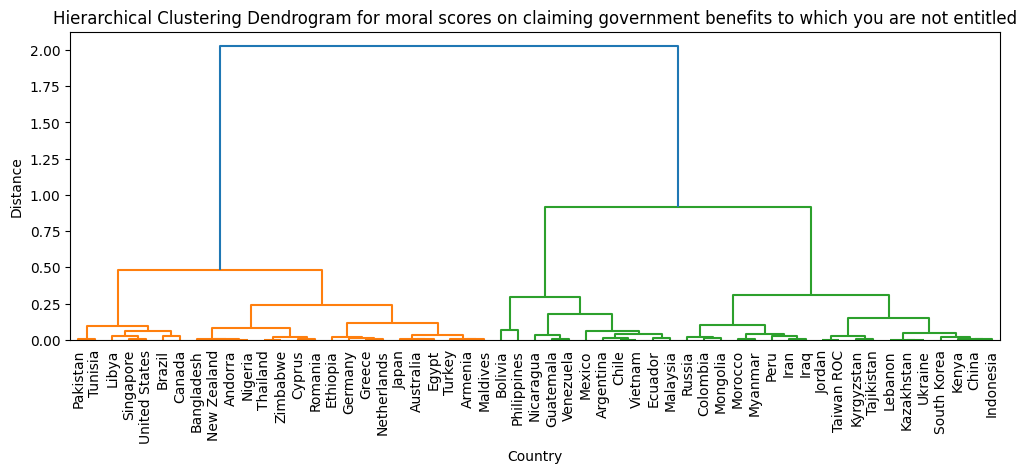

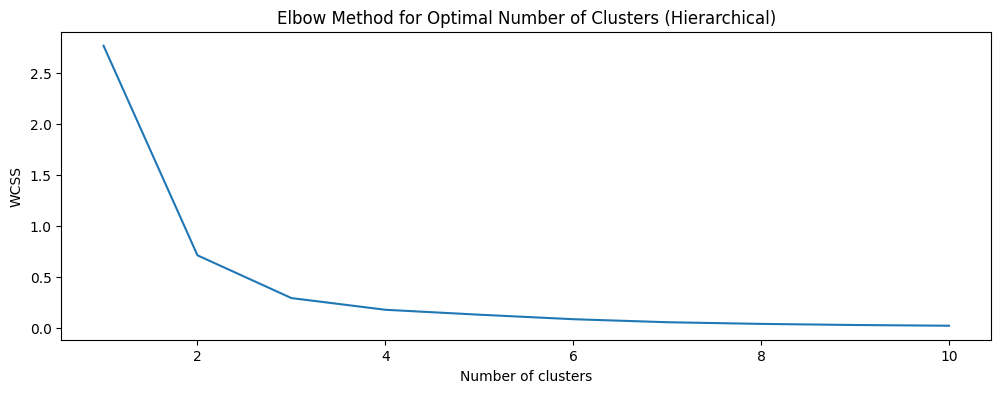

Optimal number of clusters: 3


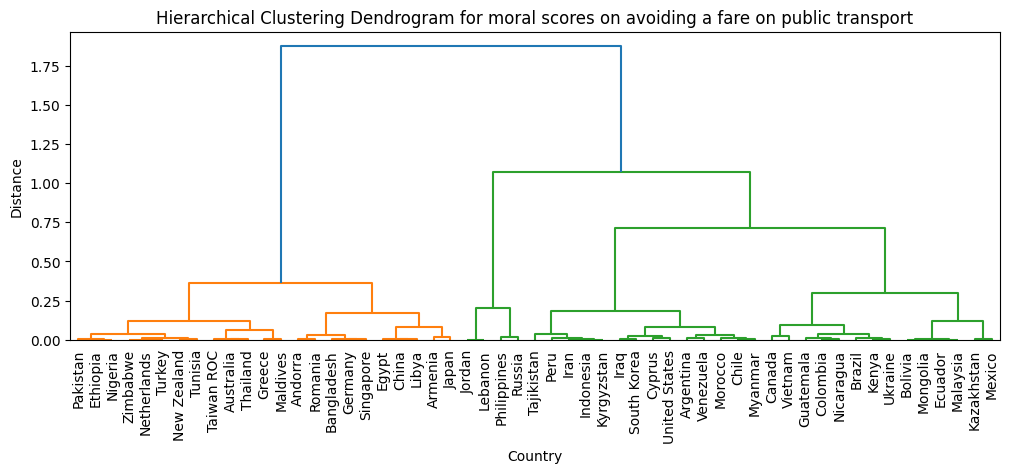

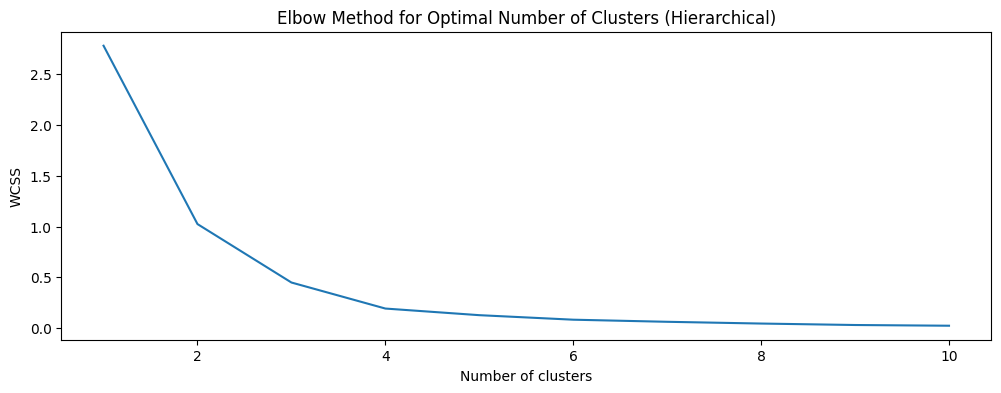

Optimal number of clusters: 3


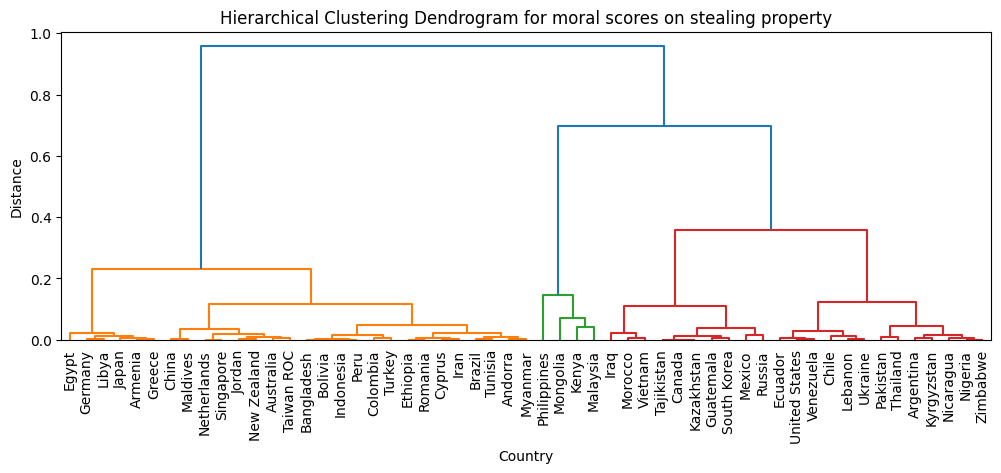

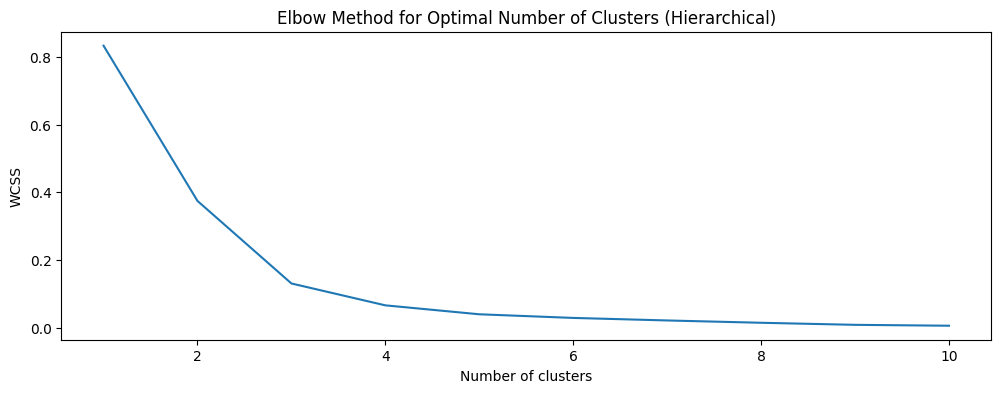

Optimal number of clusters: 3


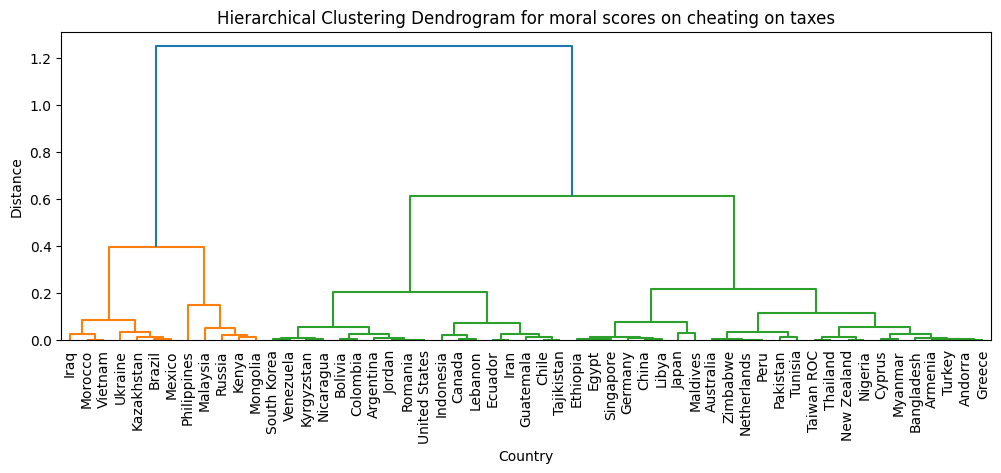

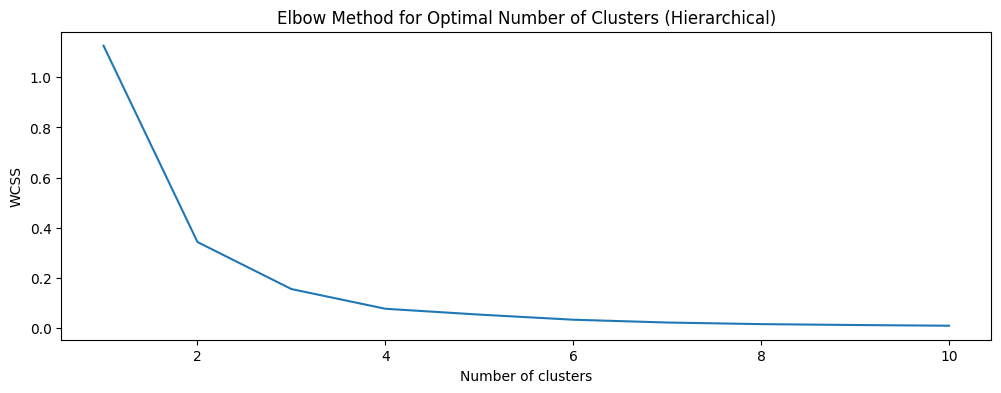

Optimal number of clusters: 3


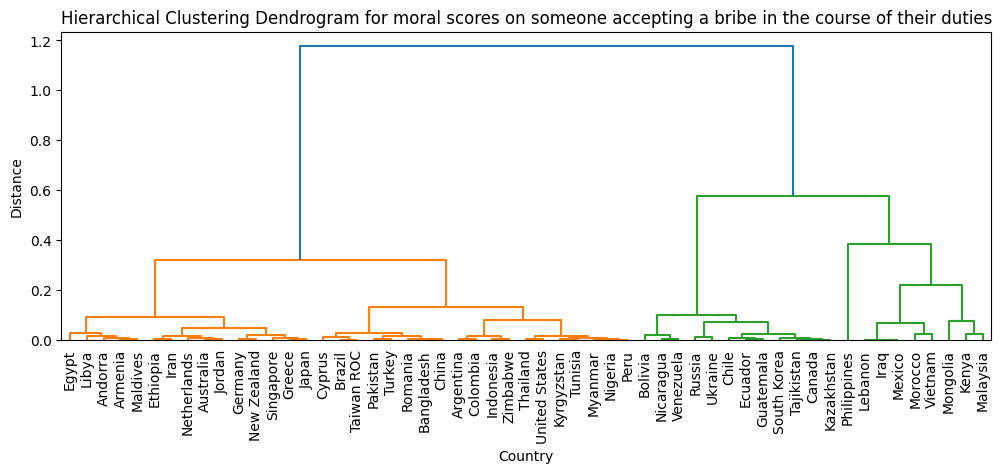

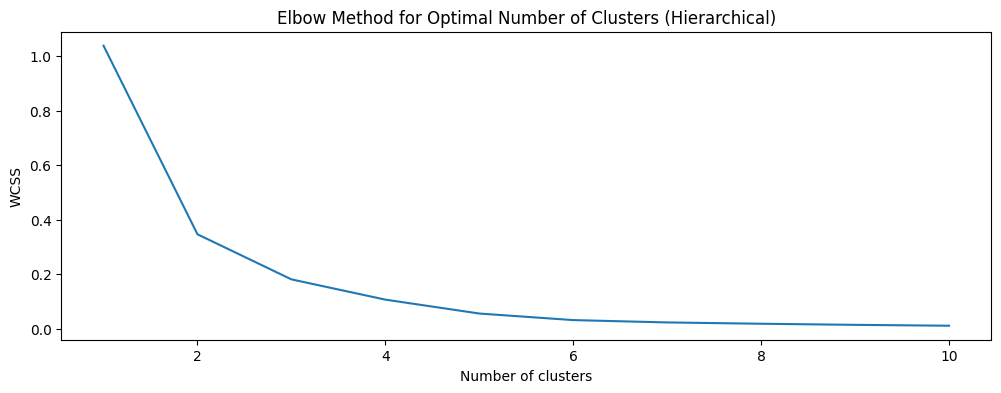

Optimal number of clusters: 3


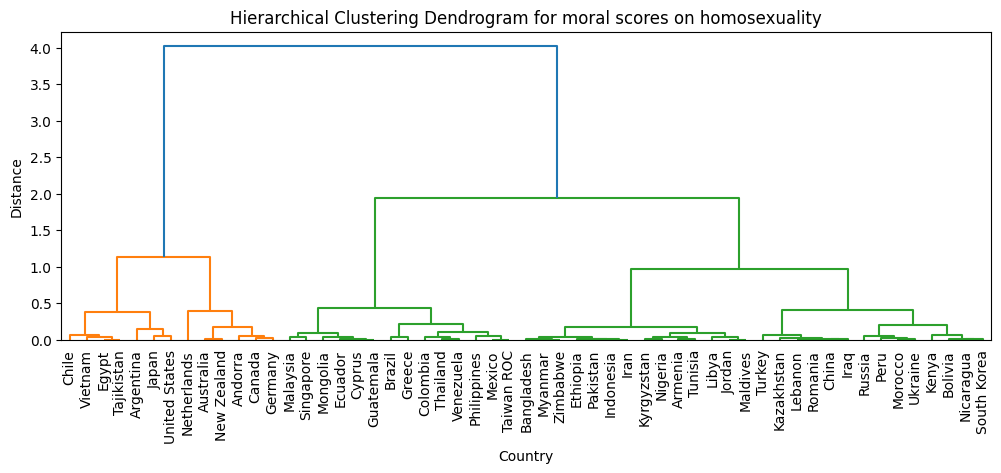

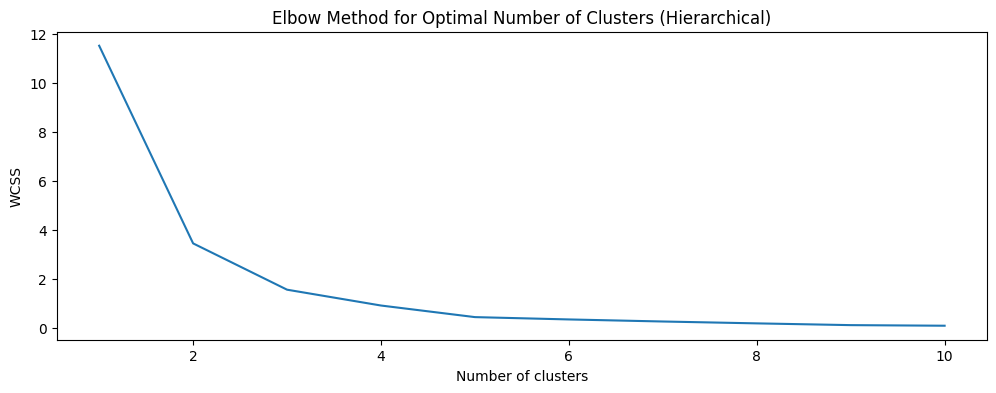

Optimal number of clusters: 3


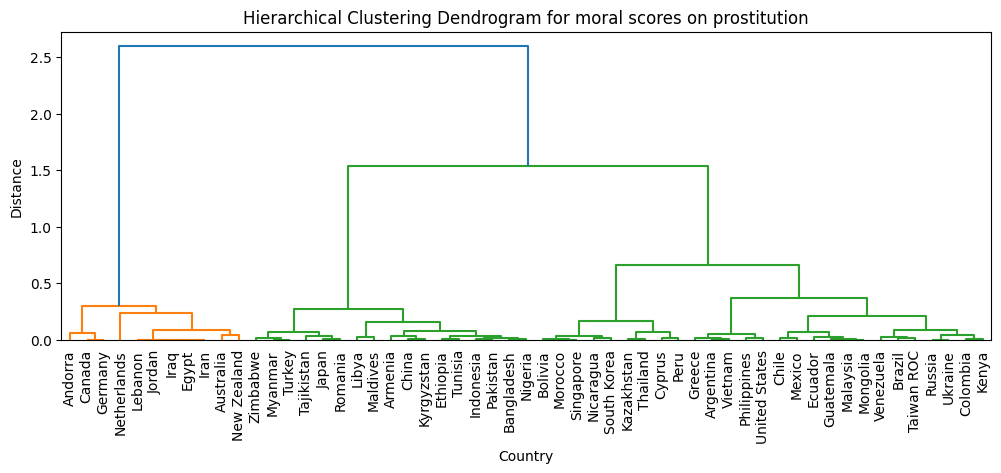

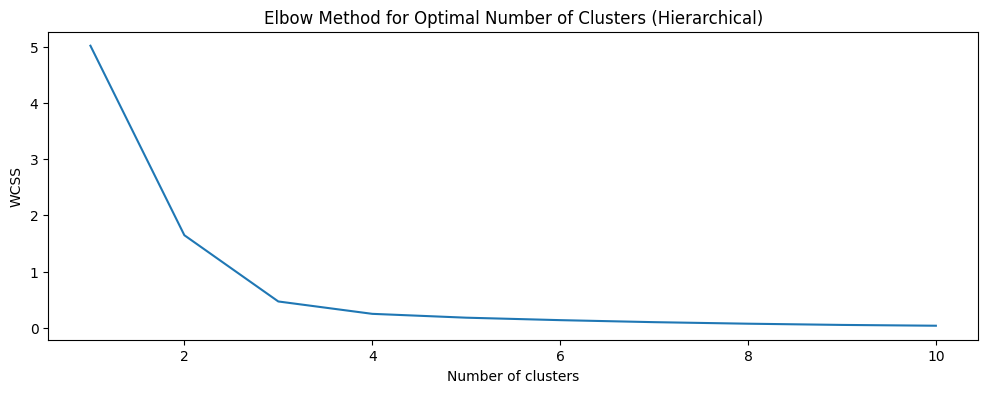

Optimal number of clusters: 3


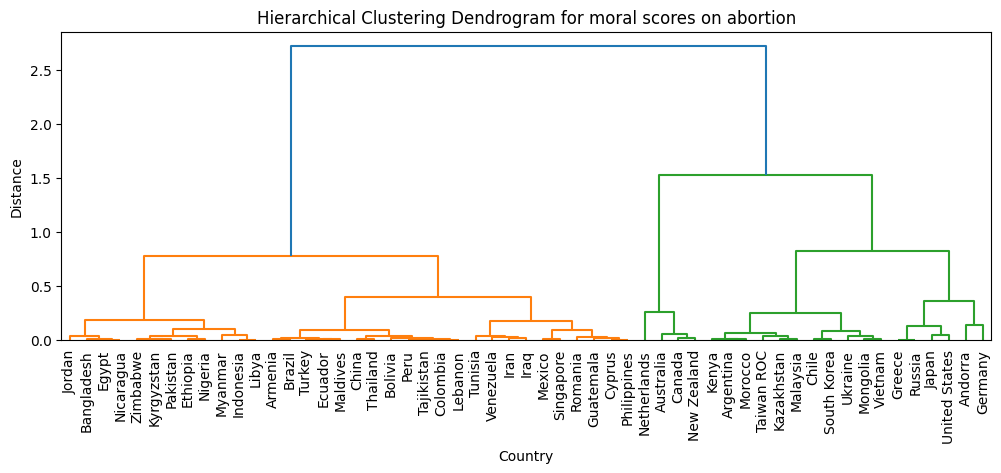

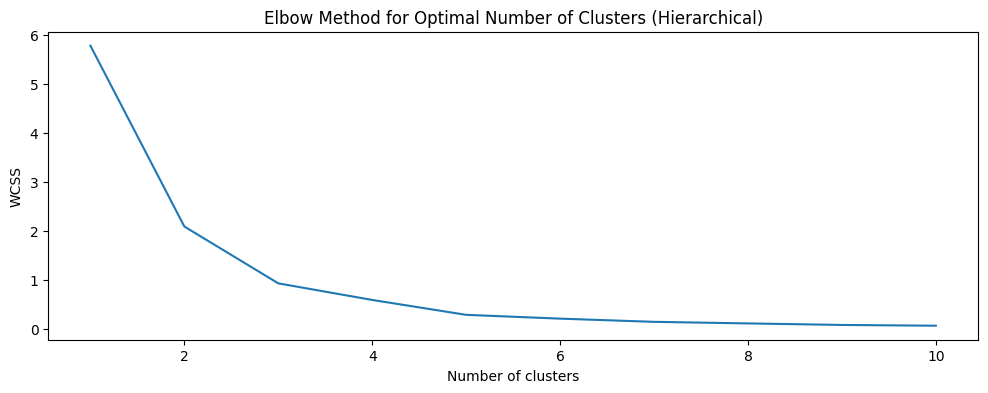

Optimal number of clusters: 3


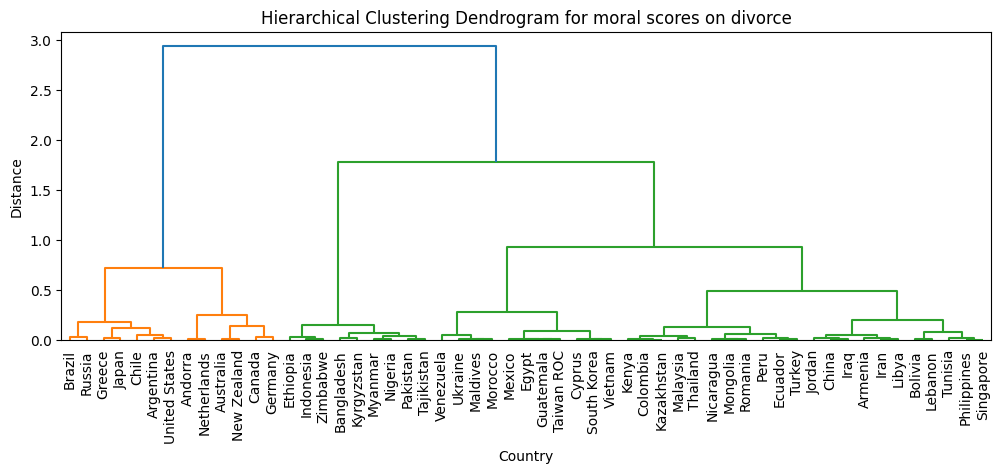

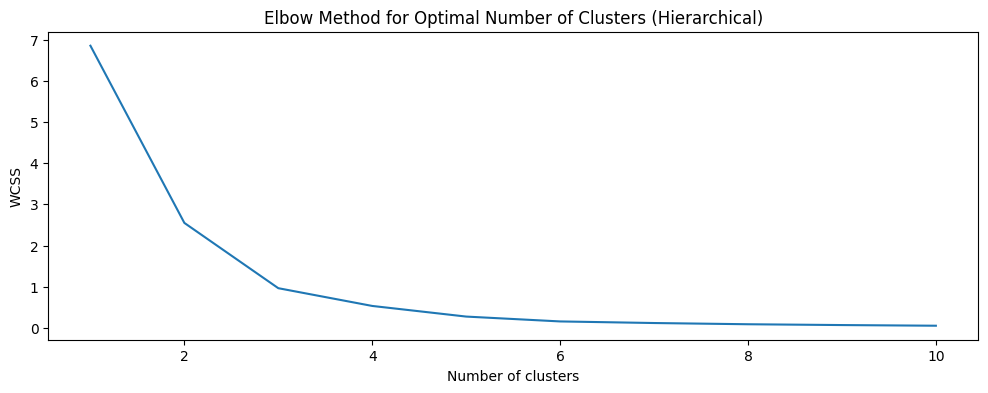

Optimal number of clusters: 3


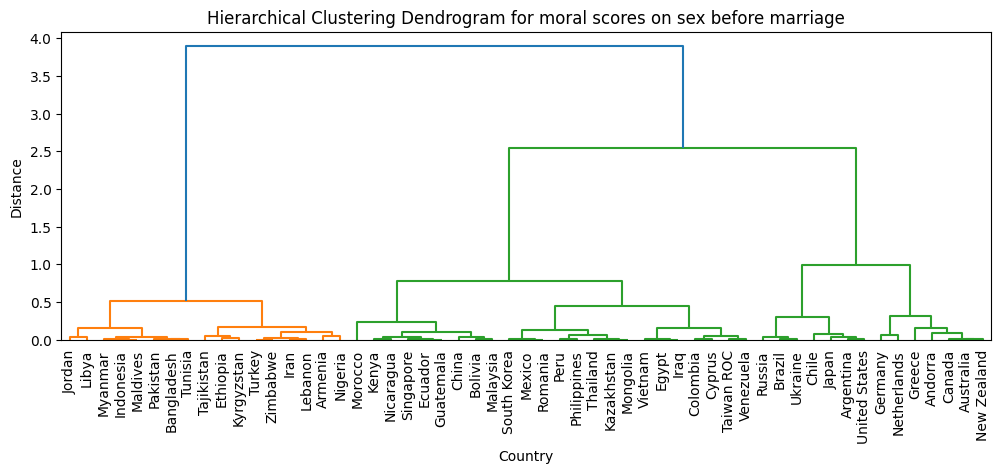

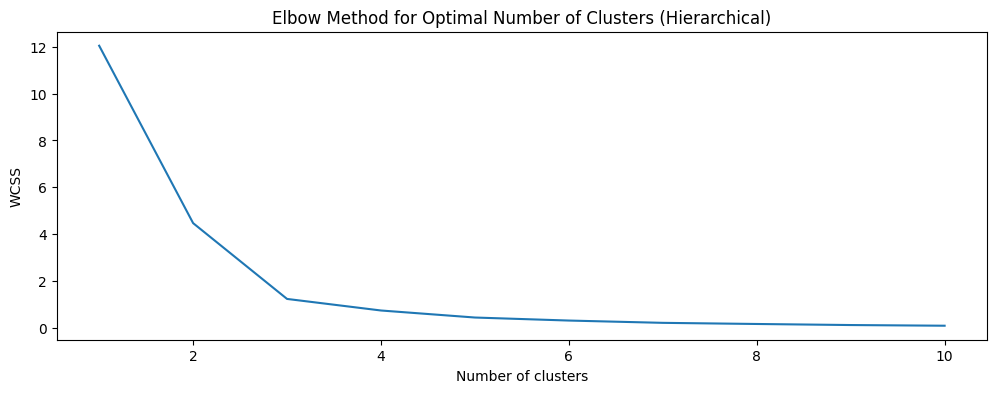

Optimal number of clusters: 3


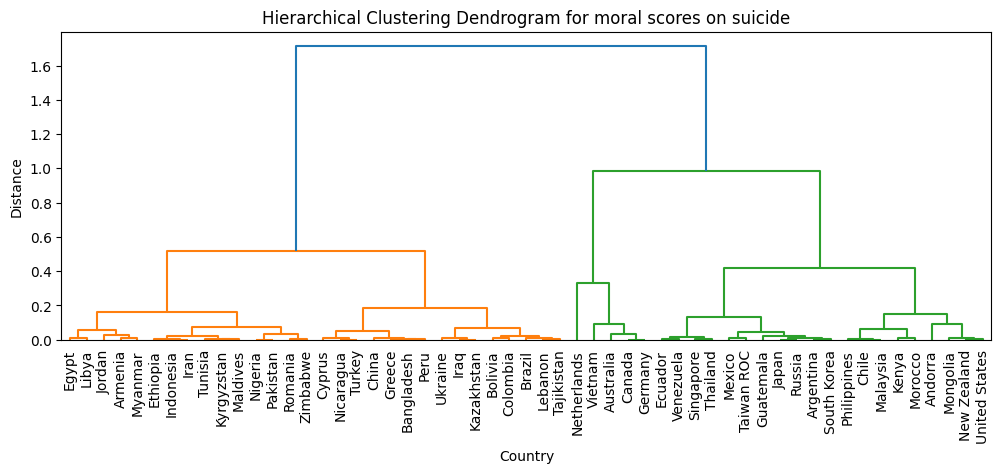

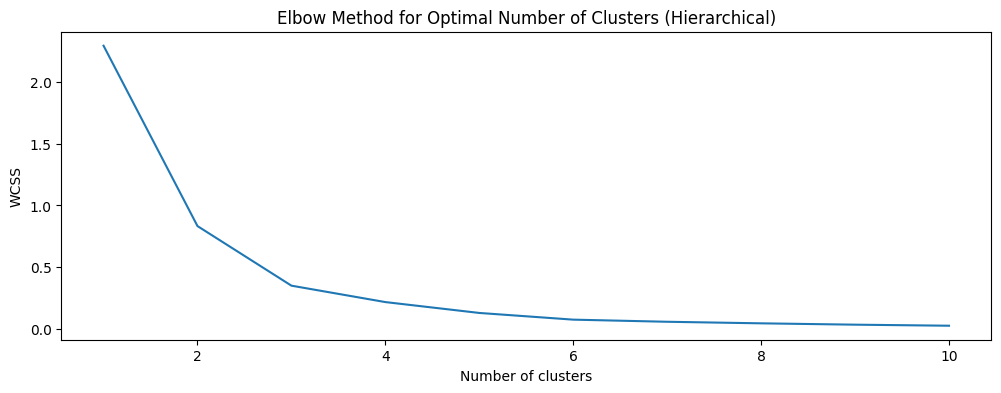

Optimal number of clusters: 3


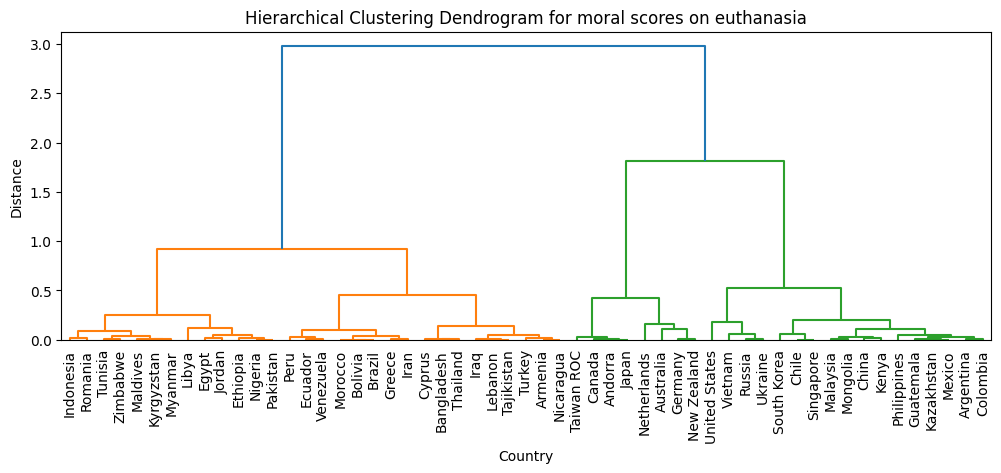

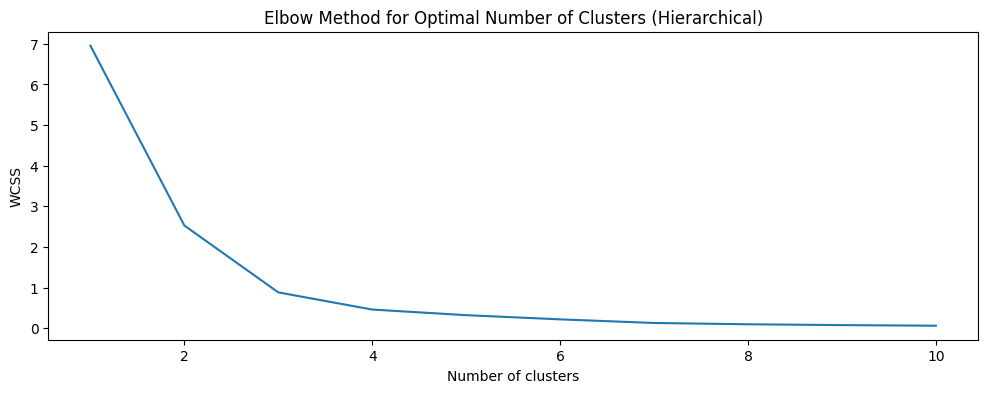

Optimal number of clusters: 3


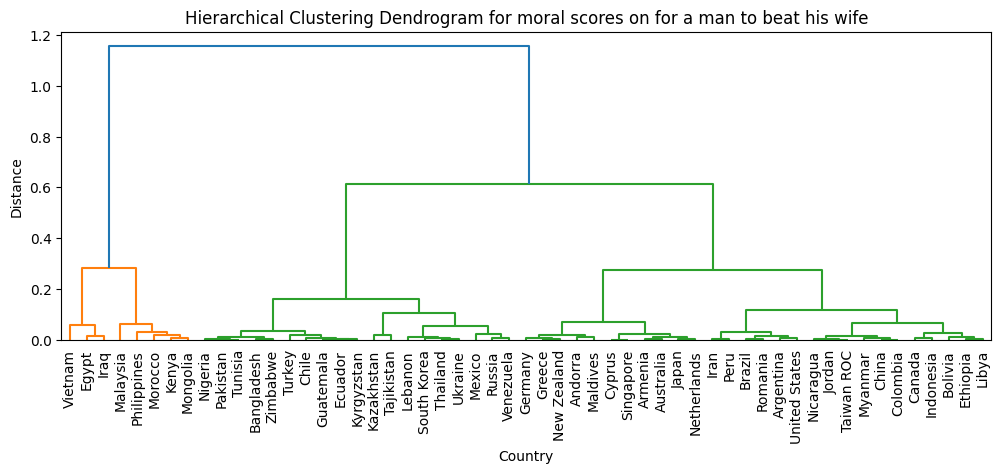

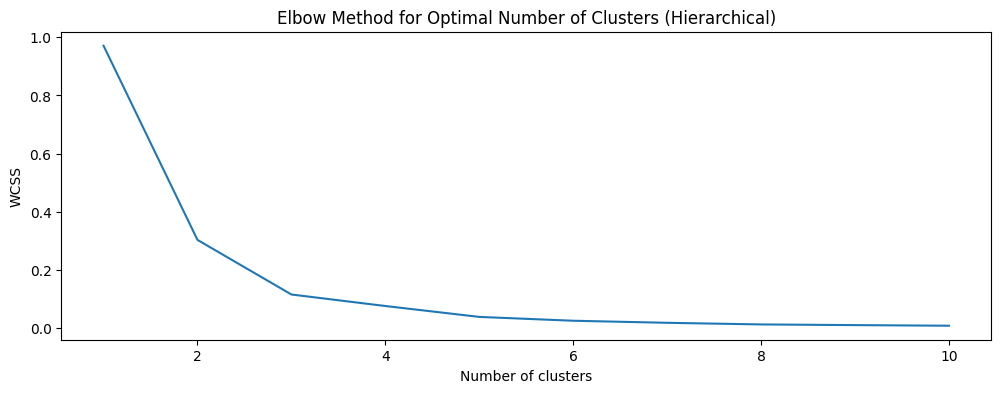

Optimal number of clusters: 3


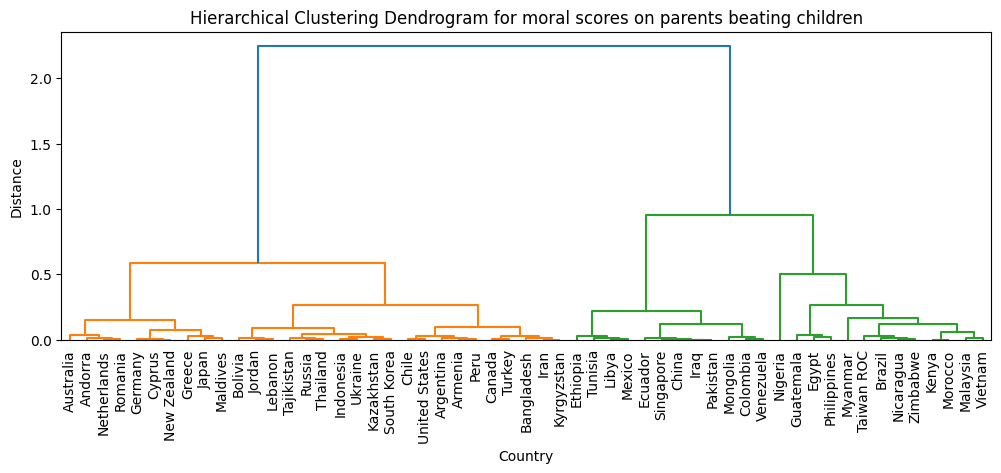

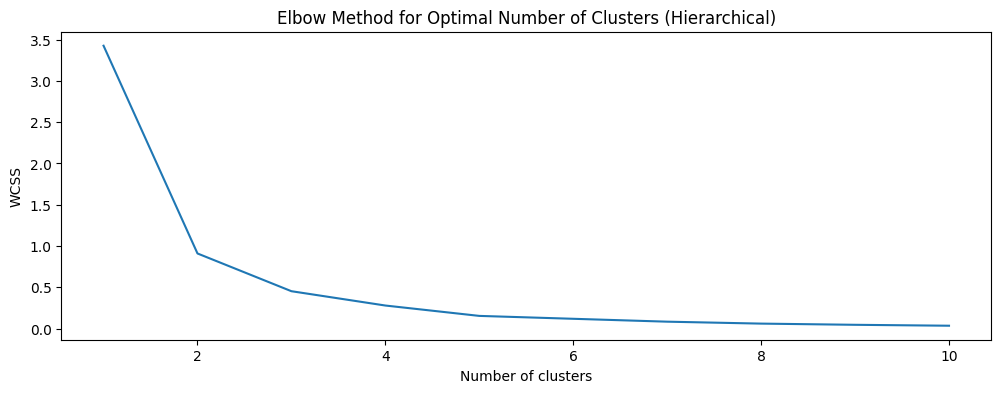

Optimal number of clusters: 3


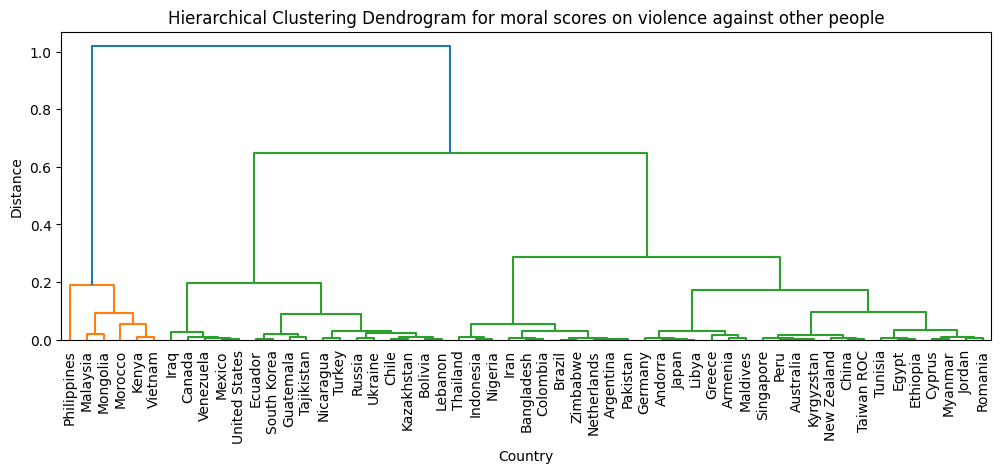

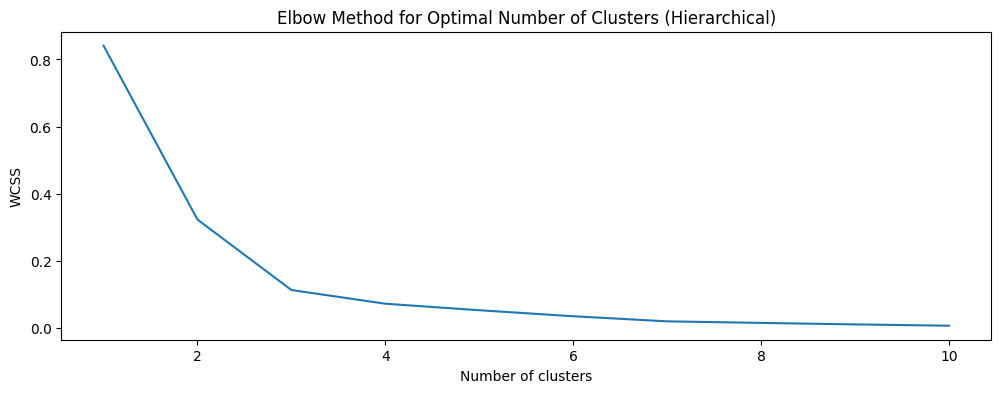

Optimal number of clusters: 3


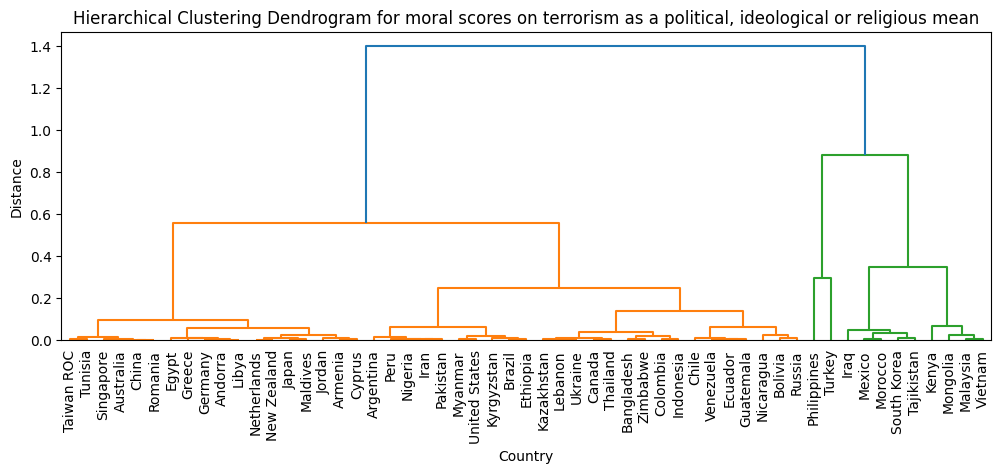

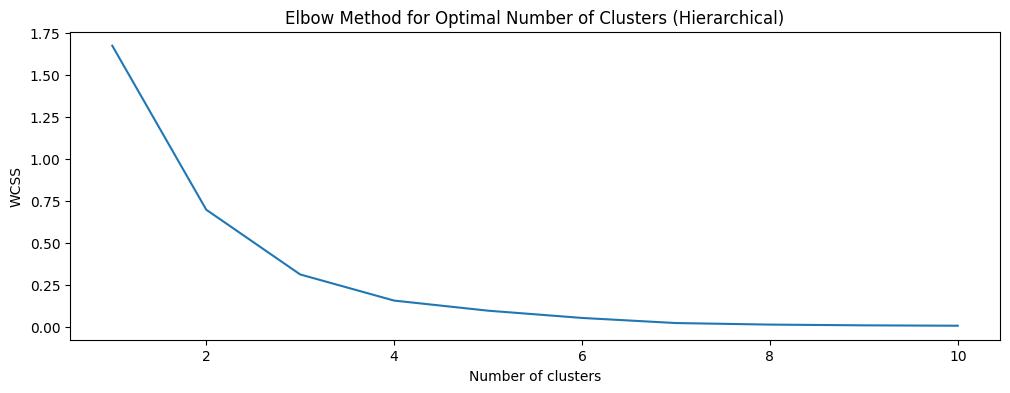

Optimal number of clusters: 3


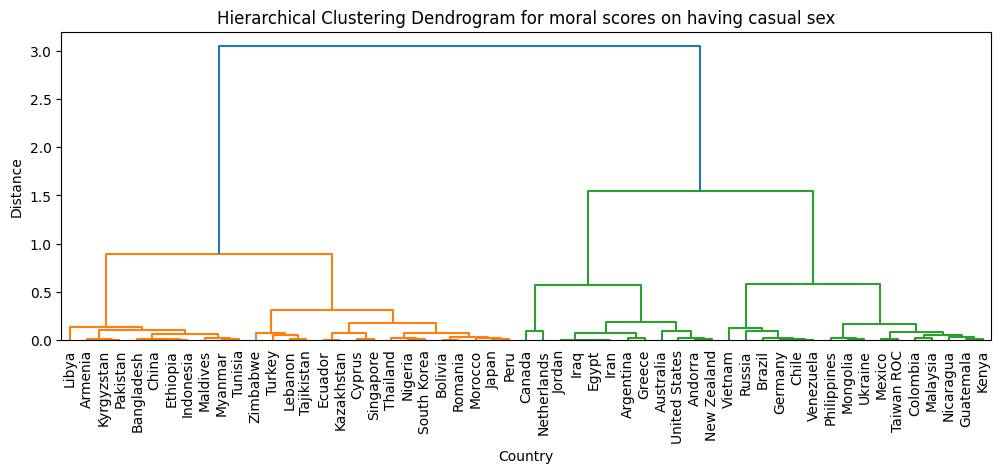

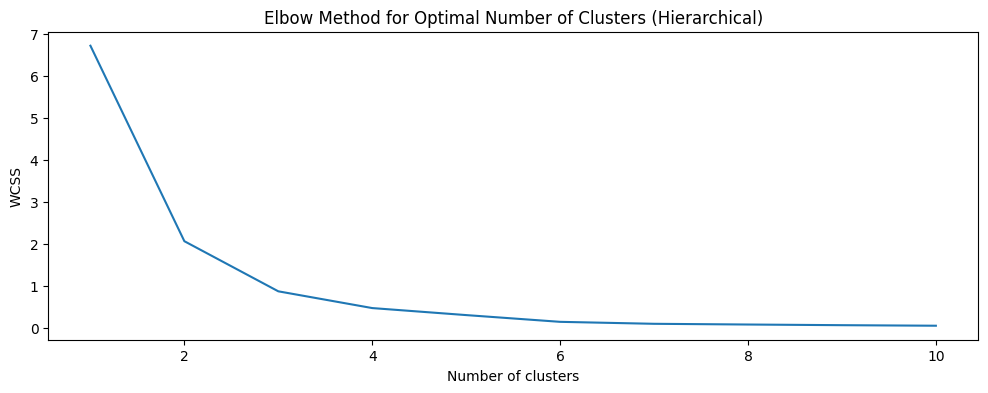

Optimal number of clusters: 3


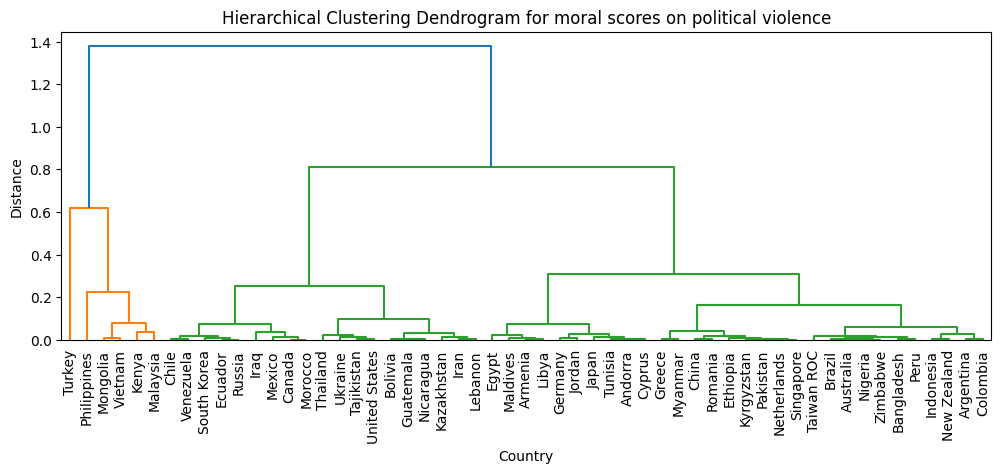

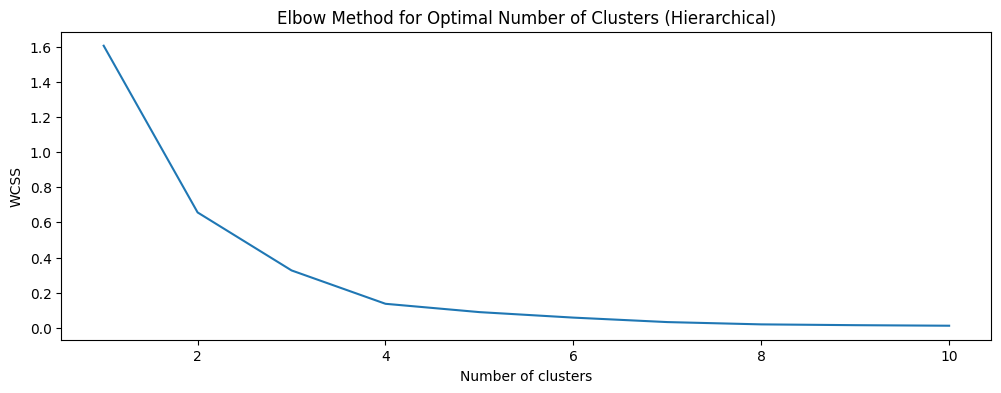

Optimal number of clusters: 4


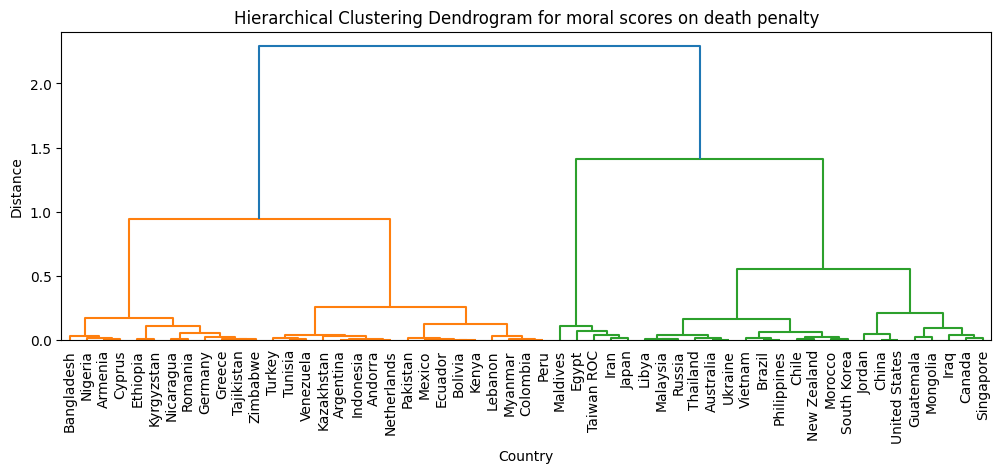

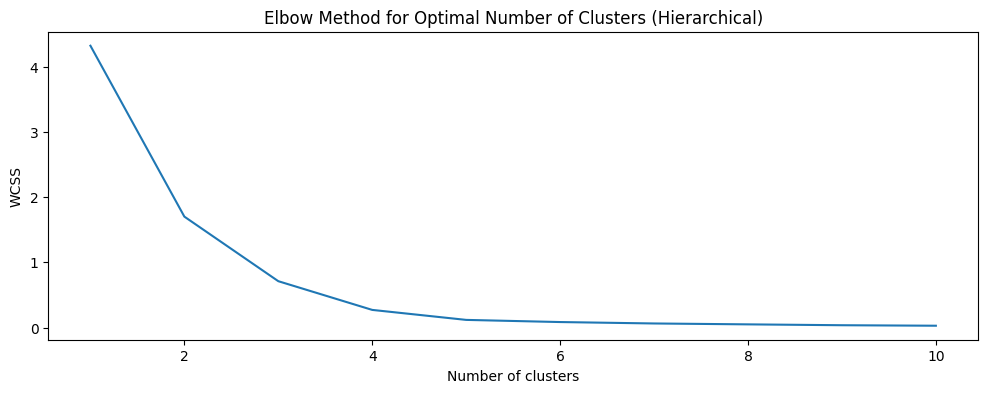

Optimal number of clusters: 3
Results for gpt2:
On topic: claiming government benefits to which you are not entitled
Average moral score for claiming government benefits to which you are not entitled for first cluster: -0.76
Average moral score for claiming government benefits to which you are not entitled for second cluster: -0.217
On topic: avoiding a fare on public transport
Average moral score for avoiding a fare on public transport for first cluster: -0.788
Average moral score for avoiding a fare on public transport for second cluster: -0.072
On topic: stealing property
Average moral score for stealing property for first cluster: -0.913
Average moral score for stealing property for second cluster: -0.503
On topic: cheating on taxes
Average moral score for cheating on taxes for first cluster: -0.506
Average moral score for cheating on taxes for second cluster: -0.851
On topic: someone accepting a bribe in the course of their duties
Average moral score for someone accepting a bribe 

topic  \
0    claiming government benefits to which you are ...   
1    claiming government benefits to which you are ...   
2    claiming government benefits to which you are ...   
3    claiming government benefits to which you are ...   
4    claiming government benefits to which you are ...   
..                                                 ...   
141                                      death penalty   
142                                      death penalty   
143                                      death penalty   
144                                      death penalty   
145                                      death penalty   

                                           combination  \
0    [Regarding the morality of claiming government...   
1    [Regarding the morality of claiming government...   
2    [Regarding the morality of claiming government...   
3    [Regarding the morality of claiming government...   
4    [Regarding the morality of claiming government...   
..                                                 ...   
141  [Regarding the morality of death penalty, the ...   
142  [Regarding the morality of death penalty, the ...   
143  [Regarding the morality of death penalty, the ...   
144  [Regarding the morality of death penalty, the ...   
145  [Regarding the morality of death penalty, the ...   

     average log prob in favor of 'same'  \
0                             -20.203272   
1                             -20.073383   
2                             -20.837564   
3                             -20.715586   
4                             -20.445284   
..                                   ...   
141                           -20.151779   
142                           -20.529331   
143                           -20.028358   
144                           -20.337532   
145                           -19.865414   

     average log prob in favor of 'different' WVS cluster judgement  \
0                                  -20.718519                  same   
1                                  -20.365574                  same   
2                                  -21.268307                  same   
3                                  -20.921791                  same   
4                                  -20.933569             different   
..                                        ...                   ...   
141                                -20.215803                  same   
142                                -20.861877             different   
143                                -20.410782             different   
144                                -20.413340             different   
145                                -19.998333             different   

    model judgement  
0              same  
1              same  
2              same  
3              same  
4              same  
..              ...  
141            same  
142            same  
143            same  
144            same  
145            same  

[146 rows x 6 columns]

Accuracy: 0.486
Precision: 0.496
Recall: 0.905
F1 Score: 0.641
Classification report 
:               precision    recall  f1-score   support

        same       0.36      0.06      0.10        72
   different       0.50      0.91      0.64        74

    accuracy                           0.49       146
   macro avg       0.43      0.48      0.37       146
weighted avg       0.43      0.49      0.37       146

Chi-squared test statistic: 0.336
p-value: 0.562


Results for gpt2-medium:
On topic: claiming government benefits to which you are not entitled
Average moral score for claiming government benefits to which you are not entitled for first cluster: -0.76
Average moral score for claiming government benefits to which you are not entitled for second cluster: -0.217
On topic: avoiding a fare on public transport
Average moral score for avoiding a fare on public transport for first cluster: -0.788
Average moral score for avoiding a fare on public transport for second cluster: -0.072
On 

topic  \
0    claiming government benefits to which you are ...   
1    claiming government benefits to which you are ...   
2    claiming government benefits to which you are ...   
3    claiming government benefits to which you are ...   
4    claiming government benefits to which you are ...   
..                                                 ...   
141                                      death penalty   
142                                      death penalty   
143                                      death penalty   
144                                      death penalty   
145                                      death penalty   

                                           combination  \
0    [Regarding the morality of claiming government...   
1    [Regarding the morality of claiming government...   
2    [Regarding the morality of claiming government...   
3    [Regarding the morality of claiming government...   
4    [Regarding the morality of claiming government...   
..                                                 ...   
141  [Regarding the morality of death penalty, the ...   
142  [Regarding the morality of death penalty, the ...   
143  [Regarding the morality of death penalty, the ...   
144  [Regarding the morality of death penalty, the ...   
145  [Regarding the morality of death penalty, the ...   

     average log prob in favor of 'same'  \
0                             -20.171589   
1                             -20.179010   
2                             -20.024958   
3                             -19.933113   
4                             -19.838223   
..                                   ...   
141                           -19.066189   
142                           -20.710859   
143                           -18.922466   
144                           -20.223049   
145                           -18.777418   

     average log prob in favor of 'different' WVS cluster judgement  \
0                                  -20.611168                  same   
1                                  -20.294710                  same   
2                                  -20.394896                  same   
3                                  -20.014969                  same   
4                                  -20.240595             different   
..                                        ...                   ...   
141                                -18.678602                  same   
142                                -20.510008             different   
143                                -19.050865             different   
144                                -20.056505             different   
145                                -18.691544             different   

    model judgement  
0              same  
1              same  
2              same  
3              same  
4              same  
..              ...  
141       different  
142       different  
143            same  
144       different  
145       different  

[146 rows x 6 columns]

Accuracy: 0.473
Precision: 0.469
Recall: 0.311
F1 Score: 0.374
Classification report 
:               precision    recall  f1-score   support

        same       0.47      0.64      0.54        72
   different       0.47      0.31      0.37        74

    accuracy                           0.47       146
   macro avg       0.47      0.47      0.46       146
weighted avg       0.47      0.47      0.46       146

Chi-squared test statistic: 0.219
p-value: 0.64


Results for gpt2-large:
On topic: claiming government benefits to which you are not entitled


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Average moral score for claiming government benefits to which you are not entitled for first cluster: -0.76
Average moral score for claiming government benefits to which you are not entitled for second cluster: -0.217
On topic: avoiding a fare on public transport
Average moral score for avoiding a fare on public transport for first cluster: -0.788
Average moral score for avoiding a fare on public transport for second cluster: -0.072
On topic: stealing property
Average moral score for stealing property for first cluster: -0.913
Average moral score for stealing property for second cluster: -0.503
On topic: cheating on taxes
Average moral score for cheating on taxes for first cluster: -0.506
Average moral score for cheating on taxes for second cluster: -0.851
On topic: someone accepting a bribe in the course of their duties
Average moral score for someone accepting a bribe in the course of their duties for first cluster: -0.875
Average moral score for someone accepting a bribe in the cour

KeyboardInterrupt: 

In [ ]:
### N.B.: MAKE SURE TO CHECK WHICH GENERATE_TOPIC_PROMPTS AND GET_DIRECT_PROBING RESULTS YOU'RE USING (RANDOMIZED TRIAL GENERATED REPRESENTATIVES OR EXHAUSTIVE VERSION)


topic_clusters_dict = {}
cluster_averages_dict = {}
for topic in topic_list:
    topic_clusters_df, cluster_averages = find_clusters_per_topic(WVS_preprocessed_df, topic)
    topic_clusters_dict[topic] = topic_clusters_df
    cluster_averages_dict[topic] = cluster_averages

# Function to get probing results using precomputed clusters
def get_results_for_model(dataset, model_name):
    df = pd.DataFrame()
    for topic, clusters_df in topic_clusters_dict.items():
        print(f"On topic: {topic}")
        cluster_averages = cluster_averages_dict[topic]
        topic_results_df = get_direct_probing_results(dataset, topic, clusters_df, cluster_averages, model_name) # for representatives w random trials version include trials=n as fourth parameter
        df = pd.concat([df, topic_results_df], ignore_index=True)
    return df


print("Results for gpt2:")
gpt2_results_df = get_results_for_model('WVS', 'gpt2')
display(gpt2_results_df)
evaluate_results('WVS', gpt2_results_df)

print("Results for gpt2-medium:")
gpt2medium_results_df = get_results_for_model('WVS', 'gpt2-medium')
display(gpt2medium_results_df)
evaluate_results('WVS', gpt2medium_results_df)

print("Results for gpt2-large:")
gpt2large_results_df = get_results_for_model('WVS', 'gpt2-large')
display(gpt2large_results_df)
evaluate_results('WVS', gpt2large_results_df)

print("Results for QWEN:")
qwen15_results_df = get_results_for_model('WVS', 'Qwen1.5-0.5B')
display(qwen15_results_df)
evaluate_results('WVS', qwen15_results_df)

print("Results for OPT-125:")
OPT_results_df = get_results_for_model('WVS', 'opt-125m')
display(OPT_results_df)
evaluate_results('WVS', OPT_results_df)

print("Results for BLOOM:")
bloom_results_df = get_results_for_model('WVS', 'bigscience/bloomz-560m')
display(bloom_results_df)
evaluate_results('WVS', bloom_results_df)


#### PEW

In [ ]:
# TODO: add PEW topic list

topic_list = ['drinking alcohol', 'gambling', 'getting a divorce', 'having an abortion', 'homosexuality', 'married people having an affair', 'sex between unmarried adults', 'using contraceptives']

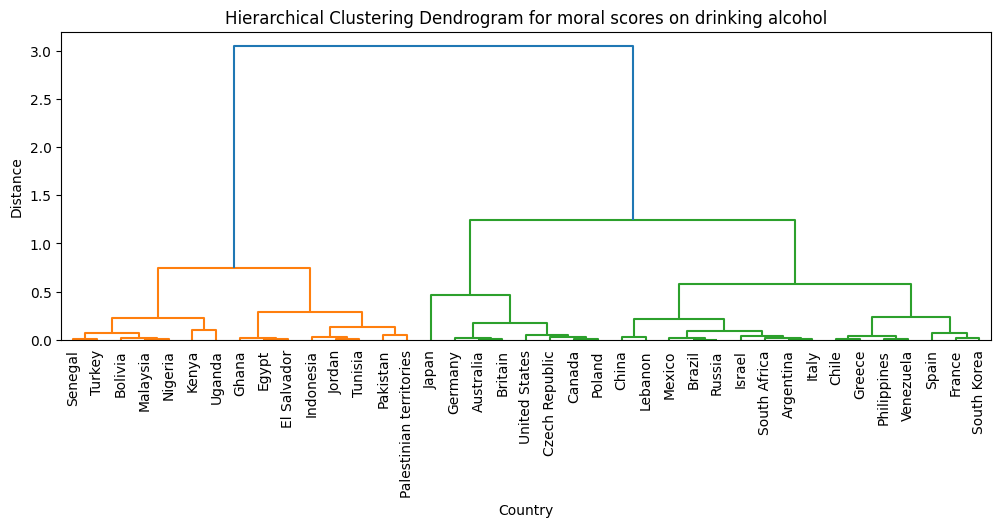

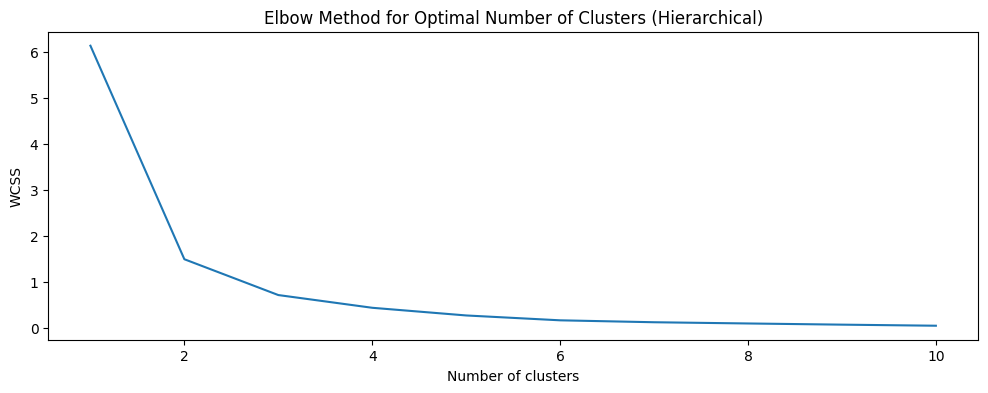

Optimal number of clusters: 3


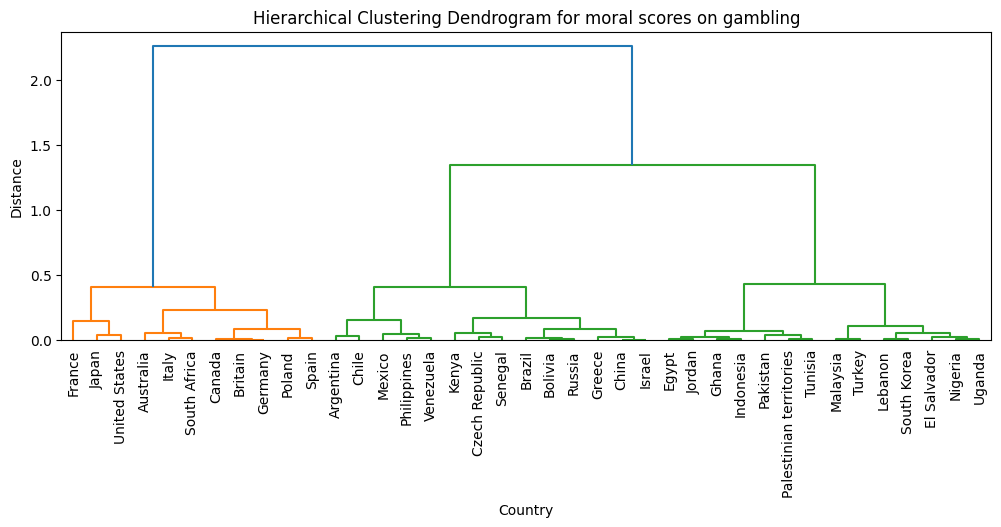

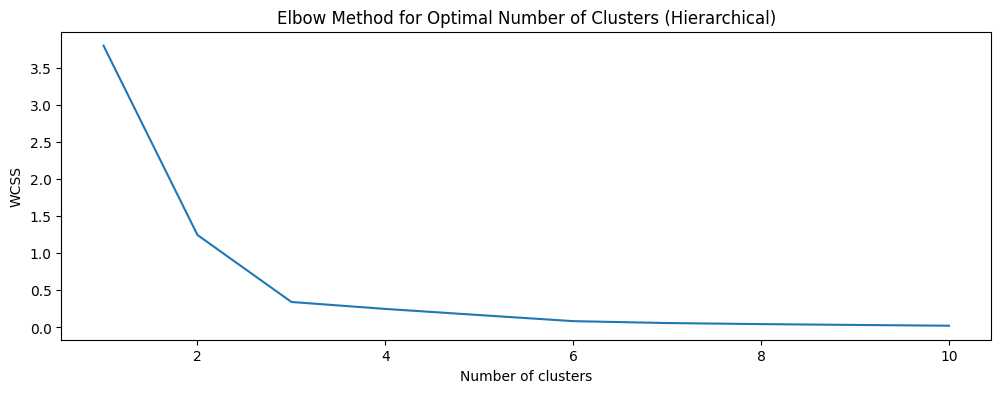

Optimal number of clusters: 3


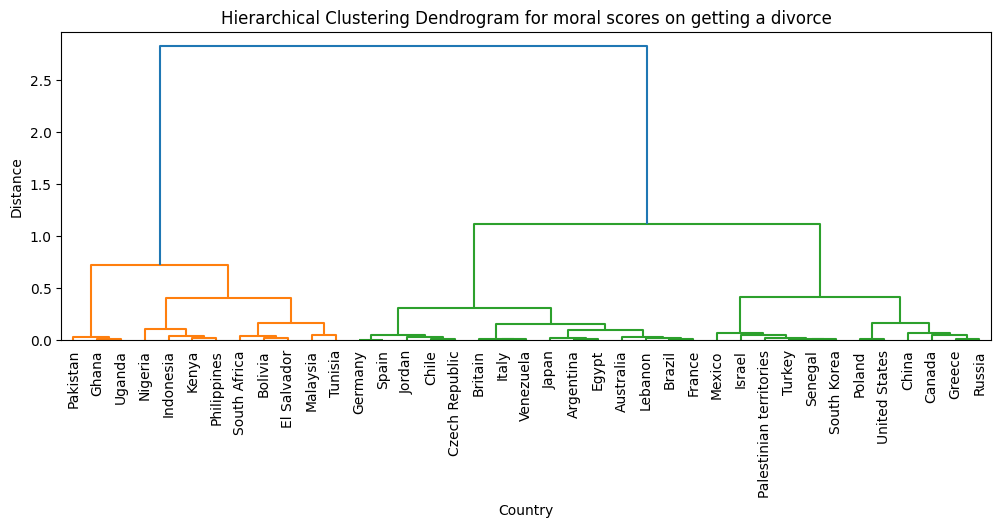

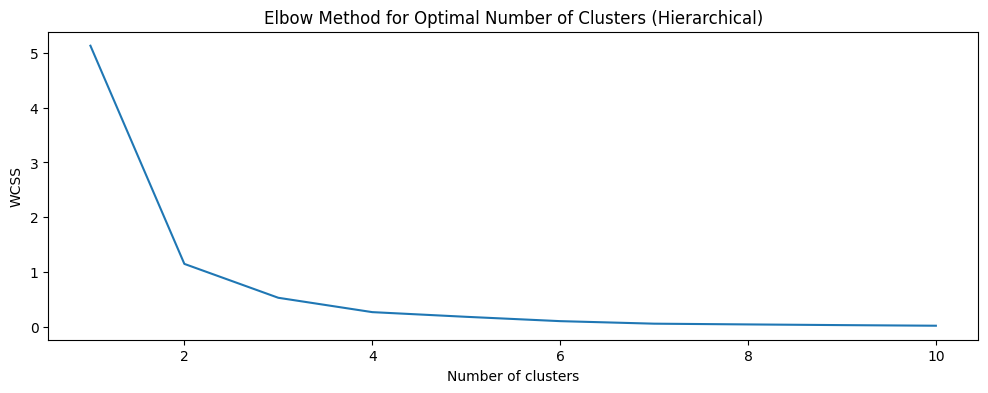

Optimal number of clusters: 3


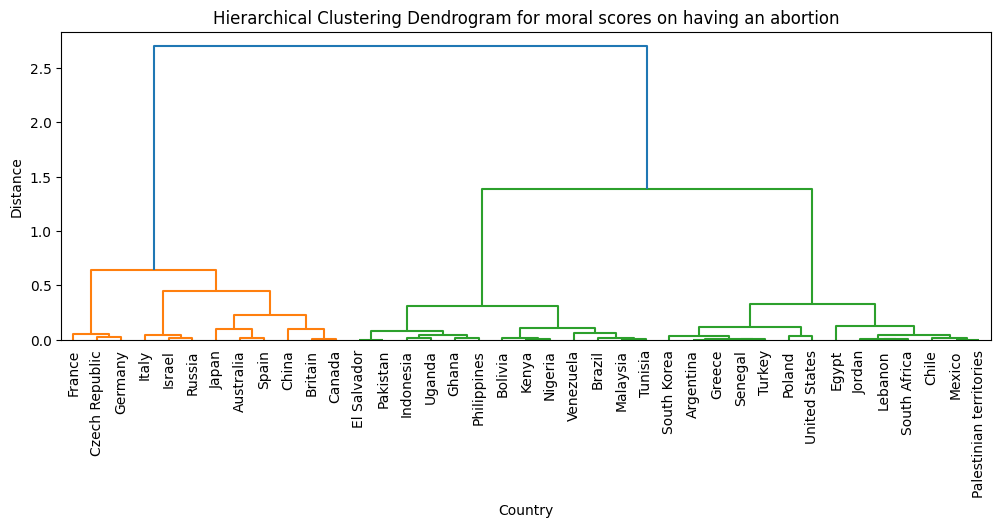

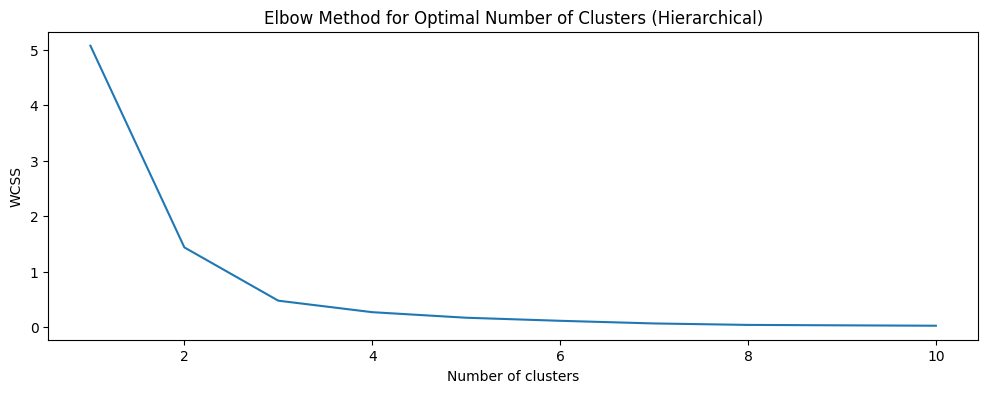

Optimal number of clusters: 3


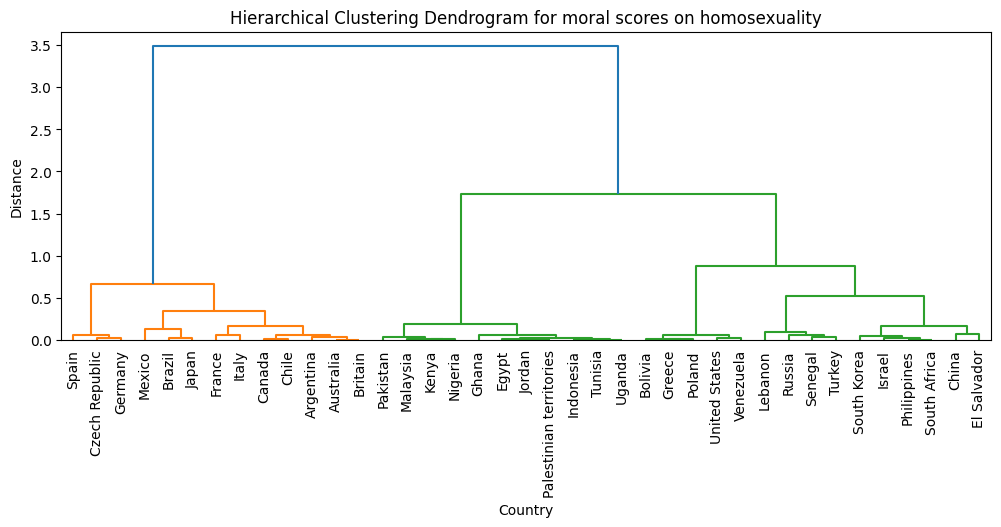

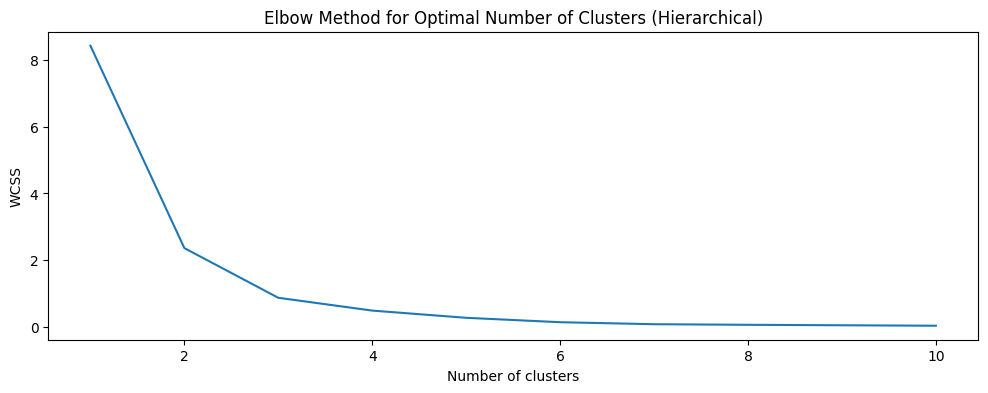

Optimal number of clusters: 3


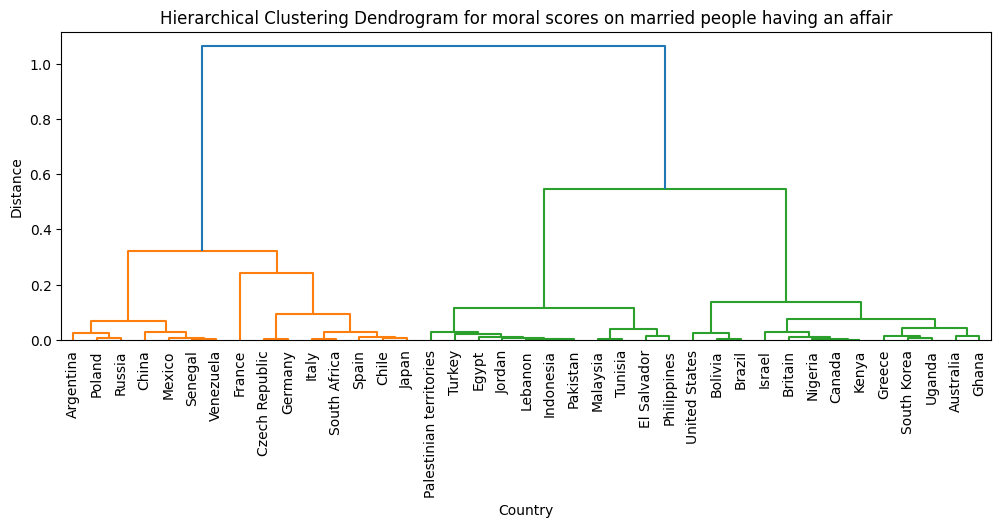

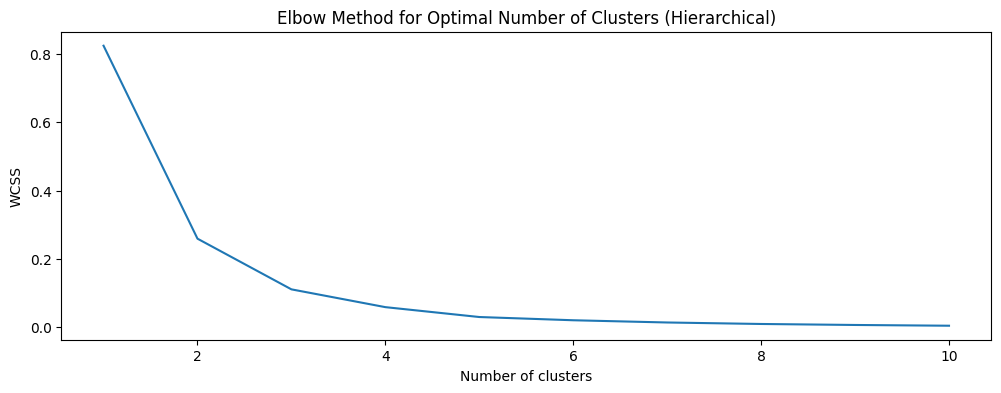

Optimal number of clusters: 3


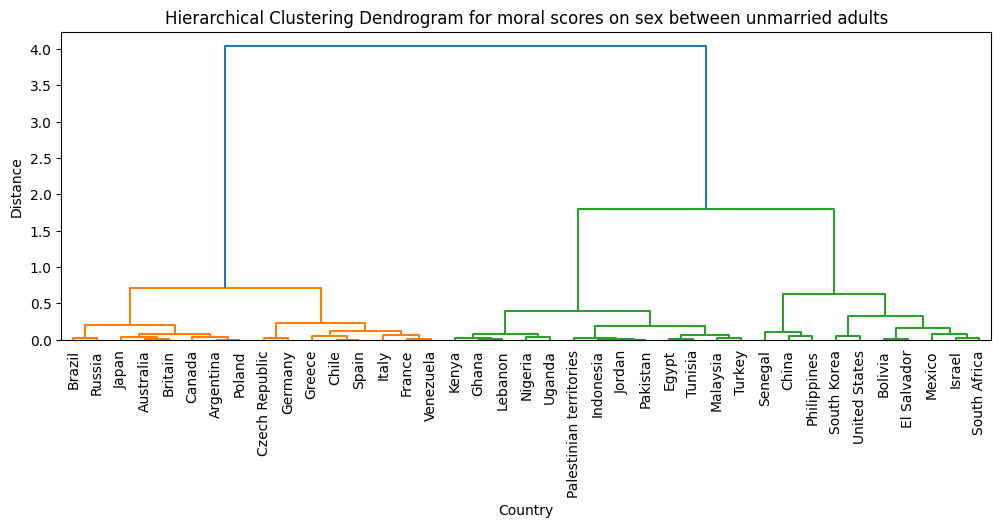

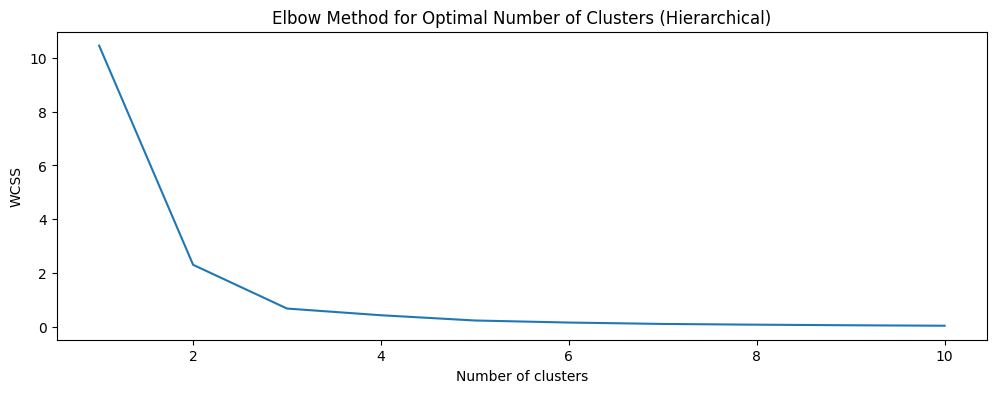

Optimal number of clusters: 3


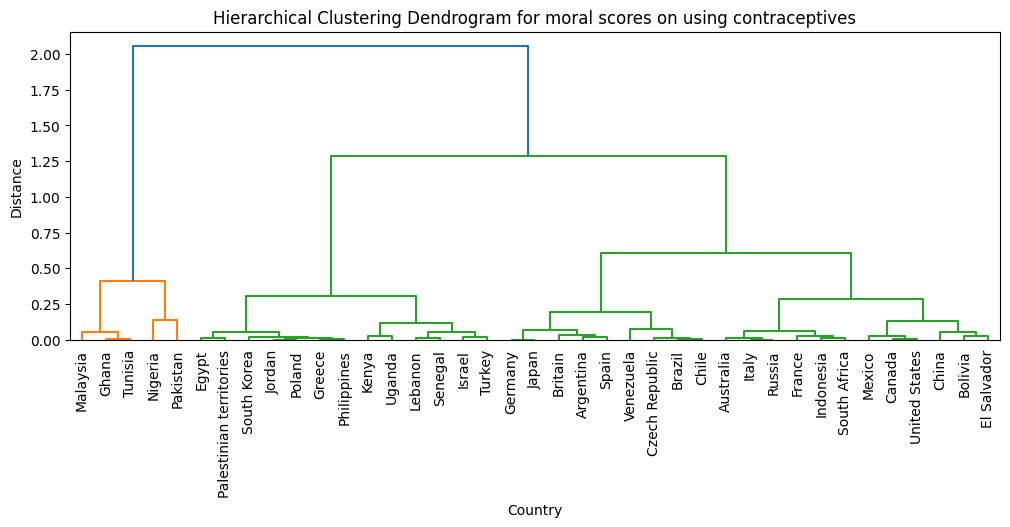

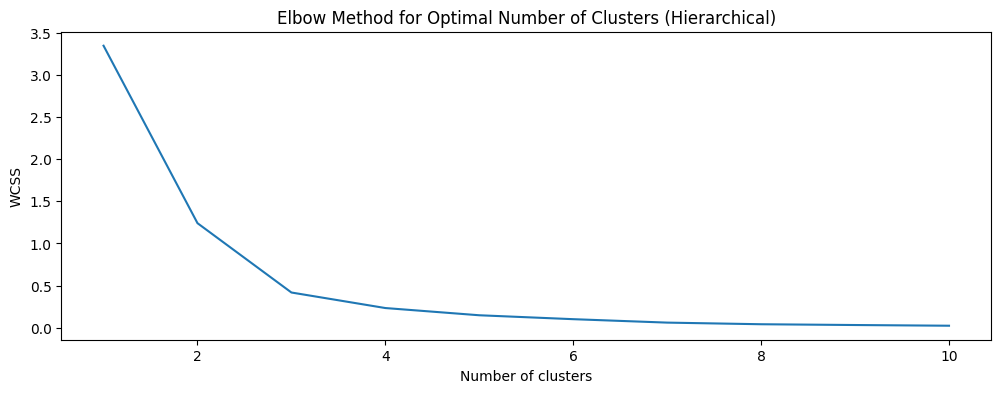

Optimal number of clusters: 3
Results for gpt2:
On topic: drinking alcohol
On topic: gambling
On topic: getting a divorce
On topic: having an abortion
On topic: homosexuality
On topic: married people having an affair
On topic: sex between unmarried adults
On topic: using contraceptives


topic                                        combination  \
0       drinking alcohol  [Regarding the morality of drinking alcohol, t...   
1       drinking alcohol  [Regarding the morality of drinking alcohol, t...   
2       drinking alcohol  [Regarding the morality of drinking alcohol, t...   
3       drinking alcohol  [Regarding the morality of drinking alcohol, t...   
4       drinking alcohol  [Regarding the morality of drinking alcohol, t...   
..                   ...                                                ...   
59  using contraceptives  [Regarding the morality of using contraceptive...   
60  using contraceptives  [Regarding the morality of using contraceptive...   
61  using contraceptives  [Regarding the morality of using contraceptive...   
62  using contraceptives  [Regarding the morality of using contraceptive...   
63  using contraceptives  [Regarding the morality of using contraceptive...   

    average log prob in favor of 'same'  \
0                            -20.578964   
1                            -20.296034   
2                            -20.088873   
3                            -19.816483   
4                            -20.422001   
..                                  ...   
59                           -20.308846   
60                           -20.575798   
61                           -20.388472   
62                           -20.218431   
63                           -20.195658   

    average log prob in favor of 'different' PEW cluster judgement  \
0                                 -20.834965                  same   
1                                 -20.251366                  same   
2                                 -20.310007                  same   
3                                 -19.839729                  same   
4                                 -20.713789             different   
..                                       ...                   ...   
59                                -20.341394                  same   
60                                -20.820511             different   
61                                -20.713789             different   
62                                -20.232941             different   
63                                -20.183048             different   

   model judgement  
0             same  
1        different  
2             same  
3             same  
4             same  
..             ...  
59            same  
60            same  
61            same  
62            same  
63       different  

[64 rows x 6 columns]

Accuracy: 0.5
Precision: 0.5
Recall: 0.875
F1 Score: 0.636
Classification report 
:               precision    recall  f1-score   support

        same       0.50      0.12      0.20        32
   different       0.50      0.88      0.64        32

    accuracy                           0.50        64
   macro avg       0.50      0.50      0.42        64
weighted avg       0.50      0.50      0.42        64

Chi-squared test statistic: 0.0
p-value: 1.0


Results for gpt2-medium:
On topic: drinking alcohol
On topic: gambling
On topic: getting a divorce
On topic: having an abortion


KeyboardInterrupt: 

In [ ]:
# TODO: modify the code above

### N.B.: USING THE RANDOMIZED TRIAL CHOSEN REPRESENTATIVES VERSION NOW FOR QUICKER TESTING

# Step 1: Calculate clusters per topic and save in a dictionary
topic_clusters_dict = {}
cluster_averages_dict = {}
for topic in topic_list:
    topic_clusters_df, cluster_averages = find_clusters_per_topic(PEW_preprocessed_df, topic)
    topic_clusters_dict[topic] = topic_clusters_df
    cluster_averages_dict[topic] = cluster_averages

# Function to get probing results using precomputed clusters
def get_results_for_model(dataset, model_name, trials=5):
    df = pd.DataFrame()
    for topic, clusters_df in topic_clusters_dict.items():
        print(f"On topic: {topic}")
        cluster_averages = cluster_averages_dict[topic]
        topic_results_df = get_direct_probing_results(dataset, topic, clusters_df, cluster_averages, model_name, trials=1) # for representatives w random trials version include trials=n as fourth parameter
        df = pd.concat([df, topic_results_df], ignore_index=True)
    return df

# Step 2: Get probing results for different models using the precomputed clusters
print("Results for gpt2:")
gpt2_results_df = get_results_for_model('PEW', 'gpt2')
display(gpt2_results_df)
evaluate_results('PEW', gpt2_results_df)

print("Results for gpt2-medium:")
gpt2medium_results_df = get_results_for_model('PEW', 'gpt2-medium')
display(gpt2medium_results_df)
evaluate_results('PEW', gpt2medium_results_df)

print("Results for gpt2-large:")
gpt2large_results_df = get_results_for_model('PEW', 'gpt2-large')
display(gpt2large_results_df)
evaluate_results('PEW', gpt2large_results_df)

print("Results for QWEN:")
qwen15_results_df = get_results_for_model('PEW', 'Qwen1.5-0.5B')
display(qwen15_results_df)
evaluate_results('PEW', qwen15_results_df)

print("Results for OPT-125:")
OPT_results_df = get_results_for_model('PEW', 'opt-125m')
display(OPT_results_df)
evaluate_results('PEW', OPT_results_df)

print("Results for BLOOM:")
bloom_results_df = get_results_for_model('PEW', 'bigscience/bloomz-560m')
display(bloom_results_df)
evaluate_results('PEW', bloom_results_df)


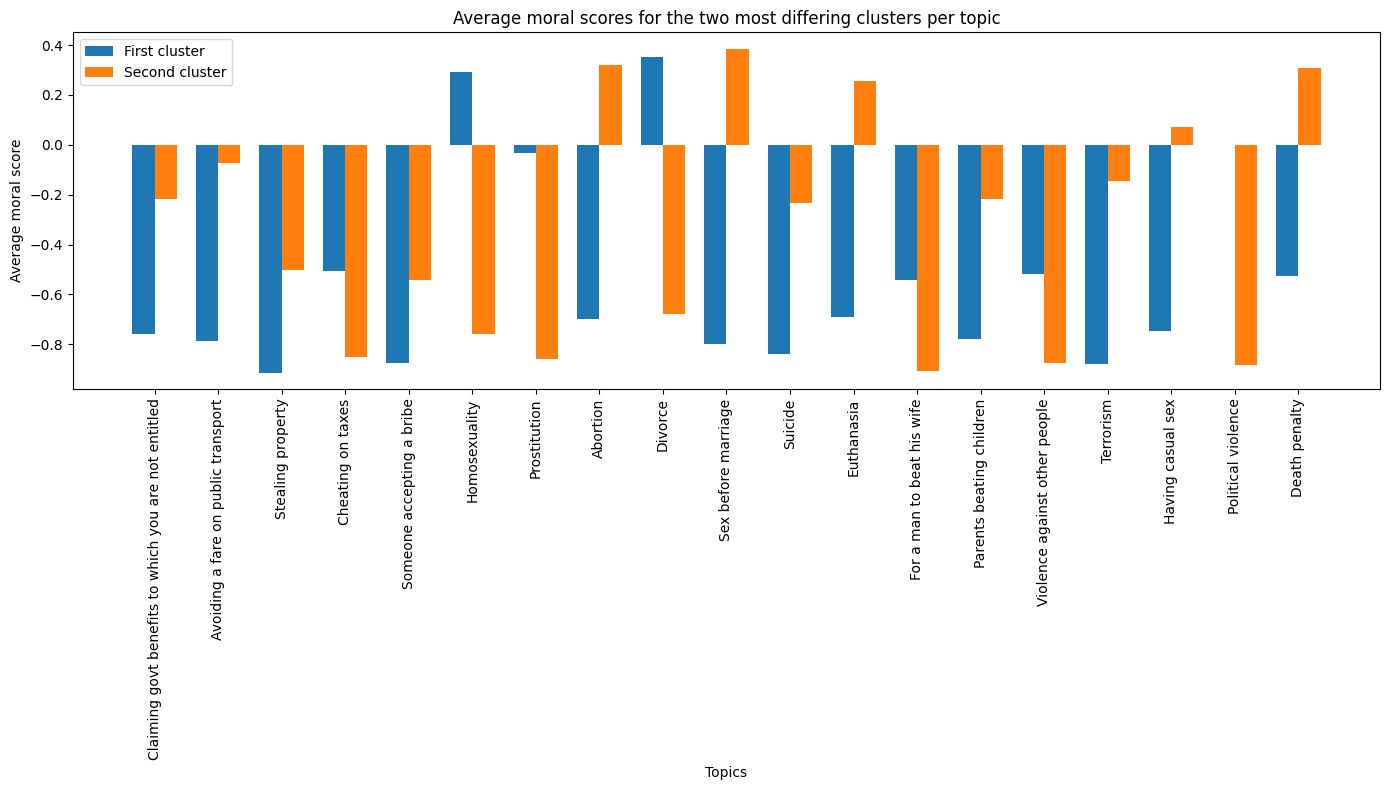

In [ ]:
# ff hard coded most different cluster averages WVS, dit later integreren zodat most_different_clusters en cluster_averages in de eerste functie (find_topic_clusters) wordt gedaan ipv telkens opnieuw in generate_topic_prompts

import matplotlib.pyplot as plt
import numpy as np

# Data
topics = [
    "Claiming govt benefits to which you are not entitled",
    "Avoiding a fare on public transport",
    "Stealing property",
    "Cheating on taxes",
    "Someone accepting a bribe",
    "Homosexuality",
    "Prostitution",
    "Abortion",
    "Divorce",
    "Sex before marriage",
    "Suicide",
    "Euthanasia",
    "For a man to beat his wife",
    "Parents beating children",
    "Violence against other people",
    "Terrorism",
    "Having casual sex",
    "Political violence",
    "Death penalty"
]

avg_scores_cluster1 = [
    -0.76, -0.788, -0.913, -0.506, -0.875,
    0.292, -0.032, -0.698, 0.353, -0.799,
    -0.84, -0.689, -0.541, -0.778, -0.516,
    -0.877, -0.748, 0.0, -0.528
]

avg_scores_cluster2 = [
    -0.217, -0.072, -0.503, -0.851, -0.542,
    -0.759, -0.857, 0.319, -0.678, 0.386,
    -0.234, 0.255, -0.906, -0.218, -0.875,
    -0.147, 0.071, -0.884, 0.309
]

x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, avg_scores_cluster1, width, label='First cluster')
rects2 = ax.bar(x + width/2, avg_scores_cluster2, width, label='Second cluster')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Average moral score')
ax.set_title('Average moral scores for the two most differing clusters per topic')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=90)
ax.legend()

fig.tight_layout()

plt.show()


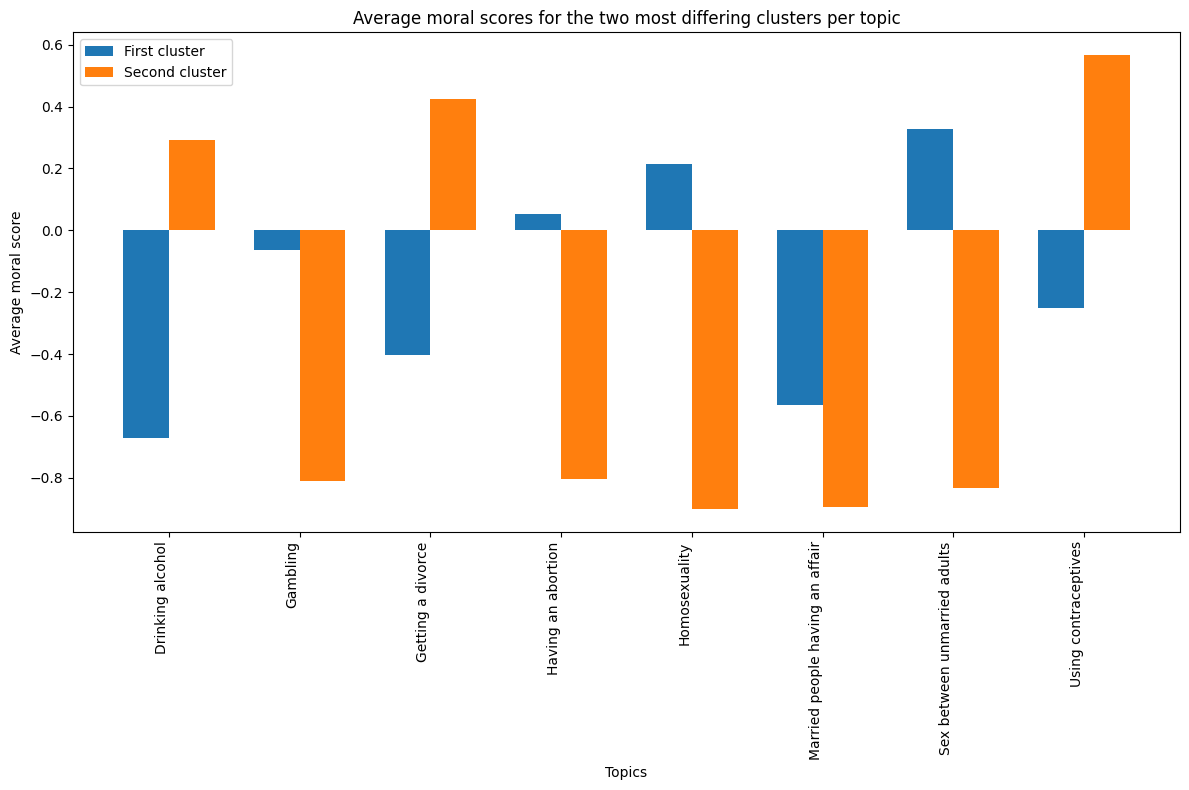

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
topics = [
    "Drinking alcohol",
    "Gambling",
    "Getting a divorce",
    "Having an abortion",
    "Homosexuality",
    "Married people having an affair",
    "Sex between unmarried adults",
    "Using contraceptives"
]

avg_scores_cluster1 = [
    -0.671, -0.062, -0.403, 0.053, 0.216,
    -0.564, 0.328, -0.251
]

avg_scores_cluster2 = [
    0.293, -0.81, 0.424, -0.804, -0.901,
    -0.896, -0.833, 0.567
]

x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, avg_scores_cluster1, width, label='First cluster')
rects2 = ax.bar(x + width/2, avg_scores_cluster2, width, label='Second cluster')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Average moral score')
ax.set_title('Average moral scores for the two most differing clusters per topic')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=90, ha="right")
ax.legend()

fig.tight_layout()

plt.show()
